# Import data

In [23]:
import pandas as pd

df = pd.read_csv (r'data_science_dataset_test_task.csv')

In [24]:
df

,Unnamed: 0,current_dt,user_id,scheduled_dt,root_order_id,gender,age,os_family,lt_user,hours_after_reg_buy,...,was_3ds,card_type,card_country_code,success_orders,not_success_orders,insufficients,root_gross,not_root_gross,old_model_probability,is_success
0,37,2019-05-12 05:40:15.355095,13801584,2019-06-09 00:00:00.000000,96601292,f,43,11,2,0,...,0,2.0,154,2,0,0,29.17,6.81,0.512364,1
1,45,2019-06-07 08:10:15.982701,16144816,2019-06-09 00:00:00.000000,116843195,f,25,11,4,76,...,0,2.0,3,2,1,1,0.47,0.46,0.133615,1
2,46,2019-06-07 08:10:15.982701,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,1,0,...,0,2.0,1,2,1,0,0.48,6.67,0.481923,0
3,47,2019-06-08 03:10:13.314904,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,2,0,...,0,2.0,1,2,1,0,0.48,6.67,0.485032,0
4,51,2019-06-07 08:10:15.982701,16482460,2019-06-09 00:00:00.000000,116953235,m,45,11,1,0,...,0,2.0,1,1,1,1,0.48,0.00,0.114275,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516175,2529503,2019-06-10 03:10:26.278224,16739665,2019-06-12 00:00:00.000000,119034644,m,33,3,1,0,...,0,5.0,1,1,0,0,0.49,0.00,0.347410,0
516176,2529507,2019-04-24 09:52:20.196516,11889793,2019-04-25 00:00:00.000000,83051270,m,26,3,2,0,...,0,5.0,2,1,0,0,0.54,0.00,0.408876,0
516177,2529508,2019-04-23 09:52:20.571080,11889793,2019-04-25 00:00:00.000000,83051270,m,26,3,1,0,...,0,5.0,2,1,0,0,0.54,0.00,0.406511,0
516178,2529509,2019-04-09 12:37:18.809619,10262442,2019-04-10 00:00:00.000000,71802674,m,44,3,2,0,...,0,2.0,1,1,3,0,0.48,0.00,0.114544,0


In [25]:
#find the true class distribution
print('is_success 1 ',sum(df.is_success == 1))
print('is_success 0 ',sum(df.is_success == 0))

is_success 1  105976
is_success 0  410204


# Old model score

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
pd.options.mode.chained_assignment = None  # default='warn'

score_df = df[['old_model_probability','is_success']]
score_df.loc[score_df['old_model_probability'] >= 0.5, 'old_model_probability'] = 1 
score_df.loc[score_df['old_model_probability'] < 0.5, 'old_model_probability'] = 0 
y_true = score_df.is_success.tolist()
y_pred = score_df.old_model_probability.astype(int).tolist()

print('confusion matrix ')
print(confusion_matrix(y_true, y_pred, labels=[1,0]))
print('precision', precision_score(y_true, y_pred))
print('recall', recall_score(y_true, y_pred))
print('f1 ', f1_score(y_true, y_pred))
print('accuracy_score ', accuracy_score(y_true, y_pred))

confusion matrix 
[[ 13291  92685]
 [ 11877 398327]]
precision 0.5280912269548633
recall 0.12541518834453083
f1  0.20269322271701337
accuracy_score  0.7974311286760433


Проблемы у текущей модели - её характеристики по возможностям прогнозирования.
Её нельзя использовать в продакшине. Модель почти везде поставила значение = "0", что дает неплохое accuracy, но плохой recall и F1.
Accuracy не является хорошей метрикой для несбалансированной выборки, лучше использовать precision, recall, F1, AUC или аналоги.

# CatBoost model

In [27]:
X = df.drop(['Unnamed: 0','old_model_probability','is_success','current_dt','scheduled_dt'],axis=1)
y = df['is_success']

In [28]:
#one hot encoding
X = pd.get_dummies(X, prefix=['gender'], columns = ['gender'])

# Use Optuna to optimize hyperparameters

In [1]:
import numpy as np
import catboost as cb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import optuna

def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)

    param = {
        "loss_function": trial.suggest_categorical("MultiClass", ["Logloss"]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["F1"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 8, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=300)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    pred_labels = [int(i) for i in pred_labels]
    f1 = f1_score(valid_y, pred_labels)
    

    print('precision', precision_score(valid_y, pred_labels))
    print('recall', recall_score(valid_y, pred_labels))
    print('f1 ', f1_score(valid_y, pred_labels))
    print('accuracy_score ', accuracy_score(valid_y, pred_labels))

    return f1

# run&run...

In [2]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10000, timeout=None)

[I 2022-01-26 00:28:10,624] A new study created in memory with name: no-name-32528e51-bd5c-4ef9-b01d-253a9fa8f897
[W 2022-01-26 00:28:10,628] Trial 0 failed because of the following error: NameError("name 'X' is not defined")
Traceback (most recent call last):
  File "d:\program files\python38\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\lysyi\AppData\Local\Temp/ipykernel_7976/4282930080.py", line 8, in objective
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)
NameError: name 'X' is not defined


NameError: name 'X' is not defined

# Best score

In [23]:
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of completed trials: 99
Best trial:
	Best Score: 0.5655520317513306
	Best Params: 
    loss_function: Logloss
    eval_metric: F1
    learning_rate: 0.47564468869150534
    l2_leaf_reg: 0.4587313929622077
    colsample_bylevel: 0.09822692562668793
    depth: 15
    boosting_type: Plain
    bootstrap_type: Bernoulli
    min_data_in_leaf: 6
    one_hot_max_size: 12


# Use this best hyperparameters and cross validation to find True score

In [53]:
# from catboost import Pool, cv
cv_dataset = Pool(data=X,
                  label=y)

params ={'loss_function': 'Logloss', 
         'eval_metric': 'F1', 
         'learning_rate': 0.47564468869150534, 
         'l2_leaf_reg': 0.4587313929622077, 
         'colsample_bylevel': 0.09822692562668793, 
         'depth': 15, 
         'boosting_type': 'Plain', 
         'bootstrap_type': 'Bernoulli', 
         'min_data_in_leaf': 6, 
         'one_hot_max_size': 12}

scores = cv(cv_dataset,
            params,
            fold_count=4, 
            plot="True")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]
0:	learn: 0.1272300	test: 0.1258514	best: 0.1258514 (0)	total: 125ms	remaining: 2m 5s
1:	learn: 0.0035897	test: 0.0031622	best: 0.1258514 (0)	total: 155ms	remaining: 1m 17s
2:	learn: 0.0440648	test: 0.0352575	best: 0.1258514 (0)	total: 1.21s	remaining: 6m 42s
3:	learn: 0.0294830	test: 0.0226658	best: 0.1258514 (0)	total: 1.24s	remaining: 5m 9s
4:	learn: 0.1057042	test: 0.0855694	best: 0.1258514 (0)	total: 2.02s	remaining: 6m 42s
5:	learn: 0.1470727	test: 0.1269617	best: 0.1269617 (5)	total: 2.09s	remaining: 5m 45s
6:	learn: 0.1713655	test: 0.1513184	best: 0.1513184 (6)	total: 2.15s	remaining: 5m 5s
7:	learn: 0.1711230	test: 0.1509434	best: 0.1513184 (6)	total: 2.18s	remaining: 4m 30s
8:	learn: 0.1706749	test: 0.1505073	best: 0.1513184 (6)	total: 2.21s	remaining: 4m 3s
9:	learn: 0.2069068	test: 0.1782229	best: 0.1782229 (9)	total: 2.77s	remaining: 4m 34s
10:	learn: 0.2156918	test: 0.1872827	best: 0.1872827 (10)	total: 2.87s	remaining: 4m 17s
11:	learn: 0.2163718	t

93:	learn: 0.5699088	test: 0.3798486	best: 0.3800926 (89)	total: 34.3s	remaining: 5m 30s
94:	learn: 0.5708060	test: 0.3800841	best: 0.3800926 (89)	total: 34.4s	remaining: 5m 27s
95:	learn: 0.5759443	test: 0.3826206	best: 0.3826206 (95)	total: 35s	remaining: 5m 29s
96:	learn: 0.5768590	test: 0.3839489	best: 0.3839489 (96)	total: 35.1s	remaining: 5m 26s
97:	learn: 0.5799431	test: 0.3860172	best: 0.3860172 (97)	total: 35.8s	remaining: 5m 29s
98:	learn: 0.5808771	test: 0.3864052	best: 0.3864052 (98)	total: 35.9s	remaining: 5m 26s
99:	learn: 0.5839851	test: 0.3886944	best: 0.3886944 (99)	total: 36.9s	remaining: 5m 31s
100:	learn: 0.5843075	test: 0.3887917	best: 0.3887917 (100)	total: 36.9s	remaining: 5m 28s
101:	learn: 0.5845777	test: 0.3894443	best: 0.3894443 (101)	total: 37s	remaining: 5m 25s
102:	learn: 0.5870965	test: 0.3907554	best: 0.3907554 (102)	total: 37.7s	remaining: 5m 28s
103:	learn: 0.5874967	test: 0.3905060	best: 0.3907554 (102)	total: 37.7s	remaining: 5m 25s
104:	learn: 0.592

188:	learn: 0.7150814	test: 0.4520857	best: 0.4524746 (182)	total: 1m 11s	remaining: 5m 8s
189:	learn: 0.7162165	test: 0.4528087	best: 0.4528087 (189)	total: 1m 12s	remaining: 5m 7s
190:	learn: 0.7162536	test: 0.4531401	best: 0.4531401 (190)	total: 1m 12s	remaining: 5m 6s
191:	learn: 0.7171120	test: 0.4539386	best: 0.4539386 (191)	total: 1m 13s	remaining: 5m 8s
192:	learn: 0.7171448	test: 0.4539814	best: 0.4539814 (192)	total: 1m 13s	remaining: 5m 6s
193:	learn: 0.7180920	test: 0.4547027	best: 0.4547027 (193)	total: 1m 13s	remaining: 5m 6s
194:	learn: 0.7192972	test: 0.4545140	best: 0.4547027 (193)	total: 1m 14s	remaining: 5m 7s
195:	learn: 0.7195515	test: 0.4545320	best: 0.4547027 (193)	total: 1m 14s	remaining: 5m 6s
196:	learn: 0.7211581	test: 0.4548033	best: 0.4548033 (196)	total: 1m 15s	remaining: 5m 8s
197:	learn: 0.7213528	test: 0.4553186	best: 0.4553186 (197)	total: 1m 15s	remaining: 5m 6s
198:	learn: 0.7223314	test: 0.4561395	best: 0.4561395 (198)	total: 1m 16s	remaining: 5m 6s

278:	learn: 0.7983514	test: 0.4867242	best: 0.4867242 (278)	total: 2m 10s	remaining: 5m 36s
279:	learn: 0.7987229	test: 0.4866918	best: 0.4867242 (278)	total: 2m 10s	remaining: 5m 34s
280:	learn: 0.7987113	test: 0.4869877	best: 0.4869877 (280)	total: 2m 10s	remaining: 5m 33s
281:	learn: 0.7996583	test: 0.4877443	best: 0.4877443 (281)	total: 2m 11s	remaining: 5m 33s
282:	learn: 0.7999796	test: 0.4880554	best: 0.4880554 (282)	total: 2m 11s	remaining: 5m 32s
283:	learn: 0.8000263	test: 0.4880438	best: 0.4880554 (282)	total: 2m 11s	remaining: 5m 30s
284:	learn: 0.7999153	test: 0.4879039	best: 0.4880554 (282)	total: 2m 11s	remaining: 5m 29s
285:	learn: 0.8015808	test: 0.4892509	best: 0.4892509 (285)	total: 2m 12s	remaining: 5m 30s
286:	learn: 0.8016360	test: 0.4893465	best: 0.4893465 (286)	total: 2m 12s	remaining: 5m 29s
287:	learn: 0.8016683	test: 0.4891426	best: 0.4893465 (286)	total: 2m 12s	remaining: 5m 27s
288:	learn: 0.8028967	test: 0.4906210	best: 0.4906210 (288)	total: 2m 13s	remain

369:	learn: 0.8388005	test: 0.5126401	best: 0.5126401 (369)	total: 2m 48s	remaining: 4m 47s
370:	learn: 0.8398886	test: 0.5127989	best: 0.5127989 (370)	total: 2m 49s	remaining: 4m 47s
371:	learn: 0.8399159	test: 0.5127520	best: 0.5127989 (370)	total: 2m 49s	remaining: 4m 46s
372:	learn: 0.8404112	test: 0.5117807	best: 0.5127989 (370)	total: 2m 50s	remaining: 4m 46s
373:	learn: 0.8412003	test: 0.5130802	best: 0.5130802 (373)	total: 2m 51s	remaining: 4m 46s
374:	learn: 0.8413519	test: 0.5127436	best: 0.5130802 (373)	total: 2m 51s	remaining: 4m 45s
375:	learn: 0.8413198	test: 0.5128830	best: 0.5130802 (373)	total: 2m 51s	remaining: 4m 44s
376:	learn: 0.8413579	test: 0.5128578	best: 0.5130802 (373)	total: 2m 51s	remaining: 4m 43s
377:	learn: 0.8414296	test: 0.5129059	best: 0.5130802 (373)	total: 2m 51s	remaining: 4m 42s
378:	learn: 0.8414049	test: 0.5129179	best: 0.5130802 (373)	total: 2m 51s	remaining: 4m 41s
379:	learn: 0.8413967	test: 0.5129179	best: 0.5130802 (373)	total: 2m 51s	remain

459:	learn: 0.8693468	test: 0.5261329	best: 0.5269378 (448)	total: 3m 21s	remaining: 3m 56s
460:	learn: 0.8703777	test: 0.5272466	best: 0.5272466 (460)	total: 3m 22s	remaining: 3m 56s
461:	learn: 0.8704188	test: 0.5274975	best: 0.5274975 (461)	total: 3m 22s	remaining: 3m 55s
462:	learn: 0.8708346	test: 0.5278408	best: 0.5278408 (462)	total: 3m 23s	remaining: 3m 55s
463:	learn: 0.8716140	test: 0.5284660	best: 0.5284660 (463)	total: 3m 24s	remaining: 3m 55s
464:	learn: 0.8720088	test: 0.5279693	best: 0.5284660 (463)	total: 3m 24s	remaining: 3m 55s
465:	learn: 0.8720280	test: 0.5280130	best: 0.5284660 (463)	total: 3m 24s	remaining: 3m 54s
466:	learn: 0.8727033	test: 0.5289191	best: 0.5289191 (466)	total: 3m 25s	remaining: 3m 54s
467:	learn: 0.8735073	test: 0.5303216	best: 0.5303216 (467)	total: 3m 26s	remaining: 3m 55s
468:	learn: 0.8740424	test: 0.5302414	best: 0.5303216 (467)	total: 3m 27s	remaining: 3m 55s
469:	learn: 0.8740789	test: 0.5302536	best: 0.5303216 (467)	total: 3m 27s	remain

549:	learn: 0.8964540	test: 0.5424163	best: 0.5427781 (540)	total: 4m 1s	remaining: 3m 17s
550:	learn: 0.8964629	test: 0.5425240	best: 0.5427781 (540)	total: 4m 1s	remaining: 3m 16s
551:	learn: 0.8978383	test: 0.5417143	best: 0.5427781 (540)	total: 4m 2s	remaining: 3m 16s
552:	learn: 0.8981499	test: 0.5417609	best: 0.5427781 (540)	total: 4m 3s	remaining: 3m 16s
553:	learn: 0.8988165	test: 0.5420228	best: 0.5427781 (540)	total: 4m 4s	remaining: 3m 17s
554:	learn: 0.8989016	test: 0.5421065	best: 0.5427781 (540)	total: 4m 5s	remaining: 3m 16s
555:	learn: 0.8988819	test: 0.5420894	best: 0.5427781 (540)	total: 4m 5s	remaining: 3m 15s
556:	learn: 0.8988819	test: 0.5420894	best: 0.5427781 (540)	total: 4m 5s	remaining: 3m 14s
557:	learn: 0.8993469	test: 0.5423187	best: 0.5427781 (540)	total: 4m 5s	remaining: 3m 14s
558:	learn: 0.8993483	test: 0.5422854	best: 0.5427781 (540)	total: 4m 5s	remaining: 3m 13s
559:	learn: 0.8993613	test: 0.5422358	best: 0.5427781 (540)	total: 4m 5s	remaining: 3m 12s

639:	learn: 0.9156042	test: 0.5496339	best: 0.5499761 (638)	total: 4m 43s	remaining: 2m 39s
640:	learn: 0.9156249	test: 0.5496114	best: 0.5499761 (638)	total: 4m 44s	remaining: 2m 39s
641:	learn: 0.9160148	test: 0.5483849	best: 0.5499761 (638)	total: 4m 45s	remaining: 2m 38s
642:	learn: 0.9162467	test: 0.5488279	best: 0.5499761 (638)	total: 4m 45s	remaining: 2m 38s
643:	learn: 0.9163324	test: 0.5492334	best: 0.5499761 (638)	total: 4m 46s	remaining: 2m 38s
644:	learn: 0.9163274	test: 0.5492619	best: 0.5499761 (638)	total: 4m 46s	remaining: 2m 37s
645:	learn: 0.9163335	test: 0.5492868	best: 0.5499761 (638)	total: 4m 47s	remaining: 2m 37s
646:	learn: 0.9164013	test: 0.5492699	best: 0.5499761 (638)	total: 4m 47s	remaining: 2m 36s
647:	learn: 0.9163924	test: 0.5493767	best: 0.5499761 (638)	total: 4m 47s	remaining: 2m 36s
648:	learn: 0.9170063	test: 0.5496436	best: 0.5499761 (638)	total: 4m 48s	remaining: 2m 35s
649:	learn: 0.9170063	test: 0.5496311	best: 0.5499761 (638)	total: 4m 48s	remain

732:	learn: 0.9310150	test: 0.5529086	best: 0.5546817 (722)	total: 5m 21s	remaining: 1m 57s
733:	learn: 0.9312315	test: 0.5527283	best: 0.5546817 (722)	total: 5m 22s	remaining: 1m 56s
734:	learn: 0.9312386	test: 0.5527360	best: 0.5546817 (722)	total: 5m 22s	remaining: 1m 56s
735:	learn: 0.9314019	test: 0.5528693	best: 0.5546817 (722)	total: 5m 23s	remaining: 1m 55s
736:	learn: 0.9316778	test: 0.5527389	best: 0.5546817 (722)	total: 5m 23s	remaining: 1m 55s
737:	learn: 0.9316831	test: 0.5525243	best: 0.5546817 (722)	total: 5m 24s	remaining: 1m 55s
738:	learn: 0.9320083	test: 0.5526968	best: 0.5546817 (722)	total: 5m 25s	remaining: 1m 54s
739:	learn: 0.9320003	test: 0.5526221	best: 0.5546817 (722)	total: 5m 25s	remaining: 1m 54s
740:	learn: 0.9320003	test: 0.5526547	best: 0.5546817 (722)	total: 5m 25s	remaining: 1m 53s
741:	learn: 0.9321970	test: 0.5520303	best: 0.5546817 (722)	total: 5m 26s	remaining: 1m 53s
742:	learn: 0.9321606	test: 0.5520427	best: 0.5546817 (722)	total: 5m 26s	remain

823:	learn: 0.9411765	test: 0.5561949	best: 0.5570719 (819)	total: 5m 54s	remaining: 1m 15s
824:	learn: 0.9411835	test: 0.5561949	best: 0.5570719 (819)	total: 5m 54s	remaining: 1m 15s
825:	learn: 0.9411780	test: 0.5561750	best: 0.5570719 (819)	total: 5m 54s	remaining: 1m 14s
826:	learn: 0.9416355	test: 0.5567691	best: 0.5570719 (819)	total: 5m 55s	remaining: 1m 14s
827:	learn: 0.9417572	test: 0.5569859	best: 0.5570719 (819)	total: 5m 56s	remaining: 1m 14s
828:	learn: 0.9420136	test: 0.5574367	best: 0.5574367 (828)	total: 5m 57s	remaining: 1m 13s
829:	learn: 0.9422289	test: 0.5573616	best: 0.5574367 (828)	total: 5m 58s	remaining: 1m 13s
830:	learn: 0.9422289	test: 0.5573042	best: 0.5574367 (828)	total: 5m 58s	remaining: 1m 12s
831:	learn: 0.9424806	test: 0.5574742	best: 0.5574742 (831)	total: 5m 59s	remaining: 1m 12s
832:	learn: 0.9427142	test: 0.5575817	best: 0.5575817 (832)	total: 6m	remaining: 1m 12s
833:	learn: 0.9427281	test: 0.5575817	best: 0.5575817 (832)	total: 6m	remaining: 1m 

916:	learn: 0.9497703	test: 0.5625698	best: 0.5633237 (910)	total: 6m 40s	remaining: 36.2s
917:	learn: 0.9498946	test: 0.5630457	best: 0.5633237 (910)	total: 6m 41s	remaining: 35.9s
918:	learn: 0.9501489	test: 0.5639548	best: 0.5639548 (918)	total: 6m 42s	remaining: 35.5s
919:	learn: 0.9502500	test: 0.5639617	best: 0.5639617 (919)	total: 6m 42s	remaining: 35s
920:	learn: 0.9504125	test: 0.5640464	best: 0.5640464 (920)	total: 6m 43s	remaining: 34.6s
921:	learn: 0.9504331	test: 0.5639778	best: 0.5640464 (920)	total: 6m 43s	remaining: 34.2s
922:	learn: 0.9504599	test: 0.5640224	best: 0.5640464 (920)	total: 6m 43s	remaining: 33.7s
923:	learn: 0.9508542	test: 0.5645835	best: 0.5645835 (923)	total: 6m 44s	remaining: 33.3s
924:	learn: 0.9508548	test: 0.5646029	best: 0.5646029 (924)	total: 6m 44s	remaining: 32.8s
925:	learn: 0.9508941	test: 0.5647747	best: 0.5647747 (925)	total: 6m 44s	remaining: 32.3s
926:	learn: 0.9509035	test: 0.5647348	best: 0.5647747 (925)	total: 6m 44s	remaining: 31.9s
9

8:	learn: 0.1768950	test: 0.1584384	best: 0.1584384 (8)	total: 1.8s	remaining: 3m 18s
9:	learn: 0.2217892	test: 0.1899808	best: 0.1899808 (9)	total: 2.89s	remaining: 4m 46s
10:	learn: 0.2243887	test: 0.1918842	best: 0.1918842 (10)	total: 2.92s	remaining: 4m 22s
11:	learn: 0.2258505	test: 0.1926689	best: 0.1926689 (11)	total: 2.96s	remaining: 4m 3s
12:	learn: 0.2259359	test: 0.1934876	best: 0.1934876 (12)	total: 3.02s	remaining: 3m 49s
13:	learn: 0.2313472	test: 0.1960416	best: 0.1960416 (13)	total: 3.35s	remaining: 3m 55s
14:	learn: 0.2473140	test: 0.2066642	best: 0.2066642 (14)	total: 4.51s	remaining: 4m 56s
15:	learn: 0.2616172	test: 0.2138295	best: 0.2138295 (15)	total: 5.36s	remaining: 5m 29s
16:	learn: 0.2659215	test: 0.2171680	best: 0.2171680 (16)	total: 5.43s	remaining: 5m 13s
17:	learn: 0.2677736	test: 0.2189358	best: 0.2189358 (17)	total: 5.52s	remaining: 5m 1s
18:	learn: 0.2784681	test: 0.2268714	best: 0.2268714 (18)	total: 6.47s	remaining: 5m 33s
19:	learn: 0.2828931	test: 0

103:	learn: 0.5799252	test: 0.3830549	best: 0.3830549 (103)	total: 40.8s	remaining: 5m 51s
104:	learn: 0.5824034	test: 0.3851731	best: 0.3851731 (104)	total: 41.4s	remaining: 5m 53s
105:	learn: 0.5826250	test: 0.3854150	best: 0.3854150 (105)	total: 41.5s	remaining: 5m 49s
106:	learn: 0.5846403	test: 0.3851688	best: 0.3854150 (105)	total: 42.3s	remaining: 5m 53s
107:	learn: 0.5868441	test: 0.3857476	best: 0.3857476 (107)	total: 43.2s	remaining: 5m 56s
108:	learn: 0.5875469	test: 0.3863595	best: 0.3863595 (108)	total: 43.3s	remaining: 5m 53s
109:	learn: 0.5884985	test: 0.3878118	best: 0.3878118 (109)	total: 44s	remaining: 5m 55s
110:	learn: 0.5941244	test: 0.3893597	best: 0.3893597 (110)	total: 44.7s	remaining: 5m 57s
111:	learn: 0.5945158	test: 0.3892288	best: 0.3893597 (110)	total: 44.8s	remaining: 5m 54s
112:	learn: 0.5980790	test: 0.3919427	best: 0.3919427 (112)	total: 45.7s	remaining: 5m 58s
113:	learn: 0.6029729	test: 0.3961610	best: 0.3961610 (113)	total: 46.7s	remaining: 6m 3s
11

194:	learn: 0.7080088	test: 0.4390280	best: 0.4390280 (194)	total: 1m 16s	remaining: 5m 16s
195:	learn: 0.7097871	test: 0.4406890	best: 0.4406890 (195)	total: 1m 17s	remaining: 5m 18s
196:	learn: 0.7099615	test: 0.4409123	best: 0.4409123 (196)	total: 1m 17s	remaining: 5m 16s
197:	learn: 0.7132979	test: 0.4434982	best: 0.4434982 (197)	total: 1m 18s	remaining: 5m 17s
198:	learn: 0.7136240	test: 0.4436977	best: 0.4436977 (198)	total: 1m 18s	remaining: 5m 16s
199:	learn: 0.7137132	test: 0.4439024	best: 0.4439024 (199)	total: 1m 18s	remaining: 5m 14s
200:	learn: 0.7152294	test: 0.4440296	best: 0.4440296 (200)	total: 1m 19s	remaining: 5m 15s
201:	learn: 0.7191367	test: 0.4449312	best: 0.4449312 (201)	total: 1m 20s	remaining: 5m 17s
202:	learn: 0.7197247	test: 0.4457765	best: 0.4457765 (202)	total: 1m 20s	remaining: 5m 15s
203:	learn: 0.7214834	test: 0.4470477	best: 0.4470477 (203)	total: 1m 21s	remaining: 5m 16s
204:	learn: 0.7217134	test: 0.4469752	best: 0.4470477 (203)	total: 1m 21s	remain

284:	learn: 0.7837401	test: 0.4727070	best: 0.4737046 (275)	total: 1m 50s	remaining: 4m 36s
285:	learn: 0.7844166	test: 0.4722148	best: 0.4737046 (275)	total: 1m 51s	remaining: 4m 37s
286:	learn: 0.7844198	test: 0.4722148	best: 0.4737046 (275)	total: 1m 51s	remaining: 4m 36s
287:	learn: 0.7845882	test: 0.4730361	best: 0.4737046 (275)	total: 1m 51s	remaining: 4m 35s
288:	learn: 0.7858074	test: 0.4738472	best: 0.4738472 (288)	total: 1m 52s	remaining: 4m 36s
289:	learn: 0.7875997	test: 0.4741769	best: 0.4741769 (289)	total: 1m 53s	remaining: 4m 37s
290:	learn: 0.7876363	test: 0.4743869	best: 0.4743869 (290)	total: 1m 53s	remaining: 4m 36s
291:	learn: 0.7876577	test: 0.4741959	best: 0.4743869 (290)	total: 1m 53s	remaining: 4m 34s
292:	learn: 0.7876844	test: 0.4741615	best: 0.4743869 (290)	total: 1m 53s	remaining: 4m 33s
293:	learn: 0.7904381	test: 0.4764021	best: 0.4764021 (293)	total: 1m 54s	remaining: 4m 34s
294:	learn: 0.7916578	test: 0.4759075	best: 0.4764021 (293)	total: 1m 55s	remain

374:	learn: 0.8361735	test: 0.4969817	best: 0.4975018 (373)	total: 2m 30s	remaining: 4m 10s
375:	learn: 0.8362076	test: 0.4970173	best: 0.4975018 (373)	total: 2m 30s	remaining: 4m 9s
376:	learn: 0.8362066	test: 0.4977048	best: 0.4977048 (376)	total: 2m 30s	remaining: 4m 8s
377:	learn: 0.8362198	test: 0.4972302	best: 0.4977048 (376)	total: 2m 30s	remaining: 4m 7s
378:	learn: 0.8364306	test: 0.4975977	best: 0.4977048 (376)	total: 2m 31s	remaining: 4m 7s
379:	learn: 0.8367309	test: 0.4978112	best: 0.4978112 (379)	total: 2m 31s	remaining: 4m 7s
380:	learn: 0.8367309	test: 0.4978112	best: 0.4978112 (379)	total: 2m 31s	remaining: 4m 6s
381:	learn: 0.8370518	test: 0.4985093	best: 0.4985093 (381)	total: 2m 32s	remaining: 4m 7s
382:	learn: 0.8370446	test: 0.4987108	best: 0.4987108 (382)	total: 2m 32s	remaining: 4m 6s
383:	learn: 0.8372467	test: 0.4985212	best: 0.4987108 (382)	total: 2m 32s	remaining: 4m 5s
384:	learn: 0.8373717	test: 0.4986401	best: 0.4987108 (382)	total: 2m 32s	remaining: 4m 4

465:	learn: 0.8752283	test: 0.5156443	best: 0.5156443 (465)	total: 3m 8s	remaining: 3m 35s
466:	learn: 0.8753130	test: 0.5156683	best: 0.5156683 (466)	total: 3m 8s	remaining: 3m 34s
467:	learn: 0.8752802	test: 0.5157239	best: 0.5157239 (467)	total: 3m 8s	remaining: 3m 33s
468:	learn: 0.8752802	test: 0.5157239	best: 0.5157239 (467)	total: 3m 8s	remaining: 3m 33s
469:	learn: 0.8753208	test: 0.5157794	best: 0.5157794 (469)	total: 3m 8s	remaining: 3m 32s
470:	learn: 0.8754505	test: 0.5153968	best: 0.5157794 (469)	total: 3m 9s	remaining: 3m 32s
471:	learn: 0.8754427	test: 0.5153968	best: 0.5157794 (469)	total: 3m 9s	remaining: 3m 31s
472:	learn: 0.8754661	test: 0.5154807	best: 0.5157794 (469)	total: 3m 9s	remaining: 3m 30s
473:	learn: 0.8754141	test: 0.5152347	best: 0.5157794 (469)	total: 3m 9s	remaining: 3m 29s
474:	learn: 0.8757459	test: 0.5151684	best: 0.5157794 (469)	total: 3m 9s	remaining: 3m 29s
475:	learn: 0.8763135	test: 0.5162101	best: 0.5162101 (475)	total: 3m 9s	remaining: 3m 29s

558:	learn: 0.8977110	test: 0.5281369	best: 0.5283088 (554)	total: 3m 42s	remaining: 2m 55s
559:	learn: 0.8977608	test: 0.5281708	best: 0.5283088 (554)	total: 3m 42s	remaining: 2m 54s
560:	learn: 0.8984002	test: 0.5286362	best: 0.5286362 (560)	total: 3m 43s	remaining: 2m 54s
561:	learn: 0.8984227	test: 0.5286362	best: 0.5286362 (560)	total: 3m 43s	remaining: 2m 54s
562:	learn: 0.8984077	test: 0.5285658	best: 0.5286362 (560)	total: 3m 43s	remaining: 2m 53s
563:	learn: 0.8990030	test: 0.5283314	best: 0.5286362 (560)	total: 3m 44s	remaining: 2m 53s
564:	learn: 0.8990030	test: 0.5283314	best: 0.5286362 (560)	total: 3m 44s	remaining: 2m 52s
565:	learn: 0.8992084	test: 0.5285780	best: 0.5286362 (560)	total: 3m 44s	remaining: 2m 52s
566:	learn: 0.8992084	test: 0.5285780	best: 0.5286362 (560)	total: 3m 44s	remaining: 2m 51s
567:	learn: 0.8992084	test: 0.5285780	best: 0.5286362 (560)	total: 3m 44s	remaining: 2m 50s
568:	learn: 0.8992097	test: 0.5285537	best: 0.5286362 (560)	total: 3m 44s	remain

648:	learn: 0.9145455	test: 0.5400543	best: 0.5400543 (648)	total: 4m 15s	remaining: 2m 18s
649:	learn: 0.9147161	test: 0.5399246	best: 0.5400543 (648)	total: 4m 15s	remaining: 2m 17s
650:	learn: 0.9147234	test: 0.5399370	best: 0.5400543 (648)	total: 4m 15s	remaining: 2m 17s
651:	learn: 0.9147234	test: 0.5399370	best: 0.5400543 (648)	total: 4m 15s	remaining: 2m 16s
652:	learn: 0.9147184	test: 0.5398703	best: 0.5400543 (648)	total: 4m 16s	remaining: 2m 16s
653:	learn: 0.9149618	test: 0.5400087	best: 0.5400543 (648)	total: 4m 16s	remaining: 2m 15s
654:	learn: 0.9151626	test: 0.5395572	best: 0.5400543 (648)	total: 4m 17s	remaining: 2m 15s
655:	learn: 0.9150724	test: 0.5397818	best: 0.5400543 (648)	total: 4m 17s	remaining: 2m 14s
656:	learn: 0.9151016	test: 0.5397941	best: 0.5400543 (648)	total: 4m 17s	remaining: 2m 14s
657:	learn: 0.9152636	test: 0.5396847	best: 0.5400543 (648)	total: 4m 17s	remaining: 2m 13s
658:	learn: 0.9152636	test: 0.5396847	best: 0.5400543 (648)	total: 4m 17s	remain

738:	learn: 0.9275220	test: 0.5447153	best: 0.5459663 (733)	total: 4m 47s	remaining: 1m 41s
739:	learn: 0.9279012	test: 0.5446201	best: 0.5459663 (733)	total: 4m 49s	remaining: 1m 41s
740:	learn: 0.9281517	test: 0.5445048	best: 0.5459663 (733)	total: 4m 49s	remaining: 1m 41s
741:	learn: 0.9282620	test: 0.5443107	best: 0.5459663 (733)	total: 4m 49s	remaining: 1m 40s
742:	learn: 0.9290635	test: 0.5442365	best: 0.5459663 (733)	total: 4m 51s	remaining: 1m 40s
743:	learn: 0.9291816	test: 0.5449221	best: 0.5459663 (733)	total: 4m 52s	remaining: 1m 40s
744:	learn: 0.9292385	test: 0.5450089	best: 0.5459663 (733)	total: 4m 52s	remaining: 1m 39s
745:	learn: 0.9295441	test: 0.5460855	best: 0.5460855 (745)	total: 4m 52s	remaining: 1m 39s
746:	learn: 0.9296567	test: 0.5456278	best: 0.5460855 (745)	total: 4m 53s	remaining: 1m 39s
747:	learn: 0.9297012	test: 0.5456278	best: 0.5460855 (745)	total: 4m 53s	remaining: 1m 38s
748:	learn: 0.9303388	test: 0.5453514	best: 0.5460855 (745)	total: 4m 54s	remain

830:	learn: 0.9400078	test: 0.5469029	best: 0.5484404 (810)	total: 5m 23s	remaining: 1m 5s
831:	learn: 0.9404656	test: 0.5466236	best: 0.5484404 (810)	total: 5m 24s	remaining: 1m 5s
832:	learn: 0.9404664	test: 0.5466441	best: 0.5484404 (810)	total: 5m 24s	remaining: 1m 5s
833:	learn: 0.9405129	test: 0.5467999	best: 0.5484404 (810)	total: 5m 25s	remaining: 1m 4s
834:	learn: 0.9407967	test: 0.5465208	best: 0.5484404 (810)	total: 5m 26s	remaining: 1m 4s
835:	learn: 0.9410393	test: 0.5466967	best: 0.5484404 (810)	total: 5m 27s	remaining: 1m 4s
836:	learn: 0.9410393	test: 0.5466967	best: 0.5484404 (810)	total: 5m 27s	remaining: 1m 3s
837:	learn: 0.9409982	test: 0.5467782	best: 0.5484404 (810)	total: 5m 28s	remaining: 1m 3s
838:	learn: 0.9410052	test: 0.5467782	best: 0.5484404 (810)	total: 5m 28s	remaining: 1m 3s
839:	learn: 0.9409641	test: 0.5467289	best: 0.5484404 (810)	total: 5m 28s	remaining: 1m 2s
840:	learn: 0.9409486	test: 0.5467451	best: 0.5484404 (810)	total: 5m 28s	remaining: 1m 2s

921:	learn: 0.9499774	test: 0.5504240	best: 0.5516001 (916)	total: 6m 12s	remaining: 31.5s
922:	learn: 0.9499774	test: 0.5504240	best: 0.5516001 (916)	total: 6m 12s	remaining: 31.1s
923:	learn: 0.9502517	test: 0.5510989	best: 0.5516001 (916)	total: 6m 13s	remaining: 30.8s
924:	learn: 0.9505140	test: 0.5511049	best: 0.5516001 (916)	total: 6m 14s	remaining: 30.4s
925:	learn: 0.9505215	test: 0.5511049	best: 0.5516001 (916)	total: 6m 14s	remaining: 29.9s
926:	learn: 0.9506238	test: 0.5509823	best: 0.5516001 (916)	total: 6m 14s	remaining: 29.5s
927:	learn: 0.9506300	test: 0.5509497	best: 0.5516001 (916)	total: 6m 14s	remaining: 29.1s
928:	learn: 0.9506094	test: 0.5510305	best: 0.5516001 (916)	total: 6m 14s	remaining: 28.7s
929:	learn: 0.9506657	test: 0.5513239	best: 0.5516001 (916)	total: 6m 15s	remaining: 28.3s
930:	learn: 0.9507392	test: 0.5513689	best: 0.5516001 (916)	total: 6m 15s	remaining: 27.9s
931:	learn: 0.9506644	test: 0.5512679	best: 0.5516001 (916)	total: 6m 15s	remaining: 27.4s

13:	learn: 0.2455085	test: 0.2126629	best: 0.2126629 (13)	total: 3.69s	remaining: 4m 20s
14:	learn: 0.2549216	test: 0.2210879	best: 0.2210879 (14)	total: 4.12s	remaining: 4m 30s
15:	learn: 0.2642304	test: 0.2268337	best: 0.2268337 (15)	total: 4.81s	remaining: 4m 55s
16:	learn: 0.2656972	test: 0.2273297	best: 0.2273297 (16)	total: 4.87s	remaining: 4m 41s
17:	learn: 0.2661710	test: 0.2283777	best: 0.2283777 (17)	total: 4.9s	remaining: 4m 27s
18:	learn: 0.2821804	test: 0.2375231	best: 0.2375231 (18)	total: 5.6s	remaining: 4m 49s
19:	learn: 0.2883892	test: 0.2418210	best: 0.2418210 (19)	total: 5.74s	remaining: 4m 41s
20:	learn: 0.2897675	test: 0.2433739	best: 0.2433739 (20)	total: 5.77s	remaining: 4m 28s
21:	learn: 0.3134598	test: 0.2542837	best: 0.2542837 (21)	total: 6.73s	remaining: 4m 59s
22:	learn: 0.3155318	test: 0.2563935	best: 0.2563935 (22)	total: 6.76s	remaining: 4m 47s
23:	learn: 0.3181209	test: 0.2579269	best: 0.2579269 (23)	total: 6.84s	remaining: 4m 38s
24:	learn: 0.3332106	te

107:	learn: 0.5944086	test: 0.3963611	best: 0.3963611 (107)	total: 46.7s	remaining: 6m 25s
108:	learn: 0.5945067	test: 0.3966441	best: 0.3966441 (108)	total: 46.8s	remaining: 6m 22s
109:	learn: 0.5974585	test: 0.3990085	best: 0.3990085 (109)	total: 48s	remaining: 6m 28s
110:	learn: 0.5976129	test: 0.3988726	best: 0.3990085 (109)	total: 48s	remaining: 6m 24s
111:	learn: 0.5978864	test: 0.3994260	best: 0.3994260 (111)	total: 48s	remaining: 6m 20s
112:	learn: 0.5981154	test: 0.4000939	best: 0.4000939 (112)	total: 48.1s	remaining: 6m 17s
113:	learn: 0.6057449	test: 0.4040099	best: 0.4040099 (113)	total: 49.1s	remaining: 6m 21s
114:	learn: 0.6110199	test: 0.4062686	best: 0.4062686 (114)	total: 50.3s	remaining: 6m 26s
115:	learn: 0.6113861	test: 0.4068052	best: 0.4068052 (115)	total: 50.3s	remaining: 6m 23s
116:	learn: 0.6114859	test: 0.4063983	best: 0.4068052 (115)	total: 50.4s	remaining: 6m 20s
117:	learn: 0.6153241	test: 0.4070352	best: 0.4070352 (117)	total: 51.5s	remaining: 6m 24s
118:	

198:	learn: 0.7168291	test: 0.4548740	best: 0.4548740 (198)	total: 1m 30s	remaining: 6m 2s
199:	learn: 0.7169582	test: 0.4549932	best: 0.4549932 (199)	total: 1m 30s	remaining: 6m
200:	learn: 0.7202130	test: 0.4563928	best: 0.4563928 (200)	total: 1m 31s	remaining: 6m 2s
201:	learn: 0.7207817	test: 0.4567108	best: 0.4567108 (201)	total: 1m 31s	remaining: 6m
202:	learn: 0.7223882	test: 0.4565851	best: 0.4567108 (201)	total: 1m 31s	remaining: 6m
203:	learn: 0.7231638	test: 0.4572854	best: 0.4572854 (203)	total: 1m 32s	remaining: 5m 59s
204:	learn: 0.7232032	test: 0.4572939	best: 0.4572939 (204)	total: 1m 32s	remaining: 5m 57s
205:	learn: 0.7243625	test: 0.4571725	best: 0.4572939 (204)	total: 1m 32s	remaining: 5m 56s
206:	learn: 0.7244896	test: 0.4573672	best: 0.4573672 (206)	total: 1m 32s	remaining: 5m 54s
207:	learn: 0.7262598	test: 0.4573347	best: 0.4573672 (206)	total: 1m 33s	remaining: 5m 56s
208:	learn: 0.7284497	test: 0.4597831	best: 0.4597831 (208)	total: 1m 34s	remaining: 5m 57s
20

288:	learn: 0.7811037	test: 0.4847508	best: 0.4847508 (288)	total: 2m 8s	remaining: 5m 16s
289:	learn: 0.7830512	test: 0.4855611	best: 0.4855611 (289)	total: 2m 9s	remaining: 5m 17s
290:	learn: 0.7830595	test: 0.4855755	best: 0.4855755 (290)	total: 2m 9s	remaining: 5m 15s
291:	learn: 0.7847021	test: 0.4873162	best: 0.4873162 (291)	total: 2m 10s	remaining: 5m 17s
292:	learn: 0.7858041	test: 0.4879793	best: 0.4879793 (292)	total: 2m 11s	remaining: 5m 18s
293:	learn: 0.7858550	test: 0.4881746	best: 0.4881746 (293)	total: 2m 11s	remaining: 5m 16s
294:	learn: 0.7868877	test: 0.4892545	best: 0.4892545 (294)	total: 2m 13s	remaining: 5m 18s
295:	learn: 0.7875030	test: 0.4898585	best: 0.4898585 (295)	total: 2m 13s	remaining: 5m 17s
296:	learn: 0.7881102	test: 0.4900758	best: 0.4900758 (296)	total: 2m 13s	remaining: 5m 16s
297:	learn: 0.7894262	test: 0.4907902	best: 0.4907902 (297)	total: 2m 14s	remaining: 5m 17s
298:	learn: 0.7915164	test: 0.4923452	best: 0.4923452 (298)	total: 2m 15s	remaining

380:	learn: 0.8346033	test: 0.5108675	best: 0.5108675 (380)	total: 2m 50s	remaining: 4m 37s
381:	learn: 0.8354155	test: 0.5109757	best: 0.5109757 (381)	total: 2m 51s	remaining: 4m 37s
382:	learn: 0.8360112	test: 0.5121670	best: 0.5121670 (382)	total: 2m 52s	remaining: 4m 37s
383:	learn: 0.8360314	test: 0.5120730	best: 0.5121670 (382)	total: 2m 52s	remaining: 4m 36s
384:	learn: 0.8360951	test: 0.5120598	best: 0.5121670 (382)	total: 2m 52s	remaining: 4m 35s
385:	learn: 0.8361269	test: 0.5123528	best: 0.5123528 (385)	total: 2m 52s	remaining: 4m 34s
386:	learn: 0.8361080	test: 0.5123396	best: 0.5123528 (385)	total: 2m 52s	remaining: 4m 33s
387:	learn: 0.8371408	test: 0.5117864	best: 0.5123528 (385)	total: 2m 53s	remaining: 4m 33s
388:	learn: 0.8373888	test: 0.5121023	best: 0.5123528 (385)	total: 2m 53s	remaining: 4m 33s
389:	learn: 0.8374949	test: 0.5116662	best: 0.5123528 (385)	total: 2m 54s	remaining: 4m 32s
390:	learn: 0.8379131	test: 0.5126398	best: 0.5126398 (390)	total: 2m 54s	remain

470:	learn: 0.8686772	test: 0.5193683	best: 0.5202624 (463)	total: 3m 31s	remaining: 3m 57s
471:	learn: 0.8686772	test: 0.5193683	best: 0.5202624 (463)	total: 3m 31s	remaining: 3m 56s
472:	learn: 0.8687275	test: 0.5193098	best: 0.5202624 (463)	total: 3m 31s	remaining: 3m 55s
473:	learn: 0.8687710	test: 0.5195161	best: 0.5202624 (463)	total: 3m 31s	remaining: 3m 54s
474:	learn: 0.8693306	test: 0.5189538	best: 0.5202624 (463)	total: 3m 32s	remaining: 3m 54s
475:	learn: 0.8701925	test: 0.5191960	best: 0.5202624 (463)	total: 3m 33s	remaining: 3m 54s
476:	learn: 0.8701575	test: 0.5188160	best: 0.5202624 (463)	total: 3m 33s	remaining: 3m 53s
477:	learn: 0.8701889	test: 0.5188504	best: 0.5202624 (463)	total: 3m 33s	remaining: 3m 53s
478:	learn: 0.8702771	test: 0.5187626	best: 0.5202624 (463)	total: 3m 33s	remaining: 3m 52s
479:	learn: 0.8702596	test: 0.5186612	best: 0.5202624 (463)	total: 3m 33s	remaining: 3m 51s
480:	learn: 0.8711053	test: 0.5190585	best: 0.5202624 (463)	total: 3m 34s	remain

561:	learn: 0.8930582	test: 0.5265413	best: 0.5267228 (559)	total: 4m 14s	remaining: 3m 18s
562:	learn: 0.8930658	test: 0.5265413	best: 0.5267228 (559)	total: 4m 14s	remaining: 3m 17s
563:	learn: 0.8934173	test: 0.5277260	best: 0.5277260 (563)	total: 4m 15s	remaining: 3m 17s
564:	learn: 0.8934371	test: 0.5277017	best: 0.5277260 (563)	total: 4m 15s	remaining: 3m 16s
565:	learn: 0.8934507	test: 0.5277548	best: 0.5277548 (565)	total: 4m 15s	remaining: 3m 16s
566:	learn: 0.8934781	test: 0.5277426	best: 0.5277548 (565)	total: 4m 15s	remaining: 3m 15s
567:	learn: 0.8934234	test: 0.5276263	best: 0.5277548 (565)	total: 4m 15s	remaining: 3m 14s
568:	learn: 0.8934234	test: 0.5276384	best: 0.5277548 (565)	total: 4m 15s	remaining: 3m 13s
569:	learn: 0.8942089	test: 0.5293237	best: 0.5293237 (569)	total: 4m 17s	remaining: 3m 13s
570:	learn: 0.8941914	test: 0.5295755	best: 0.5295755 (570)	total: 4m 17s	remaining: 3m 13s
571:	learn: 0.8948188	test: 0.5294375	best: 0.5295755 (570)	total: 4m 18s	remain

651:	learn: 0.9139700	test: 0.5407034	best: 0.5409118 (650)	total: 4m 49s	remaining: 2m 34s
652:	learn: 0.9140647	test: 0.5407243	best: 0.5409118 (650)	total: 4m 49s	remaining: 2m 33s
653:	learn: 0.9141965	test: 0.5407614	best: 0.5409118 (650)	total: 4m 49s	remaining: 2m 33s
654:	learn: 0.9144694	test: 0.5411904	best: 0.5411904 (654)	total: 4m 50s	remaining: 2m 33s
655:	learn: 0.9152757	test: 0.5422863	best: 0.5422863 (655)	total: 4m 51s	remaining: 2m 32s
656:	learn: 0.9157878	test: 0.5429334	best: 0.5429334 (656)	total: 4m 52s	remaining: 2m 32s
657:	learn: 0.9157890	test: 0.5429210	best: 0.5429334 (656)	total: 4m 52s	remaining: 2m 31s
658:	learn: 0.9161930	test: 0.5424896	best: 0.5429334 (656)	total: 4m 52s	remaining: 2m 31s
659:	learn: 0.9166885	test: 0.5429757	best: 0.5429757 (659)	total: 4m 53s	remaining: 2m 31s
660:	learn: 0.9170617	test: 0.5430956	best: 0.5430956 (660)	total: 4m 54s	remaining: 2m 30s
661:	learn: 0.9169034	test: 0.5431164	best: 0.5431164 (661)	total: 4m 54s	remain

741:	learn: 0.9286028	test: 0.5495048	best: 0.5495048 (741)	total: 5m 22s	remaining: 1m 52s
742:	learn: 0.9286028	test: 0.5495377	best: 0.5495377 (742)	total: 5m 22s	remaining: 1m 51s
743:	learn: 0.9289948	test: 0.5500272	best: 0.5500272 (743)	total: 5m 23s	remaining: 1m 51s
744:	learn: 0.9289858	test: 0.5505921	best: 0.5505921 (744)	total: 5m 24s	remaining: 1m 51s
745:	learn: 0.9295582	test: 0.5493634	best: 0.5505921 (744)	total: 5m 25s	remaining: 1m 50s
746:	learn: 0.9300350	test: 0.5494272	best: 0.5505921 (744)	total: 5m 26s	remaining: 1m 50s
747:	learn: 0.9306454	test: 0.5507273	best: 0.5507273 (747)	total: 5m 27s	remaining: 1m 50s
748:	learn: 0.9308098	test: 0.5511159	best: 0.5511159 (748)	total: 5m 28s	remaining: 1m 49s
749:	learn: 0.9308382	test: 0.5511362	best: 0.5511362 (749)	total: 5m 28s	remaining: 1m 49s
750:	learn: 0.9308799	test: 0.5512423	best: 0.5512423 (750)	total: 5m 28s	remaining: 1m 48s
751:	learn: 0.9309561	test: 0.5512751	best: 0.5512751 (751)	total: 5m 28s	remain

832:	learn: 0.9410547	test: 0.5561640	best: 0.5563344 (828)	total: 6m	remaining: 1m 12s
833:	learn: 0.9410756	test: 0.5565245	best: 0.5565245 (833)	total: 6m	remaining: 1m 11s
834:	learn: 0.9410593	test: 0.5560188	best: 0.5565245 (833)	total: 6m 1s	remaining: 1m 11s
835:	learn: 0.9415146	test: 0.5560164	best: 0.5565245 (833)	total: 6m 2s	remaining: 1m 11s
836:	learn: 0.9414820	test: 0.5562368	best: 0.5565245 (833)	total: 6m 2s	remaining: 1m 10s
837:	learn: 0.9414820	test: 0.5562368	best: 0.5565245 (833)	total: 6m 3s	remaining: 1m 10s
838:	learn: 0.9414603	test: 0.5560188	best: 0.5565245 (833)	total: 6m 3s	remaining: 1m 9s
839:	learn: 0.9414673	test: 0.5560589	best: 0.5565245 (833)	total: 6m 3s	remaining: 1m 9s
840:	learn: 0.9415921	test: 0.5562944	best: 0.5565245 (833)	total: 6m 3s	remaining: 1m 8s
841:	learn: 0.9416905	test: 0.5566876	best: 0.5566876 (841)	total: 6m 4s	remaining: 1m 8s
842:	learn: 0.9416835	test: 0.5567977	best: 0.5567977 (842)	total: 6m 4s	remaining: 1m 7s
843:	learn

923:	learn: 0.9504768	test: 0.5625716	best: 0.5630950 (914)	total: 6m 43s	remaining: 33.2s
924:	learn: 0.9504768	test: 0.5625716	best: 0.5630950 (914)	total: 6m 43s	remaining: 32.7s
925:	learn: 0.9504899	test: 0.5625856	best: 0.5630950 (914)	total: 6m 43s	remaining: 32.3s
926:	learn: 0.9504905	test: 0.5625407	best: 0.5630950 (914)	total: 6m 43s	remaining: 31.8s
927:	learn: 0.9505909	test: 0.5618900	best: 0.5630950 (914)	total: 6m 44s	remaining: 31.4s
928:	learn: 0.9508113	test: 0.5625182	best: 0.5630950 (914)	total: 6m 45s	remaining: 31s
929:	learn: 0.9509355	test: 0.5622420	best: 0.5630950 (914)	total: 6m 46s	remaining: 30.6s
930:	learn: 0.9509224	test: 0.5622868	best: 0.5630950 (914)	total: 6m 46s	remaining: 30.1s
931:	learn: 0.9512297	test: 0.5628659	best: 0.5630950 (914)	total: 6m 47s	remaining: 29.7s
932:	learn: 0.9512297	test: 0.5628659	best: 0.5630950 (914)	total: 6m 47s	remaining: 29.3s
933:	learn: 0.9514548	test: 0.5627453	best: 0.5630950 (914)	total: 6m 48s	remaining: 28.9s
9

14:	learn: 0.2249696	test: 0.1965071	best: 0.1965071 (14)	total: 5.5s	remaining: 6m 1s
15:	learn: 0.2440822	test: 0.2095870	best: 0.2095870 (15)	total: 7.04s	remaining: 7m 12s
16:	learn: 0.2470199	test: 0.2124440	best: 0.2124440 (16)	total: 7.14s	remaining: 6m 52s
17:	learn: 0.2476843	test: 0.2135497	best: 0.2135497 (17)	total: 7.18s	remaining: 6m 31s
18:	learn: 0.2485268	test: 0.2145632	best: 0.2145632 (18)	total: 7.22s	remaining: 6m 12s
19:	learn: 0.2533440	test: 0.2176328	best: 0.2176328 (19)	total: 7.76s	remaining: 6m 20s
20:	learn: 0.2578952	test: 0.2203997	best: 0.2203997 (20)	total: 7.9s	remaining: 6m 8s
21:	learn: 0.2579880	test: 0.2205428	best: 0.2205428 (21)	total: 7.95s	remaining: 5m 53s
22:	learn: 0.2599541	test: 0.2221475	best: 0.2221475 (22)	total: 8.07s	remaining: 5m 42s
23:	learn: 0.2603377	test: 0.2224461	best: 0.2224461 (23)	total: 8.13s	remaining: 5m 30s
24:	learn: 0.2606174	test: 0.2229004	best: 0.2229004 (24)	total: 8.2s	remaining: 5m 19s
25:	learn: 0.2607123	test:

108:	learn: 0.5529445	test: 0.3797983	best: 0.3797983 (108)	total: 50.6s	remaining: 6m 53s
109:	learn: 0.5598449	test: 0.3840148	best: 0.3840148 (109)	total: 52.2s	remaining: 7m 2s
110:	learn: 0.5603249	test: 0.3840312	best: 0.3840312 (110)	total: 52.3s	remaining: 6m 58s
111:	learn: 0.5625602	test: 0.3867400	best: 0.3867400 (111)	total: 53.3s	remaining: 7m 2s
112:	learn: 0.5628264	test: 0.3869015	best: 0.3869015 (112)	total: 53.4s	remaining: 6m 59s
113:	learn: 0.5664353	test: 0.3902798	best: 0.3902798 (113)	total: 54.5s	remaining: 7m 3s
114:	learn: 0.5669078	test: 0.3904334	best: 0.3904334 (114)	total: 54.6s	remaining: 7m
115:	learn: 0.5671692	test: 0.3905729	best: 0.3905729 (115)	total: 54.7s	remaining: 6m 56s
116:	learn: 0.5670077	test: 0.3910409	best: 0.3910409 (116)	total: 54.7s	remaining: 6m 52s
117:	learn: 0.5669676	test: 0.3909451	best: 0.3910409 (116)	total: 54.8s	remaining: 6m 49s
118:	learn: 0.5669460	test: 0.3909554	best: 0.3910409 (116)	total: 54.8s	remaining: 6m 45s
119:	l

199:	learn: 0.6791519	test: 0.4470241	best: 0.4470241 (199)	total: 1m 35s	remaining: 6m 22s
200:	learn: 0.6860260	test: 0.4525110	best: 0.4525110 (200)	total: 1m 37s	remaining: 6m 25s
201:	learn: 0.6883383	test: 0.4540678	best: 0.4540678 (201)	total: 1m 37s	remaining: 6m 25s
202:	learn: 0.6916832	test: 0.4559452	best: 0.4559452 (202)	total: 1m 38s	remaining: 6m 27s
203:	learn: 0.6918669	test: 0.4560733	best: 0.4560733 (203)	total: 1m 38s	remaining: 6m 25s
204:	learn: 0.6951896	test: 0.4579036	best: 0.4579036 (204)	total: 1m 40s	remaining: 6m 28s
205:	learn: 0.6953151	test: 0.4583168	best: 0.4583168 (205)	total: 1m 40s	remaining: 6m 26s
206:	learn: 0.6954549	test: 0.4584696	best: 0.4584696 (206)	total: 1m 40s	remaining: 6m 24s
207:	learn: 0.6981131	test: 0.4602927	best: 0.4602927 (207)	total: 1m 41s	remaining: 6m 26s
208:	learn: 0.6981586	test: 0.4603006	best: 0.4603006 (208)	total: 1m 41s	remaining: 6m 24s
209:	learn: 0.7000202	test: 0.4614395	best: 0.4614395 (209)	total: 1m 42s	remain

289:	learn: 0.7681450	test: 0.4918088	best: 0.4918088 (289)	total: 2m 32s	remaining: 6m 13s
290:	learn: 0.7684323	test: 0.4922465	best: 0.4922465 (290)	total: 2m 32s	remaining: 6m 12s
291:	learn: 0.7693417	test: 0.4925785	best: 0.4925785 (291)	total: 2m 34s	remaining: 6m 13s
292:	learn: 0.7697679	test: 0.4923011	best: 0.4925785 (291)	total: 2m 35s	remaining: 6m 14s
293:	learn: 0.7732539	test: 0.4918402	best: 0.4925785 (291)	total: 2m 36s	remaining: 6m 15s
294:	learn: 0.7732847	test: 0.4920224	best: 0.4925785 (291)	total: 2m 36s	remaining: 6m 14s
295:	learn: 0.7757482	test: 0.4936763	best: 0.4936763 (295)	total: 2m 38s	remaining: 6m 16s
296:	learn: 0.7758424	test: 0.4937870	best: 0.4937870 (296)	total: 2m 38s	remaining: 6m 14s
297:	learn: 0.7758544	test: 0.4941238	best: 0.4941238 (297)	total: 2m 38s	remaining: 6m 12s
298:	learn: 0.7762896	test: 0.4940039	best: 0.4941238 (297)	total: 2m 38s	remaining: 6m 11s
299:	learn: 0.7772966	test: 0.4954164	best: 0.4954164 (299)	total: 2m 39s	remain

379:	learn: 0.8283326	test: 0.5172130	best: 0.5172130 (379)	total: 3m 37s	remaining: 5m 55s
380:	learn: 0.8285547	test: 0.5176520	best: 0.5176520 (380)	total: 3m 37s	remaining: 5m 54s
381:	learn: 0.8297426	test: 0.5179565	best: 0.5179565 (381)	total: 3m 39s	remaining: 5m 54s
382:	learn: 0.8308169	test: 0.5193769	best: 0.5193769 (382)	total: 3m 39s	remaining: 5m 54s
383:	learn: 0.8310219	test: 0.5195658	best: 0.5195658 (383)	total: 3m 41s	remaining: 5m 54s
384:	learn: 0.8314576	test: 0.5198031	best: 0.5198031 (384)	total: 3m 41s	remaining: 5m 54s
385:	learn: 0.8317466	test: 0.5195755	best: 0.5198031 (384)	total: 3m 41s	remaining: 5m 52s
386:	learn: 0.8322852	test: 0.5198651	best: 0.5198651 (386)	total: 3m 42s	remaining: 5m 53s
387:	learn: 0.8345889	test: 0.5192713	best: 0.5198651 (386)	total: 3m 43s	remaining: 5m 53s
388:	learn: 0.8354175	test: 0.5197510	best: 0.5198651 (386)	total: 3m 45s	remaining: 5m 53s
389:	learn: 0.8361218	test: 0.5205390	best: 0.5205390 (389)	total: 3m 46s	remain

469:	learn: 0.8662544	test: 0.5387486	best: 0.5387486 (469)	total: 4m 35s	remaining: 5m 10s
470:	learn: 0.8674422	test: 0.5398595	best: 0.5398595 (470)	total: 4m 36s	remaining: 5m 10s
471:	learn: 0.8674580	test: 0.5398595	best: 0.5398595 (470)	total: 4m 36s	remaining: 5m 9s
472:	learn: 0.8681940	test: 0.5396906	best: 0.5398595 (470)	total: 4m 37s	remaining: 5m 9s
473:	learn: 0.8683499	test: 0.5395912	best: 0.5398595 (470)	total: 4m 37s	remaining: 5m 8s
474:	learn: 0.8688817	test: 0.5395715	best: 0.5398595 (470)	total: 4m 38s	remaining: 5m 7s
475:	learn: 0.8702041	test: 0.5392441	best: 0.5398595 (470)	total: 4m 39s	remaining: 5m 8s
476:	learn: 0.8715972	test: 0.5402444	best: 0.5402444 (476)	total: 4m 41s	remaining: 5m 8s
477:	learn: 0.8722496	test: 0.5409859	best: 0.5409859 (477)	total: 4m 42s	remaining: 5m 8s
478:	learn: 0.8725434	test: 0.5410043	best: 0.5410043 (478)	total: 4m 43s	remaining: 5m 7s
479:	learn: 0.8734175	test: 0.5416427	best: 0.5416427 (479)	total: 4m 44s	remaining: 5m 

560:	learn: 0.8906638	test: 0.5471788	best: 0.5471788 (560)	total: 5m 25s	remaining: 4m 14s
561:	learn: 0.8906850	test: 0.5472201	best: 0.5472201 (561)	total: 5m 25s	remaining: 4m 13s
562:	learn: 0.8907245	test: 0.5471496	best: 0.5472201 (561)	total: 5m 25s	remaining: 4m 12s
563:	learn: 0.8906986	test: 0.5470752	best: 0.5472201 (561)	total: 5m 25s	remaining: 4m 11s
564:	learn: 0.8907712	test: 0.5465773	best: 0.5472201 (561)	total: 5m 26s	remaining: 4m 11s
565:	learn: 0.8907743	test: 0.5467514	best: 0.5472201 (561)	total: 5m 26s	remaining: 4m 10s
566:	learn: 0.8907653	test: 0.5464822	best: 0.5472201 (561)	total: 5m 26s	remaining: 4m 9s
567:	learn: 0.8913702	test: 0.5464989	best: 0.5472201 (561)	total: 5m 27s	remaining: 4m 9s
568:	learn: 0.8916158	test: 0.5469828	best: 0.5472201 (561)	total: 5m 27s	remaining: 4m 8s
569:	learn: 0.8927062	test: 0.5479951	best: 0.5479951 (569)	total: 5m 29s	remaining: 4m 8s
570:	learn: 0.8933666	test: 0.5483402	best: 0.5483402 (570)	total: 5m 30s	remaining:

652:	learn: 0.9115561	test: 0.5572621	best: 0.5583908 (640)	total: 6m 16s	remaining: 3m 20s
653:	learn: 0.9115597	test: 0.5572569	best: 0.5583908 (640)	total: 6m 16s	remaining: 3m 19s
654:	learn: 0.9115365	test: 0.5573674	best: 0.5583908 (640)	total: 6m 16s	remaining: 3m 18s
655:	learn: 0.9116867	test: 0.5571865	best: 0.5583908 (640)	total: 6m 17s	remaining: 3m 18s
656:	learn: 0.9116526	test: 0.5569305	best: 0.5583908 (640)	total: 6m 18s	remaining: 3m 17s
657:	learn: 0.9118944	test: 0.5568223	best: 0.5583908 (640)	total: 6m 19s	remaining: 3m 17s
658:	learn: 0.9122172	test: 0.5571710	best: 0.5583908 (640)	total: 6m 19s	remaining: 3m 16s
659:	learn: 0.9125844	test: 0.5586123	best: 0.5586123 (659)	total: 6m 20s	remaining: 3m 16s
660:	learn: 0.9126382	test: 0.5585492	best: 0.5586123 (659)	total: 6m 21s	remaining: 3m 15s
661:	learn: 0.9133567	test: 0.5588707	best: 0.5588707 (661)	total: 6m 22s	remaining: 3m 15s
662:	learn: 0.9140345	test: 0.5596096	best: 0.5596096 (662)	total: 6m 23s	remain

743:	learn: 0.9264464	test: 0.5668161	best: 0.5678293 (740)	total: 7m 8s	remaining: 2m 27s
744:	learn: 0.9264760	test: 0.5666682	best: 0.5678293 (740)	total: 7m 8s	remaining: 2m 26s
745:	learn: 0.9266008	test: 0.5671066	best: 0.5678293 (740)	total: 7m 9s	remaining: 2m 26s
746:	learn: 0.9266193	test: 0.5671515	best: 0.5678293 (740)	total: 7m 9s	remaining: 2m 25s
747:	learn: 0.9267399	test: 0.5668370	best: 0.5678293 (740)	total: 7m 9s	remaining: 2m 24s
748:	learn: 0.9267399	test: 0.5668370	best: 0.5678293 (740)	total: 7m 9s	remaining: 2m 24s
749:	learn: 0.9267399	test: 0.5668370	best: 0.5678293 (740)	total: 7m 9s	remaining: 2m 23s
750:	learn: 0.9267266	test: 0.5670618	best: 0.5678293 (740)	total: 7m 10s	remaining: 2m 22s
751:	learn: 0.9269979	test: 0.5684781	best: 0.5684781 (751)	total: 7m 11s	remaining: 2m 22s
752:	learn: 0.9270450	test: 0.5683819	best: 0.5684781 (751)	total: 7m 11s	remaining: 2m 21s
753:	learn: 0.9272869	test: 0.5675415	best: 0.5684781 (751)	total: 7m 12s	remaining: 2m

833:	learn: 0.9379792	test: 0.5749810	best: 0.5749899 (831)	total: 7m 44s	remaining: 1m 32s
834:	learn: 0.9382408	test: 0.5750061	best: 0.5750061 (834)	total: 7m 44s	remaining: 1m 31s
835:	learn: 0.9382486	test: 0.5750061	best: 0.5750061 (834)	total: 7m 44s	remaining: 1m 31s
836:	learn: 0.9382416	test: 0.5750061	best: 0.5750061 (834)	total: 7m 44s	remaining: 1m 30s
837:	learn: 0.9383872	test: 0.5748214	best: 0.5750061 (834)	total: 7m 45s	remaining: 1m 30s
838:	learn: 0.9384408	test: 0.5747321	best: 0.5750061 (834)	total: 7m 45s	remaining: 1m 29s
839:	learn: 0.9385513	test: 0.5751015	best: 0.5751015 (839)	total: 7m 47s	remaining: 1m 29s
840:	learn: 0.9390532	test: 0.5738385	best: 0.5751015 (839)	total: 7m 48s	remaining: 1m 28s
841:	learn: 0.9391008	test: 0.5742146	best: 0.5751015 (839)	total: 7m 48s	remaining: 1m 27s
842:	learn: 0.9391296	test: 0.5738133	best: 0.5751015 (839)	total: 7m 48s	remaining: 1m 27s
843:	learn: 0.9391242	test: 0.5742278	best: 0.5751015 (839)	total: 7m 48s	remain

925:	learn: 0.9479156	test: 0.5785080	best: 0.5797198 (883)	total: 8m 46s	remaining: 42s
926:	learn: 0.9479225	test: 0.5785208	best: 0.5797198 (883)	total: 8m 46s	remaining: 41.4s
927:	learn: 0.9480467	test: 0.5780945	best: 0.5797198 (883)	total: 8m 47s	remaining: 41s
928:	learn: 0.9480467	test: 0.5780945	best: 0.5797198 (883)	total: 8m 47s	remaining: 40.3s
929:	learn: 0.9481494	test: 0.5789836	best: 0.5797198 (883)	total: 8m 48s	remaining: 39.8s
930:	learn: 0.9481149	test: 0.5788632	best: 0.5797198 (883)	total: 8m 48s	remaining: 39.2s
931:	learn: 0.9481487	test: 0.5790081	best: 0.5797198 (883)	total: 8m 48s	remaining: 38.6s
932:	learn: 0.9482232	test: 0.5789088	best: 0.5797198 (883)	total: 8m 48s	remaining: 38s
933:	learn: 0.9481825	test: 0.5786739	best: 0.5797198 (883)	total: 8m 48s	remaining: 37.4s
934:	learn: 0.9481756	test: 0.5786166	best: 0.5797198 (883)	total: 8m 48s	remaining: 36.8s
935:	learn: 0.9484155	test: 0.5784005	best: 0.5797198 (883)	total: 8m 50s	remaining: 36.3s
936:	

Можно ещё немного увеличить score путем отправки большего колличества данных на обучение, давайте отправим 90%, а валидировать будем на оставшихся 10%. (тут главное не заоверфитить)

In [54]:
# from catboost import Pool, cv
cv_dataset = Pool(data=X,
                  label=y)

params ={'loss_function': 'Logloss', 
         'eval_metric': 'F1', 
         'learning_rate': 0.47564468869150534, 
         'l2_leaf_reg': 0.4587313929622077, 
         'colsample_bylevel': 0.09822692562668793, 
         'depth': 15, 
         'boosting_type': 'Plain', 
         'bootstrap_type': 'Bernoulli', 
         'min_data_in_leaf': 6, 
         'one_hot_max_size': 12}

scores = cv(cv_dataset,
            params,
            fold_count=10, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.1509547	test: 0.1371147	best: 0.1371147 (0)	total: 925ms	remaining: 15m 24s
1:	learn: 0.1010989	test: 0.0886383	best: 0.1371147 (0)	total: 985ms	remaining: 8m 11s
2:	learn: 0.0422947	test: 0.0354792	best: 0.1371147 (0)	total: 1.05s	remaining: 5m 49s
3:	learn: 0.0271028	test: 0.0223888	best: 0.1371147 (0)	total: 1.1s	remaining: 4m 35s
4:	learn: 0.0184466	test: 0.0160119	best: 0.1371147 (0)	total: 1.16s	remaining: 3m 50s
5:	learn: 0.0157296	test: 0.0126878	best: 0.1371147 (0)	total: 1.2s	remaining: 3m 19s
6:	learn: 0.0198734	test: 0.0161815	best: 0.1371147 (0)	total: 1.26s	remaining: 2m 58s
7:	learn: 0.1011558	test: 0.0838166	best: 0.1371147 (0)	total: 2.44s	remaining: 5m 2s
8:	learn: 0.1016808	test: 0.0841384	best: 0.1371147 (0)	total: 2.48s	remaining: 4m 32s
9:	learn: 0.1396597	test: 0.1205842	best: 0.1371147 (0)	total: 2.97s	remaining: 4m 54s
10:	learn: 0.1761002	test: 0.1536443	best: 0.1536443 (10)	total: 3.15s	remaining: 4m 43s
11:	learn: 0.205885

94:	learn: 0.5017865	test: 0.3559253	best: 0.3559253 (94)	total: 50.2s	remaining: 7m 57s
95:	learn: 0.5021860	test: 0.3568773	best: 0.3568773 (95)	total: 50.3s	remaining: 7m 53s
96:	learn: 0.5076192	test: 0.3586393	best: 0.3586393 (96)	total: 51.4s	remaining: 7m 58s
97:	learn: 0.5113719	test: 0.3634773	best: 0.3634773 (97)	total: 52.8s	remaining: 8m 6s
98:	learn: 0.5117753	test: 0.3636731	best: 0.3636731 (98)	total: 52.9s	remaining: 8m 1s
99:	learn: 0.5117780	test: 0.3633428	best: 0.3636731 (98)	total: 52.9s	remaining: 7m 56s
100:	learn: 0.5117878	test: 0.3637097	best: 0.3637097 (100)	total: 53s	remaining: 7m 51s
101:	learn: 0.5134557	test: 0.3640884	best: 0.3640884 (101)	total: 53.1s	remaining: 7m 47s
102:	learn: 0.5133483	test: 0.3628545	best: 0.3640884 (101)	total: 53.2s	remaining: 7m 43s
103:	learn: 0.5133942	test: 0.3628545	best: 0.3640884 (101)	total: 53.2s	remaining: 7m 38s
104:	learn: 0.5134297	test: 0.3628545	best: 0.3640884 (101)	total: 53.3s	remaining: 7m 34s
105:	learn: 0.5

188:	learn: 0.6678343	test: 0.4467056	best: 0.4467056 (188)	total: 1m 37s	remaining: 6m 58s
189:	learn: 0.6710241	test: 0.4492872	best: 0.4492872 (189)	total: 1m 38s	remaining: 7m
190:	learn: 0.6744883	test: 0.4497584	best: 0.4497584 (190)	total: 1m 39s	remaining: 7m 3s
191:	learn: 0.6756298	test: 0.4499404	best: 0.4499404 (191)	total: 1m 40s	remaining: 7m 4s
192:	learn: 0.6784602	test: 0.4502946	best: 0.4502946 (192)	total: 1m 41s	remaining: 7m 5s
193:	learn: 0.6805096	test: 0.4512371	best: 0.4512371 (193)	total: 1m 43s	remaining: 7m 7s
194:	learn: 0.6807985	test: 0.4512653	best: 0.4512653 (194)	total: 1m 43s	remaining: 7m 5s
195:	learn: 0.6808110	test: 0.4512088	best: 0.4512653 (194)	total: 1m 43s	remaining: 7m 2s
196:	learn: 0.6808655	test: 0.4511806	best: 0.4512653 (194)	total: 1m 43s	remaining: 7m
197:	learn: 0.6819903	test: 0.4531514	best: 0.4531514 (197)	total: 1m 44s	remaining: 7m 2s
198:	learn: 0.6840836	test: 0.4570215	best: 0.4570215 (198)	total: 1m 45s	remaining: 7m 4s
199:

279:	learn: 0.7480247	test: 0.4980880	best: 0.4980880 (279)	total: 2m 32s	remaining: 6m 32s
280:	learn: 0.7482163	test: 0.4981787	best: 0.4981787 (280)	total: 2m 32s	remaining: 6m 30s
281:	learn: 0.7497071	test: 0.4988453	best: 0.4988453 (281)	total: 2m 34s	remaining: 6m 32s
282:	learn: 0.7498011	test: 0.4989974	best: 0.4989974 (282)	total: 2m 34s	remaining: 6m 30s
283:	learn: 0.7498324	test: 0.4995140	best: 0.4995140 (283)	total: 2m 34s	remaining: 6m 29s
284:	learn: 0.7500721	test: 0.4993324	best: 0.4995140 (283)	total: 2m 34s	remaining: 6m 28s
285:	learn: 0.7500956	test: 0.4994235	best: 0.4995140 (283)	total: 2m 34s	remaining: 6m 26s
286:	learn: 0.7500971	test: 0.4993931	best: 0.4995140 (283)	total: 2m 34s	remaining: 6m 24s
287:	learn: 0.7500877	test: 0.4995752	best: 0.4995752 (287)	total: 2m 34s	remaining: 6m 22s
288:	learn: 0.7505887	test: 0.4994234	best: 0.4995752 (287)	total: 2m 36s	remaining: 6m 23s
289:	learn: 0.7516116	test: 0.5006663	best: 0.5006663 (289)	total: 2m 37s	remain

369:	learn: 0.7910820	test: 0.5216718	best: 0.5216718 (369)	total: 3m 7s	remaining: 5m 18s
370:	learn: 0.7910431	test: 0.5218426	best: 0.5218426 (370)	total: 3m 7s	remaining: 5m 17s
371:	learn: 0.7924259	test: 0.5216822	best: 0.5218426 (370)	total: 3m 8s	remaining: 5m 17s
372:	learn: 0.7924604	test: 0.5216512	best: 0.5218426 (370)	total: 3m 8s	remaining: 5m 16s
373:	learn: 0.7940617	test: 0.5232454	best: 0.5232454 (373)	total: 3m 8s	remaining: 5m 16s
374:	learn: 0.7941327	test: 0.5232710	best: 0.5232710 (374)	total: 3m 8s	remaining: 5m 14s
375:	learn: 0.7941279	test: 0.5232710	best: 0.5232710 (374)	total: 3m 8s	remaining: 5m 13s
376:	learn: 0.7944426	test: 0.5241864	best: 0.5241864 (376)	total: 3m 9s	remaining: 5m 12s
377:	learn: 0.7944374	test: 0.5249822	best: 0.5249822 (377)	total: 3m 9s	remaining: 5m 11s
378:	learn: 0.7943522	test: 0.5248573	best: 0.5249822 (377)	total: 3m 9s	remaining: 5m 10s
379:	learn: 0.7971677	test: 0.5282347	best: 0.5282347 (379)	total: 3m 10s	remaining: 5m 10

460:	learn: 0.8310900	test: 0.5465998	best: 0.5465998 (460)	total: 3m 39s	remaining: 4m 16s
461:	learn: 0.8310850	test: 0.5465998	best: 0.5465998 (460)	total: 3m 39s	remaining: 4m 15s
462:	learn: 0.8313202	test: 0.5474359	best: 0.5474359 (462)	total: 3m 39s	remaining: 4m 14s
463:	learn: 0.8321516	test: 0.5470135	best: 0.5474359 (462)	total: 3m 40s	remaining: 4m 14s
464:	learn: 0.8332404	test: 0.5480298	best: 0.5480298 (464)	total: 3m 41s	remaining: 4m 14s
465:	learn: 0.8343456	test: 0.5478717	best: 0.5480298 (464)	total: 3m 42s	remaining: 4m 14s
466:	learn: 0.8346102	test: 0.5472689	best: 0.5480298 (464)	total: 3m 42s	remaining: 4m 13s
467:	learn: 0.8359625	test: 0.5458895	best: 0.5480298 (464)	total: 3m 43s	remaining: 4m 13s
468:	learn: 0.8360117	test: 0.5458258	best: 0.5480298 (464)	total: 3m 43s	remaining: 4m 12s
469:	learn: 0.8365589	test: 0.5466208	best: 0.5480298 (464)	total: 3m 43s	remaining: 4m 12s
470:	learn: 0.8366129	test: 0.5465889	best: 0.5480298 (464)	total: 3m 43s	remain

550:	learn: 0.8650986	test: 0.5663432	best: 0.5663432 (550)	total: 4m 15s	remaining: 3m 28s
551:	learn: 0.8653281	test: 0.5671162	best: 0.5671162 (551)	total: 4m 16s	remaining: 3m 27s
552:	learn: 0.8653626	test: 0.5667394	best: 0.5671162 (551)	total: 4m 16s	remaining: 3m 27s
553:	learn: 0.8658043	test: 0.5668695	best: 0.5671162 (551)	total: 4m 17s	remaining: 3m 26s
554:	learn: 0.8656921	test: 0.5669843	best: 0.5671162 (551)	total: 4m 17s	remaining: 3m 26s
555:	learn: 0.8663256	test: 0.5671470	best: 0.5671470 (555)	total: 4m 18s	remaining: 3m 26s
556:	learn: 0.8670156	test: 0.5677679	best: 0.5677679 (556)	total: 4m 18s	remaining: 3m 25s
557:	learn: 0.8670728	test: 0.5680487	best: 0.5680487 (557)	total: 4m 18s	remaining: 3m 24s
558:	learn: 0.8670794	test: 0.5680487	best: 0.5680487 (557)	total: 4m 18s	remaining: 3m 24s
559:	learn: 0.8672826	test: 0.5674215	best: 0.5680487 (557)	total: 4m 19s	remaining: 3m 23s
560:	learn: 0.8678043	test: 0.5670115	best: 0.5680487 (557)	total: 4m 20s	remain

640:	learn: 0.8888483	test: 0.5827506	best: 0.5827506 (640)	total: 4m 52s	remaining: 2m 44s
641:	learn: 0.8888140	test: 0.5826700	best: 0.5827506 (640)	total: 4m 52s	remaining: 2m 43s
642:	learn: 0.8888128	test: 0.5830586	best: 0.5830586 (642)	total: 4m 53s	remaining: 2m 42s
643:	learn: 0.8887531	test: 0.5829449	best: 0.5830586 (642)	total: 4m 53s	remaining: 2m 42s
644:	learn: 0.8887595	test: 0.5829449	best: 0.5830586 (642)	total: 4m 53s	remaining: 2m 41s
645:	learn: 0.8887151	test: 0.5829403	best: 0.5830586 (642)	total: 4m 53s	remaining: 2m 40s
646:	learn: 0.8887049	test: 0.5826655	best: 0.5830586 (642)	total: 4m 53s	remaining: 2m 40s
647:	learn: 0.8890069	test: 0.5827604	best: 0.5830586 (642)	total: 4m 54s	remaining: 2m 39s
648:	learn: 0.8889967	test: 0.5827604	best: 0.5830586 (642)	total: 4m 54s	remaining: 2m 39s
649:	learn: 0.8894393	test: 0.5827604	best: 0.5830586 (642)	total: 4m 54s	remaining: 2m 38s
650:	learn: 0.8894710	test: 0.5825993	best: 0.5830586 (642)	total: 4m 55s	remain

733:	learn: 0.9039826	test: 0.5937906	best: 0.5940169 (731)	total: 5m 17s	remaining: 1m 55s
734:	learn: 0.9040012	test: 0.5938366	best: 0.5940169 (731)	total: 5m 17s	remaining: 1m 54s
735:	learn: 0.9039979	test: 0.5943684	best: 0.5943684 (735)	total: 5m 18s	remaining: 1m 54s
736:	learn: 0.9039804	test: 0.5944479	best: 0.5944479 (736)	total: 5m 18s	remaining: 1m 53s
737:	learn: 0.9040125	test: 0.5943226	best: 0.5944479 (736)	total: 5m 18s	remaining: 1m 52s
738:	learn: 0.9047229	test: 0.5950011	best: 0.5950011 (738)	total: 5m 19s	remaining: 1m 52s
739:	learn: 0.9051983	test: 0.5956389	best: 0.5956389 (739)	total: 5m 19s	remaining: 1m 52s
740:	learn: 0.9051717	test: 0.5966539	best: 0.5966539 (740)	total: 5m 20s	remaining: 1m 52s
741:	learn: 0.9052759	test: 0.5962234	best: 0.5966539 (740)	total: 5m 20s	remaining: 1m 51s
742:	learn: 0.9054318	test: 0.5969356	best: 0.5969356 (742)	total: 5m 21s	remaining: 1m 51s
743:	learn: 0.9058448	test: 0.5958796	best: 0.5969356 (742)	total: 5m 22s	remain

823:	learn: 0.9179461	test: 0.6084226	best: 0.6084226 (823)	total: 5m 51s	remaining: 1m 14s
824:	learn: 0.9179894	test: 0.6085347	best: 0.6085347 (824)	total: 5m 51s	remaining: 1m 14s
825:	learn: 0.9182579	test: 0.6084763	best: 0.6085347 (824)	total: 5m 51s	remaining: 1m 14s
826:	learn: 0.9182579	test: 0.6084763	best: 0.6085347 (824)	total: 5m 51s	remaining: 1m 13s
827:	learn: 0.9185539	test: 0.6077113	best: 0.6085347 (824)	total: 5m 52s	remaining: 1m 13s
828:	learn: 0.9185005	test: 0.6082717	best: 0.6085347 (824)	total: 5m 52s	remaining: 1m 12s
829:	learn: 0.9185126	test: 0.6082717	best: 0.6085347 (824)	total: 5m 52s	remaining: 1m 12s
830:	learn: 0.9187263	test: 0.6081255	best: 0.6085347 (824)	total: 5m 53s	remaining: 1m 11s
831:	learn: 0.9191751	test: 0.6096700	best: 0.6096700 (831)	total: 5m 54s	remaining: 1m 11s
832:	learn: 0.9195602	test: 0.6090710	best: 0.6096700 (831)	total: 5m 55s	remaining: 1m 11s
833:	learn: 0.9203686	test: 0.6102455	best: 0.6102455 (833)	total: 5m 56s	remain

916:	learn: 0.9295653	test: 0.6136250	best: 0.6142698 (913)	total: 6m 28s	remaining: 35.1s
917:	learn: 0.9298757	test: 0.6132486	best: 0.6142698 (913)	total: 6m 29s	remaining: 34.8s
918:	learn: 0.9298852	test: 0.6132486	best: 0.6142698 (913)	total: 6m 29s	remaining: 34.3s
919:	learn: 0.9298741	test: 0.6132917	best: 0.6142698 (913)	total: 6m 29s	remaining: 33.9s
920:	learn: 0.9298868	test: 0.6133690	best: 0.6142698 (913)	total: 6m 29s	remaining: 33.4s
921:	learn: 0.9298662	test: 0.6134121	best: 0.6142698 (913)	total: 6m 29s	remaining: 33s
922:	learn: 0.9298772	test: 0.6134894	best: 0.6142698 (913)	total: 6m 30s	remaining: 32.5s
923:	learn: 0.9298832	test: 0.6134894	best: 0.6142698 (913)	total: 6m 30s	remaining: 32.1s
924:	learn: 0.9298832	test: 0.6134894	best: 0.6142698 (913)	total: 6m 30s	remaining: 31.6s
925:	learn: 0.9301674	test: 0.6132307	best: 0.6142698 (913)	total: 6m 31s	remaining: 31.3s
926:	learn: 0.9303217	test: 0.6135325	best: 0.6142698 (913)	total: 6m 31s	remaining: 30.9s
9

6:	learn: 0.1903614	test: 0.1750200	best: 0.1750200 (6)	total: 3.5s	remaining: 8m 16s
7:	learn: 0.1905034	test: 0.1750200	best: 0.1750200 (6)	total: 3.53s	remaining: 7m 18s
8:	learn: 0.1906054	test: 0.1751661	best: 0.1751661 (8)	total: 3.57s	remaining: 6m 33s
9:	learn: 0.2145978	test: 0.1893510	best: 0.1893510 (9)	total: 4.51s	remaining: 7m 26s
10:	learn: 0.2312131	test: 0.2051322	best: 0.2051322 (10)	total: 4.74s	remaining: 7m 5s
11:	learn: 0.2369168	test: 0.2111274	best: 0.2111274 (11)	total: 4.92s	remaining: 6m 44s
12:	learn: 0.2394898	test: 0.2129102	best: 0.2129102 (12)	total: 4.99s	remaining: 6m 18s
13:	learn: 0.2399836	test: 0.2129658	best: 0.2129658 (13)	total: 5.03s	remaining: 5m 54s
14:	learn: 0.2404570	test: 0.2132081	best: 0.2132081 (14)	total: 5.07s	remaining: 5m 33s
15:	learn: 0.2559442	test: 0.2226987	best: 0.2226987 (15)	total: 5.87s	remaining: 6m
16:	learn: 0.2713886	test: 0.2318665	best: 0.2318665 (16)	total: 7.16s	remaining: 6m 53s
17:	learn: 0.2741278	test: 0.234645

100:	learn: 0.5574930	test: 0.3997101	best: 0.3997101 (100)	total: 43.3s	remaining: 6m 24s
101:	learn: 0.5575171	test: 0.3999209	best: 0.3999209 (101)	total: 43.3s	remaining: 6m 21s
102:	learn: 0.5575075	test: 0.4002108	best: 0.4002108 (102)	total: 43.3s	remaining: 6m 17s
103:	learn: 0.5606625	test: 0.4018157	best: 0.4018157 (103)	total: 44.3s	remaining: 6m 21s
104:	learn: 0.5607076	test: 0.4017364	best: 0.4018157 (103)	total: 44.3s	remaining: 6m 17s
105:	learn: 0.5609434	test: 0.4022618	best: 0.4022618 (105)	total: 44.4s	remaining: 6m 14s
106:	learn: 0.5681379	test: 0.4049918	best: 0.4049918 (106)	total: 45.3s	remaining: 6m 17s
107:	learn: 0.5722839	test: 0.4087247	best: 0.4087247 (107)	total: 46s	remaining: 6m 20s
108:	learn: 0.5725839	test: 0.4090373	best: 0.4090373 (108)	total: 46s	remaining: 6m 16s
109:	learn: 0.5759575	test: 0.4113688	best: 0.4113688 (109)	total: 46.8s	remaining: 6m 19s
110:	learn: 0.5764003	test: 0.4113614	best: 0.4113688 (109)	total: 46.9s	remaining: 6m 15s
111

193:	learn: 0.6776911	test: 0.4639002	best: 0.4639002 (193)	total: 1m 23s	remaining: 5m 46s
194:	learn: 0.6780651	test: 0.4640050	best: 0.4640050 (194)	total: 1m 23s	remaining: 5m 44s
195:	learn: 0.6780651	test: 0.4640050	best: 0.4640050 (194)	total: 1m 23s	remaining: 5m 42s
196:	learn: 0.6780862	test: 0.4640429	best: 0.4640429 (196)	total: 1m 23s	remaining: 5m 40s
197:	learn: 0.6815117	test: 0.4679870	best: 0.4679870 (197)	total: 1m 24s	remaining: 5m 42s
198:	learn: 0.6839539	test: 0.4691312	best: 0.4691312 (198)	total: 1m 25s	remaining: 5m 42s
199:	learn: 0.6859597	test: 0.4696744	best: 0.4696744 (199)	total: 1m 26s	remaining: 5m 44s
200:	learn: 0.6880892	test: 0.4733375	best: 0.4733375 (200)	total: 1m 26s	remaining: 5m 43s
201:	learn: 0.6901332	test: 0.4754281	best: 0.4754281 (201)	total: 1m 27s	remaining: 5m 45s
202:	learn: 0.6927610	test: 0.4770950	best: 0.4770950 (202)	total: 1m 28s	remaining: 5m 47s
203:	learn: 0.6962347	test: 0.4762318	best: 0.4770950 (202)	total: 1m 29s	remain

283:	learn: 0.7579734	test: 0.5211715	best: 0.5211715 (283)	total: 2m 8s	remaining: 5m 24s
284:	learn: 0.7580880	test: 0.5211976	best: 0.5211976 (284)	total: 2m 8s	remaining: 5m 23s
285:	learn: 0.7598866	test: 0.5227803	best: 0.5227803 (285)	total: 2m 9s	remaining: 5m 24s
286:	learn: 0.7613277	test: 0.5234193	best: 0.5234193 (286)	total: 2m 11s	remaining: 5m 25s
287:	learn: 0.7613460	test: 0.5234193	best: 0.5234193 (286)	total: 2m 11s	remaining: 5m 24s
288:	learn: 0.7618763	test: 0.5233824	best: 0.5234193 (286)	total: 2m 12s	remaining: 5m 24s
289:	learn: 0.7637564	test: 0.5247744	best: 0.5247744 (289)	total: 2m 13s	remaining: 5m 26s
290:	learn: 0.7656846	test: 0.5256364	best: 0.5256364 (290)	total: 2m 14s	remaining: 5m 28s
291:	learn: 0.7659136	test: 0.5258065	best: 0.5258065 (291)	total: 2m 14s	remaining: 5m 26s
292:	learn: 0.7673309	test: 0.5236303	best: 0.5258065 (291)	total: 2m 15s	remaining: 5m 26s
293:	learn: 0.7673167	test: 0.5236303	best: 0.5258065 (291)	total: 2m 15s	remaining

374:	learn: 0.8102269	test: 0.5461276	best: 0.5461276 (374)	total: 2m 55s	remaining: 4m 53s
375:	learn: 0.8104395	test: 0.5456041	best: 0.5461276 (374)	total: 2m 55s	remaining: 4m 52s
376:	learn: 0.8105448	test: 0.5456683	best: 0.5461276 (374)	total: 2m 56s	remaining: 4m 50s
377:	learn: 0.8105654	test: 0.5457537	best: 0.5461276 (374)	total: 2m 56s	remaining: 4m 49s
378:	learn: 0.8128116	test: 0.5465232	best: 0.5465232 (378)	total: 2m 57s	remaining: 4m 50s
379:	learn: 0.8128319	test: 0.5464802	best: 0.5465232 (378)	total: 2m 57s	remaining: 4m 49s
380:	learn: 0.8129203	test: 0.5483473	best: 0.5483473 (380)	total: 2m 57s	remaining: 4m 48s
381:	learn: 0.8129026	test: 0.5481864	best: 0.5483473 (380)	total: 2m 57s	remaining: 4m 47s
382:	learn: 0.8130504	test: 0.5486445	best: 0.5486445 (382)	total: 2m 57s	remaining: 4m 46s
383:	learn: 0.8130621	test: 0.5486123	best: 0.5486445 (382)	total: 2m 57s	remaining: 4m 45s
384:	learn: 0.8130549	test: 0.5489322	best: 0.5489322 (384)	total: 2m 57s	remain

464:	learn: 0.8443342	test: 0.5620839	best: 0.5620839 (464)	total: 3m 32s	remaining: 4m 4s
465:	learn: 0.8443991	test: 0.5621528	best: 0.5621528 (465)	total: 3m 32s	remaining: 4m 3s
466:	learn: 0.8446492	test: 0.5613710	best: 0.5621528 (465)	total: 3m 32s	remaining: 4m 2s
467:	learn: 0.8447023	test: 0.5614360	best: 0.5621528 (465)	total: 3m 32s	remaining: 4m 2s
468:	learn: 0.8454060	test: 0.5610928	best: 0.5621528 (465)	total: 3m 33s	remaining: 4m 2s
469:	learn: 0.8463154	test: 0.5628403	best: 0.5628403 (469)	total: 3m 34s	remaining: 4m 2s
470:	learn: 0.8464150	test: 0.5628222	best: 0.5628403 (469)	total: 3m 34s	remaining: 4m 1s
471:	learn: 0.8470184	test: 0.5641708	best: 0.5641708 (471)	total: 3m 36s	remaining: 4m 1s
472:	learn: 0.8478925	test: 0.5648352	best: 0.5648352 (472)	total: 3m 37s	remaining: 4m 2s
473:	learn: 0.8479638	test: 0.5649182	best: 0.5649182 (473)	total: 3m 37s	remaining: 4m 1s
474:	learn: 0.8480343	test: 0.5650188	best: 0.5650188 (474)	total: 3m 37s	remaining: 4m
47

554:	learn: 0.8785427	test: 0.5889990	best: 0.5889990 (554)	total: 4m 18s	remaining: 3m 27s
555:	learn: 0.8785377	test: 0.5890793	best: 0.5890793 (555)	total: 4m 18s	remaining: 3m 26s
556:	learn: 0.8787230	test: 0.5895684	best: 0.5895684 (556)	total: 4m 19s	remaining: 3m 26s
557:	learn: 0.8787603	test: 0.5894881	best: 0.5895684 (556)	total: 4m 20s	remaining: 3m 25s
558:	learn: 0.8788473	test: 0.5895013	best: 0.5895684 (556)	total: 4m 20s	remaining: 3m 25s
559:	learn: 0.8792843	test: 0.5887308	best: 0.5895684 (556)	total: 4m 20s	remaining: 3m 24s
560:	learn: 0.8792843	test: 0.5887308	best: 0.5895684 (556)	total: 4m 20s	remaining: 3m 23s
561:	learn: 0.8798451	test: 0.5900409	best: 0.5900409 (561)	total: 4m 21s	remaining: 3m 23s
562:	learn: 0.8798451	test: 0.5899608	best: 0.5900409 (561)	total: 4m 21s	remaining: 3m 22s
563:	learn: 0.8810232	test: 0.5911470	best: 0.5911470 (563)	total: 4m 22s	remaining: 3m 22s
564:	learn: 0.8811104	test: 0.5915012	best: 0.5915012 (564)	total: 4m 22s	remain

646:	learn: 0.8982686	test: 0.5970570	best: 0.5972927 (645)	total: 4m 51s	remaining: 2m 39s
647:	learn: 0.8982822	test: 0.5970015	best: 0.5972927 (645)	total: 4m 51s	remaining: 2m 38s
648:	learn: 0.8982822	test: 0.5970015	best: 0.5972927 (645)	total: 4m 51s	remaining: 2m 37s
649:	learn: 0.8982822	test: 0.5970015	best: 0.5972927 (645)	total: 4m 51s	remaining: 2m 37s
650:	learn: 0.8982771	test: 0.5971831	best: 0.5972927 (645)	total: 4m 51s	remaining: 2m 36s
651:	learn: 0.8982647	test: 0.5971831	best: 0.5972927 (645)	total: 4m 51s	remaining: 2m 35s
652:	learn: 0.8985918	test: 0.5979591	best: 0.5979591 (652)	total: 4m 52s	remaining: 2m 35s
653:	learn: 0.8986405	test: 0.5978579	best: 0.5979591 (652)	total: 4m 52s	remaining: 2m 34s
654:	learn: 0.8986382	test: 0.5980497	best: 0.5980497 (654)	total: 4m 52s	remaining: 2m 34s
655:	learn: 0.8986093	test: 0.5981403	best: 0.5981403 (655)	total: 4m 52s	remaining: 2m 33s
656:	learn: 0.8986093	test: 0.5981403	best: 0.5981403 (655)	total: 4m 52s	remain

736:	learn: 0.9117081	test: 0.6014920	best: 0.6014920 (735)	total: 5m 24s	remaining: 1m 55s
737:	learn: 0.9117987	test: 0.6015366	best: 0.6015366 (737)	total: 5m 24s	remaining: 1m 55s
738:	learn: 0.9122433	test: 0.6018415	best: 0.6018415 (738)	total: 5m 25s	remaining: 1m 55s
739:	learn: 0.9132389	test: 0.6002917	best: 0.6018415 (738)	total: 5m 26s	remaining: 1m 54s
740:	learn: 0.9134563	test: 0.6006175	best: 0.6018415 (738)	total: 5m 27s	remaining: 1m 54s
741:	learn: 0.9135851	test: 0.6010101	best: 0.6018415 (738)	total: 5m 27s	remaining: 1m 53s
742:	learn: 0.9138547	test: 0.6020431	best: 0.6020431 (742)	total: 5m 28s	remaining: 1m 53s
743:	learn: 0.9139595	test: 0.6013805	best: 0.6020431 (742)	total: 5m 29s	remaining: 1m 53s
744:	learn: 0.9139778	test: 0.6013805	best: 0.6020431 (742)	total: 5m 29s	remaining: 1m 52s
745:	learn: 0.9140223	test: 0.6017848	best: 0.6020431 (742)	total: 5m 29s	remaining: 1m 52s
746:	learn: 0.9140162	test: 0.6018186	best: 0.6020431 (742)	total: 5m 29s	remain

827:	learn: 0.9274936	test: 0.6054779	best: 0.6065656 (802)	total: 6m 2s	remaining: 1m 15s
828:	learn: 0.9274920	test: 0.6055661	best: 0.6065656 (802)	total: 6m 2s	remaining: 1m 14s
829:	learn: 0.9278100	test: 0.6066700	best: 0.6066700 (829)	total: 6m 3s	remaining: 1m 14s
830:	learn: 0.9278389	test: 0.6065244	best: 0.6066700 (829)	total: 6m 3s	remaining: 1m 13s
831:	learn: 0.9283603	test: 0.6073561	best: 0.6073561 (831)	total: 6m 4s	remaining: 1m 13s
832:	learn: 0.9283782	test: 0.6073561	best: 0.6073561 (831)	total: 6m 4s	remaining: 1m 13s
833:	learn: 0.9285302	test: 0.6070512	best: 0.6073561 (831)	total: 6m 5s	remaining: 1m 12s
834:	learn: 0.9287263	test: 0.6072884	best: 0.6073561 (831)	total: 6m 6s	remaining: 1m 12s
835:	learn: 0.9289962	test: 0.6080749	best: 0.6080749 (835)	total: 6m 7s	remaining: 1m 12s
836:	learn: 0.9292839	test: 0.6086763	best: 0.6086763 (836)	total: 6m 8s	remaining: 1m 11s
837:	learn: 0.9292787	test: 0.6086763	best: 0.6086763 (836)	total: 6m 8s	remaining: 1m 11s

918:	learn: 0.9401374	test: 0.6176275	best: 0.6176275 (918)	total: 6m 50s	remaining: 36.2s
919:	learn: 0.9401432	test: 0.6175933	best: 0.6176275 (918)	total: 6m 50s	remaining: 35.7s
920:	learn: 0.9402429	test: 0.6169882	best: 0.6176275 (918)	total: 6m 51s	remaining: 35.3s
921:	learn: 0.9402429	test: 0.6169882	best: 0.6176275 (918)	total: 6m 51s	remaining: 34.8s
922:	learn: 0.9406213	test: 0.6178411	best: 0.6178411 (922)	total: 6m 53s	remaining: 34.5s
923:	learn: 0.9406213	test: 0.6178411	best: 0.6178411 (922)	total: 6m 53s	remaining: 34s
924:	learn: 0.9406135	test: 0.6178069	best: 0.6178411 (922)	total: 6m 53s	remaining: 33.5s
925:	learn: 0.9408210	test: 0.6184641	best: 0.6184641 (925)	total: 6m 54s	remaining: 33.1s
926:	learn: 0.9409871	test: 0.6187625	best: 0.6187625 (926)	total: 6m 54s	remaining: 32.6s
927:	learn: 0.9409917	test: 0.6187361	best: 0.6187625 (926)	total: 6m 54s	remaining: 32.2s
928:	learn: 0.9411707	test: 0.6183955	best: 0.6187625 (926)	total: 6m 55s	remaining: 31.8s
9

9:	learn: 0.1295024	test: 0.1191164	best: 0.1508143 (0)	total: 3.08s	remaining: 5m 4s
10:	learn: 0.1785498	test: 0.1566678	best: 0.1566678 (10)	total: 3.86s	remaining: 5m 47s
11:	learn: 0.2108308	test: 0.1863561	best: 0.1863561 (11)	total: 4.55s	remaining: 6m 14s
12:	learn: 0.2216168	test: 0.1949040	best: 0.1949040 (12)	total: 5.03s	remaining: 6m 21s
13:	learn: 0.2350423	test: 0.2064956	best: 0.2064956 (13)	total: 6.25s	remaining: 7m 20s
14:	learn: 0.2382249	test: 0.2108187	best: 0.2108187 (14)	total: 6.29s	remaining: 6m 52s
15:	learn: 0.2737509	test: 0.2324631	best: 0.2324631 (15)	total: 7.37s	remaining: 7m 33s
16:	learn: 0.2878013	test: 0.2405349	best: 0.2405349 (16)	total: 8.22s	remaining: 7m 55s
17:	learn: 0.2892475	test: 0.2422197	best: 0.2422197 (17)	total: 8.29s	remaining: 7m 32s
18:	learn: 0.2923917	test: 0.2460894	best: 0.2460894 (18)	total: 8.45s	remaining: 7m 16s
19:	learn: 0.2983725	test: 0.2503735	best: 0.2503735 (19)	total: 9.38s	remaining: 7m 39s
20:	learn: 0.3088357	tes

102:	learn: 0.5610108	test: 0.4014374	best: 0.4014374 (102)	total: 46.4s	remaining: 6m 44s
103:	learn: 0.5659069	test: 0.4018795	best: 0.4018795 (103)	total: 47.7s	remaining: 6m 50s
104:	learn: 0.5667134	test: 0.4022186	best: 0.4022186 (104)	total: 47.8s	remaining: 6m 47s
105:	learn: 0.5686185	test: 0.4026355	best: 0.4026355 (105)	total: 47.9s	remaining: 6m 44s
106:	learn: 0.5724343	test: 0.4062867	best: 0.4062867 (106)	total: 49s	remaining: 6m 49s
107:	learn: 0.5760749	test: 0.4080302	best: 0.4080302 (107)	total: 50.2s	remaining: 6m 54s
108:	learn: 0.5763919	test: 0.4083920	best: 0.4083920 (108)	total: 50.2s	remaining: 6m 50s
109:	learn: 0.5767228	test: 0.4082617	best: 0.4083920 (108)	total: 50.3s	remaining: 6m 47s
110:	learn: 0.5767386	test: 0.4083654	best: 0.4083920 (108)	total: 50.3s	remaining: 6m 43s
111:	learn: 0.5768968	test: 0.4085727	best: 0.4085727 (111)	total: 50.4s	remaining: 6m 39s
112:	learn: 0.5809875	test: 0.4078365	best: 0.4085727 (111)	total: 51.7s	remaining: 6m 45s
1

193:	learn: 0.6722921	test: 0.4584427	best: 0.4600499 (185)	total: 1m 18s	remaining: 5m 26s
194:	learn: 0.6746171	test: 0.4626996	best: 0.4626996 (194)	total: 1m 19s	remaining: 5m 28s
195:	learn: 0.6747292	test: 0.4627471	best: 0.4627471 (195)	total: 1m 19s	remaining: 5m 26s
196:	learn: 0.6747982	test: 0.4628140	best: 0.4628140 (196)	total: 1m 19s	remaining: 5m 25s
197:	learn: 0.6776516	test: 0.4643701	best: 0.4643701 (197)	total: 1m 20s	remaining: 5m 27s
198:	learn: 0.6778978	test: 0.4650295	best: 0.4650295 (198)	total: 1m 21s	remaining: 5m 26s
199:	learn: 0.6780619	test: 0.4645787	best: 0.4650295 (198)	total: 1m 21s	remaining: 5m 24s
200:	learn: 0.6781482	test: 0.4647984	best: 0.4650295 (198)	total: 1m 21s	remaining: 5m 22s
201:	learn: 0.6801111	test: 0.4658709	best: 0.4658709 (201)	total: 1m 22s	remaining: 5m 24s
202:	learn: 0.6802183	test: 0.4667205	best: 0.4667205 (202)	total: 1m 22s	remaining: 5m 22s
203:	learn: 0.6806019	test: 0.4668241	best: 0.4668241 (203)	total: 1m 22s	remain

283:	learn: 0.7419845	test: 0.5007887	best: 0.5007887 (283)	total: 1m 54s	remaining: 4m 49s
284:	learn: 0.7420296	test: 0.5007885	best: 0.5007887 (283)	total: 1m 54s	remaining: 4m 48s
285:	learn: 0.7448980	test: 0.5019674	best: 0.5019674 (285)	total: 1m 56s	remaining: 4m 49s
286:	learn: 0.7463081	test: 0.5041112	best: 0.5041112 (286)	total: 1m 56s	remaining: 4m 50s
287:	learn: 0.7480355	test: 0.5052263	best: 0.5052263 (287)	total: 1m 58s	remaining: 4m 51s
288:	learn: 0.7480654	test: 0.5052861	best: 0.5052861 (288)	total: 1m 58s	remaining: 4m 50s
289:	learn: 0.7487311	test: 0.5064315	best: 0.5064315 (289)	total: 1m 59s	remaining: 4m 51s
290:	learn: 0.7501739	test: 0.5054679	best: 0.5064315 (289)	total: 2m	remaining: 4m 53s
291:	learn: 0.7501739	test: 0.5054679	best: 0.5064315 (289)	total: 2m	remaining: 4m 52s
292:	learn: 0.7520764	test: 0.5058234	best: 0.5064315 (289)	total: 2m 1s	remaining: 4m 53s
293:	learn: 0.7521029	test: 0.5058831	best: 0.5064315 (289)	total: 2m 1s	remaining: 4m 52

375:	learn: 0.7937570	test: 0.5335463	best: 0.5335463 (375)	total: 2m 36s	remaining: 4m 19s
376:	learn: 0.7949046	test: 0.5346183	best: 0.5346183 (376)	total: 2m 37s	remaining: 4m 19s
377:	learn: 0.7966891	test: 0.5360203	best: 0.5360203 (377)	total: 2m 38s	remaining: 4m 20s
378:	learn: 0.7974635	test: 0.5350115	best: 0.5360203 (377)	total: 2m 39s	remaining: 4m 21s
379:	learn: 0.7992760	test: 0.5342150	best: 0.5360203 (377)	total: 2m 40s	remaining: 4m 21s
380:	learn: 0.8001675	test: 0.5356764	best: 0.5360203 (377)	total: 2m 41s	remaining: 4m 21s
381:	learn: 0.8001675	test: 0.5356448	best: 0.5360203 (377)	total: 2m 41s	remaining: 4m 20s
382:	learn: 0.8014627	test: 0.5379132	best: 0.5379132 (382)	total: 2m 42s	remaining: 4m 21s
383:	learn: 0.8028158	test: 0.5391816	best: 0.5391816 (383)	total: 2m 43s	remaining: 4m 21s
384:	learn: 0.8029102	test: 0.5396433	best: 0.5396433 (384)	total: 2m 43s	remaining: 4m 20s
385:	learn: 0.8029027	test: 0.5398152	best: 0.5398152 (385)	total: 2m 43s	remain

465:	learn: 0.8370222	test: 0.5538978	best: 0.5555105 (451)	total: 3m 15s	remaining: 3m 43s
466:	learn: 0.8377927	test: 0.5547454	best: 0.5555105 (451)	total: 3m 15s	remaining: 3m 43s
467:	learn: 0.8377927	test: 0.5547454	best: 0.5555105 (451)	total: 3m 15s	remaining: 3m 42s
468:	learn: 0.8385905	test: 0.5559346	best: 0.5559346 (468)	total: 3m 16s	remaining: 3m 42s
469:	learn: 0.8393062	test: 0.5557291	best: 0.5559346 (468)	total: 3m 17s	remaining: 3m 43s
470:	learn: 0.8393893	test: 0.5559734	best: 0.5559734 (470)	total: 3m 17s	remaining: 3m 42s
471:	learn: 0.8394050	test: 0.5559734	best: 0.5559734 (470)	total: 3m 17s	remaining: 3m 41s
472:	learn: 0.8400549	test: 0.5561596	best: 0.5561596 (472)	total: 3m 18s	remaining: 3m 41s
473:	learn: 0.8402826	test: 0.5563136	best: 0.5563136 (473)	total: 3m 19s	remaining: 3m 40s
474:	learn: 0.8403126	test: 0.5562171	best: 0.5563136 (473)	total: 3m 19s	remaining: 3m 40s
475:	learn: 0.8403213	test: 0.5562171	best: 0.5563136 (473)	total: 3m 19s	remain

556:	learn: 0.8719614	test: 0.5731902	best: 0.5731902 (556)	total: 4m	remaining: 3m 11s
557:	learn: 0.8719760	test: 0.5731902	best: 0.5731902 (556)	total: 4m	remaining: 3m 10s
558:	learn: 0.8719854	test: 0.5731902	best: 0.5731902 (556)	total: 4m	remaining: 3m 10s
559:	learn: 0.8732242	test: 0.5740709	best: 0.5740709 (559)	total: 4m 1s	remaining: 3m 10s
560:	learn: 0.8737541	test: 0.5730767	best: 0.5740709 (559)	total: 4m 2s	remaining: 3m 9s
561:	learn: 0.8737882	test: 0.5733044	best: 0.5740709 (559)	total: 4m 2s	remaining: 3m 8s
562:	learn: 0.8746424	test: 0.5742167	best: 0.5742167 (562)	total: 4m 3s	remaining: 3m 9s
563:	learn: 0.8746712	test: 0.5743467	best: 0.5743467 (563)	total: 4m 3s	remaining: 3m 8s
564:	learn: 0.8748169	test: 0.5746550	best: 0.5746550 (564)	total: 4m 4s	remaining: 3m 8s
565:	learn: 0.8749258	test: 0.5740381	best: 0.5746550 (564)	total: 4m 5s	remaining: 3m 7s
566:	learn: 0.8749899	test: 0.5743467	best: 0.5746550 (564)	total: 4m 5s	remaining: 3m 7s
567:	learn: 0.8

647:	learn: 0.8953006	test: 0.5886341	best: 0.5887470 (644)	total: 4m 46s	remaining: 2m 35s
648:	learn: 0.8956549	test: 0.5911119	best: 0.5911119 (648)	total: 4m 47s	remaining: 2m 35s
649:	learn: 0.8967225	test: 0.5917240	best: 0.5917240 (649)	total: 4m 48s	remaining: 2m 35s
650:	learn: 0.8967432	test: 0.5915191	best: 0.5917240 (649)	total: 4m 48s	remaining: 2m 34s
651:	learn: 0.8967291	test: 0.5915779	best: 0.5917240 (649)	total: 4m 48s	remaining: 2m 34s
652:	learn: 0.8967816	test: 0.5915652	best: 0.5917240 (649)	total: 4m 48s	remaining: 2m 33s
653:	learn: 0.8967491	test: 0.5910936	best: 0.5917240 (649)	total: 4m 48s	remaining: 2m 32s
654:	learn: 0.8967828	test: 0.5913651	best: 0.5917240 (649)	total: 4m 48s	remaining: 2m 32s
655:	learn: 0.8972054	test: 0.5908501	best: 0.5917240 (649)	total: 4m 49s	remaining: 2m 31s
656:	learn: 0.8971991	test: 0.5908501	best: 0.5917240 (649)	total: 4m 49s	remaining: 2m 31s
657:	learn: 0.8973561	test: 0.5907835	best: 0.5917240 (649)	total: 4m 50s	remain

737:	learn: 0.9118489	test: 0.6050881	best: 0.6050881 (737)	total: 5m 19s	remaining: 1m 53s
738:	learn: 0.9118682	test: 0.6053456	best: 0.6053456 (738)	total: 5m 19s	remaining: 1m 52s
739:	learn: 0.9118752	test: 0.6051999	best: 0.6053456 (738)	total: 5m 20s	remaining: 1m 52s
740:	learn: 0.9118129	test: 0.6052779	best: 0.6053456 (738)	total: 5m 20s	remaining: 1m 52s
741:	learn: 0.9118119	test: 0.6051557	best: 0.6053456 (738)	total: 5m 20s	remaining: 1m 51s
742:	learn: 0.9121582	test: 0.6053250	best: 0.6053456 (738)	total: 5m 21s	remaining: 1m 51s
743:	learn: 0.9127206	test: 0.6054030	best: 0.6054030 (743)	total: 5m 22s	remaining: 1m 50s
744:	learn: 0.9127367	test: 0.6052676	best: 0.6054030 (743)	total: 5m 22s	remaining: 1m 50s
745:	learn: 0.9141897	test: 0.6061250	best: 0.6061250 (745)	total: 5m 23s	remaining: 1m 50s
746:	learn: 0.9142281	test: 0.6062130	best: 0.6062130 (746)	total: 5m 23s	remaining: 1m 49s
747:	learn: 0.9147830	test: 0.6063687	best: 0.6063687 (747)	total: 5m 24s	remain

829:	learn: 0.9249148	test: 0.6107032	best: 0.6117608 (809)	total: 5m 54s	remaining: 1m 12s
830:	learn: 0.9249130	test: 0.6106598	best: 0.6117608 (809)	total: 5m 54s	remaining: 1m 12s
831:	learn: 0.9249130	test: 0.6106598	best: 0.6117608 (809)	total: 5m 54s	remaining: 1m 11s
832:	learn: 0.9249874	test: 0.6105919	best: 0.6117608 (809)	total: 5m 54s	remaining: 1m 11s
833:	learn: 0.9249822	test: 0.6105919	best: 0.6117608 (809)	total: 5m 54s	remaining: 1m 10s
834:	learn: 0.9251145	test: 0.6113396	best: 0.6117608 (809)	total: 5m 55s	remaining: 1m 10s
835:	learn: 0.9252708	test: 0.6120182	best: 0.6120182 (835)	total: 5m 56s	remaining: 1m 10s
836:	learn: 0.9256053	test: 0.6115124	best: 0.6120182 (835)	total: 5m 57s	remaining: 1m 9s
837:	learn: 0.9256224	test: 0.6116667	best: 0.6120182 (835)	total: 5m 58s	remaining: 1m 9s
838:	learn: 0.9261424	test: 0.6124806	best: 0.6124806 (838)	total: 5m 59s	remaining: 1m 8s
839:	learn: 0.9262131	test: 0.6126436	best: 0.6126436 (839)	total: 5m 59s	remaining

921:	learn: 0.9367636	test: 0.6202978	best: 0.6205756 (918)	total: 6m 33s	remaining: 33.3s
922:	learn: 0.9368972	test: 0.6204806	best: 0.6205756 (918)	total: 6m 33s	remaining: 32.9s
923:	learn: 0.9368759	test: 0.6202755	best: 0.6205756 (918)	total: 6m 34s	remaining: 32.4s
924:	learn: 0.9368707	test: 0.6202755	best: 0.6205756 (918)	total: 6m 34s	remaining: 32s
925:	learn: 0.9368773	test: 0.6202755	best: 0.6205756 (918)	total: 6m 34s	remaining: 31.5s
926:	learn: 0.9368876	test: 0.6206821	best: 0.6206821 (926)	total: 6m 34s	remaining: 31s
927:	learn: 0.9369469	test: 0.6210886	best: 0.6210886 (927)	total: 6m 35s	remaining: 30.7s
928:	learn: 0.9369586	test: 0.6209024	best: 0.6210886 (927)	total: 6m 35s	remaining: 30.2s
929:	learn: 0.9372490	test: 0.6210167	best: 0.6210886 (927)	total: 6m 36s	remaining: 29.8s
930:	learn: 0.9372710	test: 0.6208379	best: 0.6210886 (927)	total: 6m 36s	remaining: 29.4s
931:	learn: 0.9372651	test: 0.6208379	best: 0.6210886 (927)	total: 6m 36s	remaining: 28.9s
932

13:	learn: 0.2417022	test: 0.2107957	best: 0.2107957 (13)	total: 5.63s	remaining: 6m 36s
14:	learn: 0.2439845	test: 0.2130590	best: 0.2130590 (14)	total: 5.68s	remaining: 6m 13s
15:	learn: 0.2474060	test: 0.2183669	best: 0.2183669 (15)	total: 6.54s	remaining: 6m 42s
16:	learn: 0.2651800	test: 0.2313734	best: 0.2313734 (16)	total: 7.48s	remaining: 7m 12s
17:	learn: 0.2685204	test: 0.2327599	best: 0.2327599 (17)	total: 7.56s	remaining: 6m 52s
18:	learn: 0.2690281	test: 0.2318642	best: 0.2327599 (17)	total: 7.62s	remaining: 6m 33s
19:	learn: 0.2803939	test: 0.2373394	best: 0.2373394 (19)	total: 8.82s	remaining: 7m 12s
20:	learn: 0.2986867	test: 0.2500933	best: 0.2500933 (20)	total: 9.78s	remaining: 7m 35s
21:	learn: 0.2990679	test: 0.2497946	best: 0.2500933 (20)	total: 9.85s	remaining: 7m 17s
22:	learn: 0.3025692	test: 0.2510997	best: 0.2510997 (22)	total: 10.2s	remaining: 7m 15s
23:	learn: 0.3079868	test: 0.2549878	best: 0.2549878 (23)	total: 11.1s	remaining: 7m 29s
24:	learn: 0.3105325	

106:	learn: 0.5906217	test: 0.4072586	best: 0.4072586 (106)	total: 53.5s	remaining: 7m 26s
107:	learn: 0.5941992	test: 0.4098053	best: 0.4098053 (107)	total: 54.5s	remaining: 7m 30s
108:	learn: 0.5946737	test: 0.4094407	best: 0.4098053 (107)	total: 54.6s	remaining: 7m 26s
109:	learn: 0.5949468	test: 0.4108297	best: 0.4108297 (109)	total: 54.6s	remaining: 7m 22s
110:	learn: 0.5957206	test: 0.4109713	best: 0.4109713 (110)	total: 54.8s	remaining: 7m 18s
111:	learn: 0.5958286	test: 0.4112294	best: 0.4112294 (111)	total: 54.9s	remaining: 7m 15s
112:	learn: 0.6001775	test: 0.4128375	best: 0.4128375 (112)	total: 56s	remaining: 7m 19s
113:	learn: 0.6002683	test: 0.4134287	best: 0.4134287 (113)	total: 56.1s	remaining: 7m 16s
114:	learn: 0.6004430	test: 0.4143750	best: 0.4143750 (114)	total: 56.2s	remaining: 7m 12s
115:	learn: 0.6007289	test: 0.4139574	best: 0.4143750 (114)	total: 56.3s	remaining: 7m 8s
116:	learn: 0.6028022	test: 0.4163181	best: 0.4163181 (116)	total: 57.3s	remaining: 7m 12s
11

197:	learn: 0.6952998	test: 0.4578718	best: 0.4578718 (197)	total: 1m 32s	remaining: 6m 16s
198:	learn: 0.6955624	test: 0.4583593	best: 0.4583593 (198)	total: 1m 33s	remaining: 6m 14s
199:	learn: 0.6968360	test: 0.4593855	best: 0.4593855 (199)	total: 1m 34s	remaining: 6m 16s
200:	learn: 0.6968606	test: 0.4594527	best: 0.4594527 (200)	total: 1m 34s	remaining: 6m 14s
201:	learn: 0.6990942	test: 0.4605541	best: 0.4605541 (201)	total: 1m 35s	remaining: 6m 16s
202:	learn: 0.6991104	test: 0.4606497	best: 0.4606497 (202)	total: 1m 35s	remaining: 6m 14s
203:	learn: 0.7002234	test: 0.4615385	best: 0.4615385 (203)	total: 1m 36s	remaining: 6m 16s
204:	learn: 0.7003542	test: 0.4614907	best: 0.4615385 (203)	total: 1m 36s	remaining: 6m 14s
205:	learn: 0.7005276	test: 0.4615767	best: 0.4615767 (205)	total: 1m 36s	remaining: 6m 12s
206:	learn: 0.7005813	test: 0.4615480	best: 0.4615767 (205)	total: 1m 36s	remaining: 6m 10s
207:	learn: 0.7005580	test: 0.4617103	best: 0.4617103 (207)	total: 1m 36s	remain

288:	learn: 0.7584675	test: 0.4998189	best: 0.4998189 (288)	total: 2m 11s	remaining: 5m 23s
289:	learn: 0.7584886	test: 0.4997283	best: 0.4998189 (288)	total: 2m 11s	remaining: 5m 21s
290:	learn: 0.7599928	test: 0.5015084	best: 0.5015084 (290)	total: 2m 12s	remaining: 5m 23s
291:	learn: 0.7599910	test: 0.5015988	best: 0.5015988 (291)	total: 2m 12s	remaining: 5m 21s
292:	learn: 0.7623423	test: 0.5007842	best: 0.5015988 (291)	total: 2m 13s	remaining: 5m 22s
293:	learn: 0.7624921	test: 0.5009346	best: 0.5015988 (291)	total: 2m 13s	remaining: 5m 21s
294:	learn: 0.7631109	test: 0.5013867	best: 0.5015988 (291)	total: 2m 14s	remaining: 5m 20s
295:	learn: 0.7631126	test: 0.5021395	best: 0.5021395 (295)	total: 2m 14s	remaining: 5m 19s
296:	learn: 0.7631090	test: 0.5021687	best: 0.5021687 (296)	total: 2m 14s	remaining: 5m 17s
297:	learn: 0.7631504	test: 0.5022589	best: 0.5022589 (297)	total: 2m 14s	remaining: 5m 16s
298:	learn: 0.7631332	test: 0.5022589	best: 0.5022589 (297)	total: 2m 14s	remain

379:	learn: 0.8080909	test: 0.5254698	best: 0.5254698 (379)	total: 2m 49s	remaining: 4m 36s
380:	learn: 0.8081051	test: 0.5254698	best: 0.5254698 (379)	total: 2m 49s	remaining: 4m 35s
381:	learn: 0.8081051	test: 0.5254698	best: 0.5254698 (379)	total: 2m 49s	remaining: 4m 34s
382:	learn: 0.8089091	test: 0.5247297	best: 0.5254698 (379)	total: 2m 50s	remaining: 4m 34s
383:	learn: 0.8091899	test: 0.5255699	best: 0.5255699 (383)	total: 2m 50s	remaining: 4m 34s
384:	learn: 0.8092434	test: 0.5256690	best: 0.5256690 (384)	total: 2m 50s	remaining: 4m 33s
385:	learn: 0.8095681	test: 0.5261478	best: 0.5261478 (385)	total: 2m 51s	remaining: 4m 33s
386:	learn: 0.8095681	test: 0.5261478	best: 0.5261478 (385)	total: 2m 51s	remaining: 4m 32s
387:	learn: 0.8095583	test: 0.5257933	best: 0.5261478 (385)	total: 2m 52s	remaining: 4m 31s
388:	learn: 0.8104503	test: 0.5267572	best: 0.5267572 (388)	total: 2m 53s	remaining: 4m 31s
389:	learn: 0.8115388	test: 0.5279008	best: 0.5279008 (389)	total: 2m 53s	remain

470:	learn: 0.8455457	test: 0.5482145	best: 0.5482145 (470)	total: 3m 28s	remaining: 3m 54s
471:	learn: 0.8455914	test: 0.5481507	best: 0.5482145 (470)	total: 3m 28s	remaining: 3m 53s
472:	learn: 0.8455865	test: 0.5481507	best: 0.5482145 (470)	total: 3m 28s	remaining: 3m 52s
473:	learn: 0.8467506	test: 0.5493522	best: 0.5493522 (473)	total: 3m 29s	remaining: 3m 52s
474:	learn: 0.8468591	test: 0.5492041	best: 0.5493522 (473)	total: 3m 29s	remaining: 3m 51s
475:	learn: 0.8473765	test: 0.5491108	best: 0.5493522 (473)	total: 3m 30s	remaining: 3m 52s
476:	learn: 0.8474596	test: 0.5494799	best: 0.5494799 (476)	total: 3m 30s	remaining: 3m 51s
477:	learn: 0.8474803	test: 0.5496281	best: 0.5496281 (477)	total: 3m 30s	remaining: 3m 50s
478:	learn: 0.8479487	test: 0.5493497	best: 0.5496281 (477)	total: 3m 31s	remaining: 3m 50s
479:	learn: 0.8483467	test: 0.5501712	best: 0.5501712 (479)	total: 3m 32s	remaining: 3m 49s
480:	learn: 0.8490687	test: 0.5498230	best: 0.5501712 (479)	total: 3m 32s	remain

561:	learn: 0.8744979	test: 0.5645411	best: 0.5670683 (555)	total: 4m 6s	remaining: 3m 12s
562:	learn: 0.8746220	test: 0.5647707	best: 0.5670683 (555)	total: 4m 6s	remaining: 3m 11s
563:	learn: 0.8751875	test: 0.5650652	best: 0.5670683 (555)	total: 4m 7s	remaining: 3m 11s
564:	learn: 0.8753158	test: 0.5652348	best: 0.5670683 (555)	total: 4m 8s	remaining: 3m 11s
565:	learn: 0.8755861	test: 0.5656982	best: 0.5670683 (555)	total: 4m 8s	remaining: 3m 10s
566:	learn: 0.8755941	test: 0.5655338	best: 0.5670683 (555)	total: 4m 8s	remaining: 3m 10s
567:	learn: 0.8759046	test: 0.5644523	best: 0.5670683 (555)	total: 4m 9s	remaining: 3m 9s
568:	learn: 0.8764726	test: 0.5642820	best: 0.5670683 (555)	total: 4m 10s	remaining: 3m 9s
569:	learn: 0.8766351	test: 0.5646789	best: 0.5670683 (555)	total: 4m 11s	remaining: 3m 9s
570:	learn: 0.8766316	test: 0.5649407	best: 0.5670683 (555)	total: 4m 11s	remaining: 3m 8s
571:	learn: 0.8766482	test: 0.5649905	best: 0.5670683 (555)	total: 4m 11s	remaining: 3m 8s


652:	learn: 0.8919218	test: 0.5738675	best: 0.5738675 (652)	total: 4m 42s	remaining: 2m 30s
653:	learn: 0.8919824	test: 0.5741267	best: 0.5741267 (653)	total: 4m 42s	remaining: 2m 29s
654:	learn: 0.8919824	test: 0.5741267	best: 0.5741267 (653)	total: 4m 42s	remaining: 2m 28s
655:	learn: 0.8919496	test: 0.5742405	best: 0.5742405 (655)	total: 4m 42s	remaining: 2m 28s
656:	learn: 0.8919572	test: 0.5742405	best: 0.5742405 (655)	total: 4m 42s	remaining: 2m 27s
657:	learn: 0.8920254	test: 0.5747270	best: 0.5747270 (657)	total: 4m 42s	remaining: 2m 26s
658:	learn: 0.8920000	test: 0.5747270	best: 0.5747270 (657)	total: 4m 42s	remaining: 2m 26s
659:	learn: 0.8920280	test: 0.5738013	best: 0.5747270 (657)	total: 4m 42s	remaining: 2m 25s
660:	learn: 0.8927339	test: 0.5739645	best: 0.5747270 (657)	total: 4m 43s	remaining: 2m 25s
661:	learn: 0.8928258	test: 0.5741594	best: 0.5747270 (657)	total: 4m 44s	remaining: 2m 25s
662:	learn: 0.8928244	test: 0.5741267	best: 0.5747270 (657)	total: 4m 44s	remain

742:	learn: 0.9056970	test: 0.5811927	best: 0.5821740 (739)	total: 5m 13s	remaining: 1m 48s
743:	learn: 0.9059981	test: 0.5813927	best: 0.5821740 (739)	total: 5m 13s	remaining: 1m 47s
744:	learn: 0.9060352	test: 0.5814256	best: 0.5821740 (739)	total: 5m 13s	remaining: 1m 47s
745:	learn: 0.9065016	test: 0.5819765	best: 0.5821740 (739)	total: 5m 14s	remaining: 1m 47s
746:	learn: 0.9064420	test: 0.5826976	best: 0.5826976 (746)	total: 5m 14s	remaining: 1m 46s
747:	learn: 0.9073646	test: 0.5845702	best: 0.5845702 (747)	total: 5m 15s	remaining: 1m 46s
748:	learn: 0.9074591	test: 0.5841187	best: 0.5845702 (747)	total: 5m 16s	remaining: 1m 45s
749:	learn: 0.9079738	test: 0.5847300	best: 0.5847300 (749)	total: 5m 16s	remaining: 1m 45s
750:	learn: 0.9080598	test: 0.5855668	best: 0.5855668 (750)	total: 5m 17s	remaining: 1m 45s
751:	learn: 0.9080660	test: 0.5855668	best: 0.5855668 (750)	total: 5m 17s	remaining: 1m 44s
752:	learn: 0.9085392	test: 0.5857320	best: 0.5857320 (752)	total: 5m 18s	remain

832:	learn: 0.9228079	test: 0.5956232	best: 0.5956232 (832)	total: 5m 52s	remaining: 1m 10s
833:	learn: 0.9227864	test: 0.5957018	best: 0.5957018 (833)	total: 5m 52s	remaining: 1m 10s
834:	learn: 0.9229330	test: 0.5960376	best: 0.5960376 (834)	total: 5m 52s	remaining: 1m 9s
835:	learn: 0.9229450	test: 0.5960376	best: 0.5960376 (834)	total: 5m 52s	remaining: 1m 9s
836:	learn: 0.9229510	test: 0.5960376	best: 0.5960376 (834)	total: 5m 52s	remaining: 1m 8s
837:	learn: 0.9240606	test: 0.5959449	best: 0.5960376 (834)	total: 5m 53s	remaining: 1m 8s
838:	learn: 0.9241231	test: 0.5959568	best: 0.5960376 (834)	total: 5m 53s	remaining: 1m 7s
839:	learn: 0.9241248	test: 0.5959568	best: 0.5960376 (834)	total: 5m 53s	remaining: 1m 7s
840:	learn: 0.9247406	test: 0.5959998	best: 0.5960376 (834)	total: 5m 55s	remaining: 1m 7s
841:	learn: 0.9247518	test: 0.5957423	best: 0.5960376 (834)	total: 5m 55s	remaining: 1m 6s
842:	learn: 0.9249031	test: 0.5960806	best: 0.5960806 (842)	total: 5m 55s	remaining: 1m 

923:	learn: 0.9361003	test: 0.6021123	best: 0.6021123 (923)	total: 6m 37s	remaining: 32.7s
924:	learn: 0.9361061	test: 0.6021123	best: 0.6021123 (923)	total: 6m 37s	remaining: 32.2s
925:	learn: 0.9361568	test: 0.6020884	best: 0.6021123 (923)	total: 6m 38s	remaining: 31.8s
926:	learn: 0.9363115	test: 0.6015764	best: 0.6021123 (923)	total: 6m 39s	remaining: 31.4s
927:	learn: 0.9365866	test: 0.6019751	best: 0.6021123 (923)	total: 6m 40s	remaining: 31s
928:	learn: 0.9366159	test: 0.6019428	best: 0.6021123 (923)	total: 6m 40s	remaining: 30.6s
929:	learn: 0.9366949	test: 0.6027412	best: 0.6027412 (929)	total: 6m 41s	remaining: 30.2s
930:	learn: 0.9369272	test: 0.6032856	best: 0.6032856 (930)	total: 6m 42s	remaining: 29.8s
931:	learn: 0.9372349	test: 0.6031411	best: 0.6032856 (930)	total: 6m 43s	remaining: 29.4s
932:	learn: 0.9374449	test: 0.6036291	best: 0.6036291 (932)	total: 6m 44s	remaining: 29s
933:	learn: 0.9375079	test: 0.6038154	best: 0.6038154 (933)	total: 6m 44s	remaining: 28.6s
934

15:	learn: 0.2459889	test: 0.2140536	best: 0.2140536 (15)	total: 6.74s	remaining: 6m 54s
16:	learn: 0.2609454	test: 0.2178431	best: 0.2178431 (16)	total: 7.71s	remaining: 7m 26s
17:	learn: 0.2616600	test: 0.2189085	best: 0.2189085 (17)	total: 7.81s	remaining: 7m 6s
18:	learn: 0.2701868	test: 0.2252403	best: 0.2252403 (18)	total: 8.53s	remaining: 7m 20s
19:	learn: 0.2910265	test: 0.2380379	best: 0.2380379 (19)	total: 9.6s	remaining: 7m 50s
20:	learn: 0.3026569	test: 0.2481152	best: 0.2481152 (20)	total: 10.4s	remaining: 8m 3s
21:	learn: 0.3037869	test: 0.2495156	best: 0.2495156 (21)	total: 10.4s	remaining: 7m 43s
22:	learn: 0.3049821	test: 0.2508747	best: 0.2508747 (22)	total: 10.5s	remaining: 7m 25s
23:	learn: 0.3087792	test: 0.2497766	best: 0.2508747 (22)	total: 11.3s	remaining: 7m 40s
24:	learn: 0.3188126	test: 0.2535651	best: 0.2535651 (24)	total: 12.4s	remaining: 8m 2s
25:	learn: 0.3192769	test: 0.2538222	best: 0.2538222 (25)	total: 12.4s	remaining: 7m 44s
26:	learn: 0.3199838	test

109:	learn: 0.5777096	test: 0.3966899	best: 0.3966899 (109)	total: 52.4s	remaining: 7m 4s
110:	learn: 0.5780820	test: 0.3970598	best: 0.3970598 (110)	total: 52.5s	remaining: 7m
111:	learn: 0.5781705	test: 0.3970077	best: 0.3970598 (110)	total: 52.5s	remaining: 6m 56s
112:	learn: 0.5810597	test: 0.3975343	best: 0.3975343 (112)	total: 53.7s	remaining: 7m 1s
113:	learn: 0.5855130	test: 0.4008624	best: 0.4008624 (113)	total: 54.8s	remaining: 7m 5s
114:	learn: 0.5859749	test: 0.4015147	best: 0.4015147 (114)	total: 54.9s	remaining: 7m 2s
115:	learn: 0.5902464	test: 0.4043232	best: 0.4043232 (115)	total: 55.7s	remaining: 7m 4s
116:	learn: 0.5948118	test: 0.4081394	best: 0.4081394 (116)	total: 56.6s	remaining: 7m 7s
117:	learn: 0.5953042	test: 0.4086301	best: 0.4086301 (117)	total: 56.7s	remaining: 7m 3s
118:	learn: 0.5955797	test: 0.4086804	best: 0.4086804 (118)	total: 56.8s	remaining: 7m
119:	learn: 0.5981211	test: 0.4129208	best: 0.4129208 (119)	total: 57.9s	remaining: 7m 4s
120:	learn: 0.5

201:	learn: 0.6899876	test: 0.4663879	best: 0.4668372 (198)	total: 1m 28s	remaining: 5m 51s
202:	learn: 0.6922206	test: 0.4696422	best: 0.4696422 (202)	total: 1m 30s	remaining: 5m 54s
203:	learn: 0.6933557	test: 0.4704343	best: 0.4704343 (203)	total: 1m 30s	remaining: 5m 53s
204:	learn: 0.6935479	test: 0.4705956	best: 0.4705956 (204)	total: 1m 30s	remaining: 5m 52s
205:	learn: 0.6936877	test: 0.4712329	best: 0.4712329 (205)	total: 1m 30s	remaining: 5m 50s
206:	learn: 0.6957639	test: 0.4729444	best: 0.4729444 (206)	total: 1m 31s	remaining: 5m 51s
207:	learn: 0.6959206	test: 0.4729217	best: 0.4729444 (206)	total: 1m 31s	remaining: 5m 49s
208:	learn: 0.6959161	test: 0.4729217	best: 0.4729444 (206)	total: 1m 31s	remaining: 5m 47s
209:	learn: 0.6989184	test: 0.4755280	best: 0.4755280 (209)	total: 1m 32s	remaining: 5m 49s
210:	learn: 0.7006923	test: 0.4749023	best: 0.4755280 (209)	total: 1m 33s	remaining: 5m 48s
211:	learn: 0.7007259	test: 0.4749969	best: 0.4755280 (209)	total: 1m 33s	remain

291:	learn: 0.7612029	test: 0.5154217	best: 0.5154217 (291)	total: 2m 12s	remaining: 5m 20s
292:	learn: 0.7612907	test: 0.5155695	best: 0.5155695 (292)	total: 2m 12s	remaining: 5m 19s
293:	learn: 0.7640567	test: 0.5186433	best: 0.5186433 (293)	total: 2m 13s	remaining: 5m 20s
294:	learn: 0.7640724	test: 0.5185185	best: 0.5186433 (293)	total: 2m 13s	remaining: 5m 18s
295:	learn: 0.7657612	test: 0.5204903	best: 0.5204903 (295)	total: 2m 14s	remaining: 5m 19s
296:	learn: 0.7667266	test: 0.5212740	best: 0.5212740 (296)	total: 2m 15s	remaining: 5m 21s
297:	learn: 0.7670536	test: 0.5212900	best: 0.5212900 (297)	total: 2m 15s	remaining: 5m 20s
298:	learn: 0.7693956	test: 0.5211961	best: 0.5212900 (297)	total: 2m 16s	remaining: 5m 21s
299:	learn: 0.7694375	test: 0.5210397	best: 0.5212900 (297)	total: 2m 17s	remaining: 5m 19s
300:	learn: 0.7715765	test: 0.5206121	best: 0.5212900 (297)	total: 2m 18s	remaining: 5m 20s
301:	learn: 0.7729436	test: 0.5196020	best: 0.5212900 (297)	total: 2m 19s	remain

381:	learn: 0.8056443	test: 0.5325933	best: 0.5325933 (381)	total: 2m 50s	remaining: 4m 35s
382:	learn: 0.8062410	test: 0.5338923	best: 0.5338923 (382)	total: 2m 51s	remaining: 4m 36s
383:	learn: 0.8074777	test: 0.5356004	best: 0.5356004 (383)	total: 2m 52s	remaining: 4m 36s
384:	learn: 0.8076837	test: 0.5358513	best: 0.5358513 (384)	total: 2m 52s	remaining: 4m 35s
385:	learn: 0.8077244	test: 0.5358197	best: 0.5358513 (384)	total: 2m 52s	remaining: 4m 34s
386:	learn: 0.8088791	test: 0.5358660	best: 0.5358660 (386)	total: 2m 53s	remaining: 4m 34s
387:	learn: 0.8089653	test: 0.5359523	best: 0.5359523 (387)	total: 2m 53s	remaining: 4m 33s
388:	learn: 0.8089915	test: 0.5360071	best: 0.5360071 (388)	total: 2m 53s	remaining: 4m 32s
389:	learn: 0.8090864	test: 0.5363926	best: 0.5363926 (389)	total: 2m 53s	remaining: 4m 31s
390:	learn: 0.8091998	test: 0.5365882	best: 0.5365882 (390)	total: 2m 53s	remaining: 4m 30s
391:	learn: 0.8092070	test: 0.5365882	best: 0.5365882 (390)	total: 2m 53s	remain

471:	learn: 0.8389169	test: 0.5482779	best: 0.5482779 (471)	total: 3m 26s	remaining: 3m 50s
472:	learn: 0.8391515	test: 0.5495096	best: 0.5495096 (472)	total: 3m 26s	remaining: 3m 50s
473:	learn: 0.8393036	test: 0.5496673	best: 0.5496673 (473)	total: 3m 26s	remaining: 3m 49s
474:	learn: 0.8399274	test: 0.5490837	best: 0.5496673 (473)	total: 3m 27s	remaining: 3m 49s
475:	learn: 0.8402009	test: 0.5487976	best: 0.5496673 (473)	total: 3m 27s	remaining: 3m 48s
476:	learn: 0.8406265	test: 0.5485414	best: 0.5496673 (473)	total: 3m 28s	remaining: 3m 48s
477:	learn: 0.8414969	test: 0.5497697	best: 0.5497697 (477)	total: 3m 29s	remaining: 3m 49s
478:	learn: 0.8414802	test: 0.5493647	best: 0.5497697 (477)	total: 3m 29s	remaining: 3m 48s
479:	learn: 0.8415224	test: 0.5493237	best: 0.5497697 (477)	total: 3m 29s	remaining: 3m 47s
480:	learn: 0.8415330	test: 0.5494083	best: 0.5497697 (477)	total: 3m 30s	remaining: 3m 46s
481:	learn: 0.8414914	test: 0.5493122	best: 0.5497697 (477)	total: 3m 30s	remain

562:	learn: 0.8614390	test: 0.5599861	best: 0.5602312 (560)	total: 3m 56s	remaining: 3m 3s
563:	learn: 0.8620092	test: 0.5594317	best: 0.5602312 (560)	total: 3m 57s	remaining: 3m 3s
564:	learn: 0.8620357	test: 0.5595149	best: 0.5602312 (560)	total: 3m 57s	remaining: 3m 2s
565:	learn: 0.8626546	test: 0.5604110	best: 0.5604110 (565)	total: 3m 58s	remaining: 3m 3s
566:	learn: 0.8626726	test: 0.5604294	best: 0.5604294 (566)	total: 3m 58s	remaining: 3m 2s
567:	learn: 0.8627816	test: 0.5607800	best: 0.5607800 (567)	total: 3m 58s	remaining: 3m 1s
568:	learn: 0.8627896	test: 0.5609601	best: 0.5609601 (568)	total: 3m 59s	remaining: 3m 1s
569:	learn: 0.8628028	test: 0.5609601	best: 0.5609601 (568)	total: 3m 59s	remaining: 3m
570:	learn: 0.8627994	test: 0.5610108	best: 0.5610108 (570)	total: 3m 59s	remaining: 2m 59s
571:	learn: 0.8634279	test: 0.5619349	best: 0.5619349 (571)	total: 4m	remaining: 2m 59s
572:	learn: 0.8634345	test: 0.5619349	best: 0.5619349 (571)	total: 4m	remaining: 2m 59s
573:	le

654:	learn: 0.8850752	test: 0.5759306	best: 0.5761763 (653)	total: 4m 35s	remaining: 2m 25s
655:	learn: 0.8853277	test: 0.5760932	best: 0.5761763 (653)	total: 4m 35s	remaining: 2m 24s
656:	learn: 0.8853035	test: 0.5763370	best: 0.5763370 (656)	total: 4m 36s	remaining: 2m 24s
657:	learn: 0.8856973	test: 0.5766794	best: 0.5766794 (657)	total: 4m 37s	remaining: 2m 24s
658:	learn: 0.8857200	test: 0.5763041	best: 0.5766794 (657)	total: 4m 37s	remaining: 2m 23s
659:	learn: 0.8873244	test: 0.5754082	best: 0.5766794 (657)	total: 4m 38s	remaining: 2m 23s
660:	learn: 0.8873665	test: 0.5752127	best: 0.5766794 (657)	total: 4m 38s	remaining: 2m 22s
661:	learn: 0.8875928	test: 0.5748858	best: 0.5766794 (657)	total: 4m 39s	remaining: 2m 22s
662:	learn: 0.8876119	test: 0.5748858	best: 0.5766794 (657)	total: 4m 39s	remaining: 2m 21s
663:	learn: 0.8876627	test: 0.5747717	best: 0.5766794 (657)	total: 4m 39s	remaining: 2m 21s
664:	learn: 0.8882736	test: 0.5760411	best: 0.5766794 (657)	total: 4m 40s	remain

744:	learn: 0.9060581	test: 0.5898393	best: 0.5899631 (740)	total: 5m 18s	remaining: 1m 49s
745:	learn: 0.9060704	test: 0.5898393	best: 0.5899631 (740)	total: 5m 18s	remaining: 1m 48s
746:	learn: 0.9062060	test: 0.5892938	best: 0.5899631 (740)	total: 5m 18s	remaining: 1m 47s
747:	learn: 0.9071450	test: 0.5889411	best: 0.5899631 (740)	total: 5m 19s	remaining: 1m 47s
748:	learn: 0.9072814	test: 0.5891473	best: 0.5899631 (740)	total: 5m 19s	remaining: 1m 47s
749:	learn: 0.9077177	test: 0.5895797	best: 0.5899631 (740)	total: 5m 21s	remaining: 1m 47s
750:	learn: 0.9082001	test: 0.5902770	best: 0.5902770 (750)	total: 5m 21s	remaining: 1m 46s
751:	learn: 0.9081950	test: 0.5902770	best: 0.5902770 (750)	total: 5m 21s	remaining: 1m 46s
752:	learn: 0.9084324	test: 0.5885944	best: 0.5902770 (750)	total: 5m 22s	remaining: 1m 45s
753:	learn: 0.9084570	test: 0.5885944	best: 0.5902770 (750)	total: 5m 22s	remaining: 1m 45s
754:	learn: 0.9086666	test: 0.5890868	best: 0.5902770 (750)	total: 5m 23s	remain

834:	learn: 0.9196947	test: 0.5957208	best: 0.5957877 (829)	total: 5m 52s	remaining: 1m 9s
835:	learn: 0.9197007	test: 0.5958212	best: 0.5958212 (835)	total: 5m 52s	remaining: 1m 9s
836:	learn: 0.9197145	test: 0.5959789	best: 0.5959789 (836)	total: 5m 52s	remaining: 1m 8s
837:	learn: 0.9198308	test: 0.5957303	best: 0.5959789 (836)	total: 5m 53s	remaining: 1m 8s
838:	learn: 0.9198615	test: 0.5960101	best: 0.5960101 (838)	total: 5m 53s	remaining: 1m 7s
839:	learn: 0.9202724	test: 0.5960793	best: 0.5960793 (839)	total: 5m 54s	remaining: 1m 7s
840:	learn: 0.9205295	test: 0.5960696	best: 0.5960793 (839)	total: 5m 54s	remaining: 1m 7s
841:	learn: 0.9205295	test: 0.5960696	best: 0.5960793 (839)	total: 5m 54s	remaining: 1m 6s
842:	learn: 0.9209333	test: 0.5956754	best: 0.5960793 (839)	total: 5m 55s	remaining: 1m 6s
843:	learn: 0.9209307	test: 0.5956658	best: 0.5960793 (839)	total: 5m 55s	remaining: 1m 5s
844:	learn: 0.9208837	test: 0.5957662	best: 0.5960793 (839)	total: 5m 55s	remaining: 1m 5s

927:	learn: 0.9314370	test: 0.6059146	best: 0.6059146 (927)	total: 6m 33s	remaining: 30.5s
928:	learn: 0.9316289	test: 0.6059486	best: 0.6059486 (928)	total: 6m 33s	remaining: 30.1s
929:	learn: 0.9316333	test: 0.6062167	best: 0.6062167 (929)	total: 6m 33s	remaining: 29.6s
930:	learn: 0.9316318	test: 0.6063151	best: 0.6063151 (930)	total: 6m 33s	remaining: 29.2s
931:	learn: 0.9317019	test: 0.6065152	best: 0.6065152 (931)	total: 6m 35s	remaining: 28.8s
932:	learn: 0.9316857	test: 0.6064711	best: 0.6065152 (931)	total: 6m 35s	remaining: 28.4s
933:	learn: 0.9316672	test: 0.6063353	best: 0.6065152 (931)	total: 6m 35s	remaining: 27.9s
934:	learn: 0.9318582	test: 0.6064336	best: 0.6065152 (931)	total: 6m 36s	remaining: 27.6s
935:	learn: 0.9318413	test: 0.6067114	best: 0.6067114 (935)	total: 6m 36s	remaining: 27.1s
936:	learn: 0.9322935	test: 0.6069189	best: 0.6069189 (936)	total: 6m 37s	remaining: 26.7s
937:	learn: 0.9324718	test: 0.6060877	best: 0.6069189 (936)	total: 6m 38s	remaining: 26.3s

19:	learn: 0.2431715	test: 0.2059914	best: 0.2059914 (19)	total: 6.95s	remaining: 5m 40s
20:	learn: 0.2539545	test: 0.2125930	best: 0.2125930 (20)	total: 7.92s	remaining: 6m 9s
21:	learn: 0.2574973	test: 0.2164310	best: 0.2164310 (21)	total: 8.27s	remaining: 6m 7s
22:	learn: 0.2595337	test: 0.2172651	best: 0.2172651 (22)	total: 8.34s	remaining: 5m 54s
23:	learn: 0.2595397	test: 0.2172485	best: 0.2172651 (22)	total: 8.37s	remaining: 5m 40s
24:	learn: 0.2763309	test: 0.2267010	best: 0.2267010 (24)	total: 9.17s	remaining: 5m 57s
25:	learn: 0.2836328	test: 0.2316631	best: 0.2316631 (25)	total: 9.58s	remaining: 5m 58s
26:	learn: 0.2855433	test: 0.2342044	best: 0.2342044 (26)	total: 9.64s	remaining: 5m 47s
27:	learn: 0.2983634	test: 0.2439716	best: 0.2439716 (27)	total: 10.6s	remaining: 6m 8s
28:	learn: 0.3055846	test: 0.2487008	best: 0.2487008 (28)	total: 11.5s	remaining: 6m 24s
29:	learn: 0.3063623	test: 0.2495919	best: 0.2495919 (29)	total: 11.5s	remaining: 6m 12s
30:	learn: 0.3069461	tes

112:	learn: 0.5738463	test: 0.4080407	best: 0.4080407 (112)	total: 50.1s	remaining: 6m 32s
113:	learn: 0.5758332	test: 0.4091888	best: 0.4091888 (113)	total: 51s	remaining: 6m 36s
114:	learn: 0.5759266	test: 0.4088506	best: 0.4091888 (113)	total: 51.1s	remaining: 6m 33s
115:	learn: 0.5812322	test: 0.4119333	best: 0.4119333 (115)	total: 51.9s	remaining: 6m 35s
116:	learn: 0.5843600	test: 0.4135285	best: 0.4135285 (116)	total: 52.9s	remaining: 6m 39s
117:	learn: 0.5847172	test: 0.4140351	best: 0.4140351 (117)	total: 52.9s	remaining: 6m 35s
118:	learn: 0.5852641	test: 0.4142857	best: 0.4142857 (118)	total: 53s	remaining: 6m 32s
119:	learn: 0.5903837	test: 0.4165424	best: 0.4165424 (119)	total: 54s	remaining: 6m 36s
120:	learn: 0.5908073	test: 0.4168664	best: 0.4168664 (120)	total: 54.1s	remaining: 6m 32s
121:	learn: 0.5911042	test: 0.4174059	best: 0.4174059 (121)	total: 54.2s	remaining: 6m 29s
122:	learn: 0.5911532	test: 0.4170229	best: 0.4174059 (121)	total: 54.2s	remaining: 6m 26s
123:	

202:	learn: 0.6946854	test: 0.4669434	best: 0.4669434 (202)	total: 1m 29s	remaining: 5m 49s
203:	learn: 0.6957402	test: 0.4662371	best: 0.4669434 (202)	total: 1m 29s	remaining: 5m 50s
204:	learn: 0.6958903	test: 0.4665304	best: 0.4669434 (202)	total: 1m 29s	remaining: 5m 48s
205:	learn: 0.6961007	test: 0.4672735	best: 0.4672735 (205)	total: 1m 30s	remaining: 5m 46s
206:	learn: 0.6961013	test: 0.4673314	best: 0.4673314 (206)	total: 1m 30s	remaining: 5m 44s
207:	learn: 0.6963973	test: 0.4683725	best: 0.4683725 (207)	total: 1m 30s	remaining: 5m 43s
208:	learn: 0.6997817	test: 0.4682378	best: 0.4683725 (207)	total: 1m 31s	remaining: 5m 45s
209:	learn: 0.7007101	test: 0.4686824	best: 0.4686824 (209)	total: 1m 32s	remaining: 5m 46s
210:	learn: 0.7043647	test: 0.4721332	best: 0.4721332 (210)	total: 1m 33s	remaining: 5m 47s
211:	learn: 0.7043647	test: 0.4721332	best: 0.4721332 (210)	total: 1m 33s	remaining: 5m 45s
212:	learn: 0.7060236	test: 0.4724244	best: 0.4724244 (212)	total: 1m 34s	remain

293:	learn: 0.7559760	test: 0.5006030	best: 0.5012083 (291)	total: 2m 9s	remaining: 5m 11s
294:	learn: 0.7560270	test: 0.5008742	best: 0.5012083 (291)	total: 2m 9s	remaining: 5m 10s
295:	learn: 0.7560550	test: 0.5007838	best: 0.5012083 (291)	total: 2m 9s	remaining: 5m 8s
296:	learn: 0.7560831	test: 0.5007838	best: 0.5012083 (291)	total: 2m 9s	remaining: 5m 7s
297:	learn: 0.7573521	test: 0.5008144	best: 0.5012083 (291)	total: 2m 10s	remaining: 5m 6s
298:	learn: 0.7573983	test: 0.5009650	best: 0.5012083 (291)	total: 2m 10s	remaining: 5m 5s
299:	learn: 0.7574246	test: 0.5005728	best: 0.5012083 (291)	total: 2m 10s	remaining: 5m 3s
300:	learn: 0.7586142	test: 0.5003928	best: 0.5012083 (291)	total: 2m 11s	remaining: 5m 5s
301:	learn: 0.7594084	test: 0.5007551	best: 0.5012083 (291)	total: 2m 12s	remaining: 5m 6s
302:	learn: 0.7594746	test: 0.5010264	best: 0.5012083 (291)	total: 2m 12s	remaining: 5m 4s
303:	learn: 0.7602923	test: 0.5013584	best: 0.5013584 (303)	total: 2m 12s	remaining: 5m 4s
3

383:	learn: 0.8033710	test: 0.5239787	best: 0.5239787 (383)	total: 2m 49s	remaining: 4m 32s
384:	learn: 0.8043624	test: 0.5244718	best: 0.5244718 (384)	total: 2m 50s	remaining: 4m 32s
385:	learn: 0.8070944	test: 0.5260918	best: 0.5260918 (385)	total: 2m 51s	remaining: 4m 32s
386:	learn: 0.8077529	test: 0.5266017	best: 0.5266017 (386)	total: 2m 52s	remaining: 4m 32s
387:	learn: 0.8086538	test: 0.5274907	best: 0.5274907 (387)	total: 2m 53s	remaining: 4m 33s
388:	learn: 0.8095149	test: 0.5281595	best: 0.5281595 (388)	total: 2m 53s	remaining: 4m 32s
389:	learn: 0.8095293	test: 0.5282463	best: 0.5282463 (389)	total: 2m 53s	remaining: 4m 31s
390:	learn: 0.8096885	test: 0.5284510	best: 0.5284510 (390)	total: 2m 53s	remaining: 4m 30s
391:	learn: 0.8101970	test: 0.5295193	best: 0.5295193 (391)	total: 2m 54s	remaining: 4m 30s
392:	learn: 0.8102019	test: 0.5295193	best: 0.5295193 (391)	total: 2m 54s	remaining: 4m 29s
393:	learn: 0.8101677	test: 0.5295436	best: 0.5295436 (393)	total: 2m 54s	remain

474:	learn: 0.8446323	test: 0.5481404	best: 0.5481404 (474)	total: 3m 26s	remaining: 3m 48s
475:	learn: 0.8455366	test: 0.5489515	best: 0.5489515 (475)	total: 3m 27s	remaining: 3m 48s
476:	learn: 0.8467864	test: 0.5501449	best: 0.5501449 (476)	total: 3m 28s	remaining: 3m 48s
477:	learn: 0.8473232	test: 0.5521792	best: 0.5521792 (477)	total: 3m 29s	remaining: 3m 48s
478:	learn: 0.8473435	test: 0.5522630	best: 0.5522630 (478)	total: 3m 29s	remaining: 3m 47s
479:	learn: 0.8476018	test: 0.5522388	best: 0.5522630 (478)	total: 3m 29s	remaining: 3m 47s
480:	learn: 0.8483652	test: 0.5519078	best: 0.5522630 (478)	total: 3m 30s	remaining: 3m 47s
481:	learn: 0.8484866	test: 0.5523468	best: 0.5523468 (481)	total: 3m 30s	remaining: 3m 46s
482:	learn: 0.8485393	test: 0.5519477	best: 0.5523468 (481)	total: 3m 30s	remaining: 3m 45s
483:	learn: 0.8486888	test: 0.5521032	best: 0.5523468 (481)	total: 3m 31s	remaining: 3m 45s
484:	learn: 0.8500311	test: 0.5536396	best: 0.5536396 (484)	total: 3m 32s	remain

564:	learn: 0.8711873	test: 0.5704802	best: 0.5722954 (558)	total: 4m 1s	remaining: 3m 6s
565:	learn: 0.8712129	test: 0.5707582	best: 0.5722954 (558)	total: 4m 1s	remaining: 3m 5s
566:	learn: 0.8716897	test: 0.5716246	best: 0.5722954 (558)	total: 4m 2s	remaining: 3m 5s
567:	learn: 0.8717398	test: 0.5718532	best: 0.5722954 (558)	total: 4m 2s	remaining: 3m 4s
568:	learn: 0.8717312	test: 0.5723594	best: 0.5723594 (568)	total: 4m 2s	remaining: 3m 4s
569:	learn: 0.8717261	test: 0.5725880	best: 0.5725880 (569)	total: 4m 2s	remaining: 3m 3s
570:	learn: 0.8723989	test: 0.5730466	best: 0.5730466 (570)	total: 4m 4s	remaining: 3m 3s
571:	learn: 0.8726914	test: 0.5739967	best: 0.5739967 (571)	total: 4m 5s	remaining: 3m 3s
572:	learn: 0.8727153	test: 0.5733265	best: 0.5739967 (571)	total: 4m 5s	remaining: 3m 2s
573:	learn: 0.8737954	test: 0.5738136	best: 0.5739967 (571)	total: 4m 6s	remaining: 3m 2s
574:	learn: 0.8745164	test: 0.5748270	best: 0.5748270 (574)	total: 4m 7s	remaining: 3m 3s
575:	learn

655:	learn: 0.8975848	test: 0.5864483	best: 0.5868324 (649)	total: 4m 47s	remaining: 2m 30s
656:	learn: 0.8978097	test: 0.5861426	best: 0.5868324 (649)	total: 4m 47s	remaining: 2m 30s
657:	learn: 0.8983589	test: 0.5851785	best: 0.5868324 (649)	total: 4m 48s	remaining: 2m 29s
658:	learn: 0.8983362	test: 0.5852584	best: 0.5868324 (649)	total: 4m 48s	remaining: 2m 29s
659:	learn: 0.8983674	test: 0.5853521	best: 0.5868324 (649)	total: 4m 48s	remaining: 2m 28s
660:	learn: 0.8986923	test: 0.5865341	best: 0.5868324 (649)	total: 4m 48s	remaining: 2m 28s
661:	learn: 0.8989487	test: 0.5876236	best: 0.5876236 (661)	total: 4m 48s	remaining: 2m 27s
662:	learn: 0.8990564	test: 0.5875770	best: 0.5876236 (661)	total: 4m 49s	remaining: 2m 26s
663:	learn: 0.8997498	test: 0.5895569	best: 0.5895569 (663)	total: 4m 49s	remaining: 2m 26s
664:	learn: 0.8997798	test: 0.5897161	best: 0.5897161 (664)	total: 4m 49s	remaining: 2m 26s
665:	learn: 0.9008905	test: 0.5886072	best: 0.5897161 (664)	total: 4m 50s	remain

745:	learn: 0.9133428	test: 0.5979671	best: 0.5979671 (745)	total: 5m 19s	remaining: 1m 48s
746:	learn: 0.9133669	test: 0.5978664	best: 0.5979671 (745)	total: 5m 19s	remaining: 1m 48s
747:	learn: 0.9135653	test: 0.5968557	best: 0.5979671 (745)	total: 5m 20s	remaining: 1m 48s
748:	learn: 0.9139308	test: 0.5971356	best: 0.5979671 (745)	total: 5m 20s	remaining: 1m 47s
749:	learn: 0.9139308	test: 0.5971356	best: 0.5979671 (745)	total: 5m 21s	remaining: 1m 47s
750:	learn: 0.9141900	test: 0.5975425	best: 0.5979671 (745)	total: 5m 21s	remaining: 1m 46s
751:	learn: 0.9142873	test: 0.5977334	best: 0.5979671 (745)	total: 5m 21s	remaining: 1m 46s
752:	learn: 0.9143017	test: 0.5978005	best: 0.5979671 (745)	total: 5m 22s	remaining: 1m 45s
753:	learn: 0.9142966	test: 0.5978005	best: 0.5979671 (745)	total: 5m 22s	remaining: 1m 45s
754:	learn: 0.9143402	test: 0.5978572	best: 0.5979671 (745)	total: 5m 22s	remaining: 1m 44s
755:	learn: 0.9144336	test: 0.5981832	best: 0.5981832 (755)	total: 5m 22s	remain

836:	learn: 0.9268856	test: 0.6020966	best: 0.6038852 (814)	total: 5m 58s	remaining: 1m 9s
837:	learn: 0.9271699	test: 0.6024983	best: 0.6038852 (814)	total: 5m 59s	remaining: 1m 9s
838:	learn: 0.9271929	test: 0.6022525	best: 0.6038852 (814)	total: 5m 59s	remaining: 1m 8s
839:	learn: 0.9271989	test: 0.6022525	best: 0.6038852 (814)	total: 5m 59s	remaining: 1m 8s
840:	learn: 0.9274865	test: 0.6023855	best: 0.6038852 (814)	total: 6m	remaining: 1m 8s
841:	learn: 0.9275155	test: 0.6025305	best: 0.6038852 (814)	total: 6m	remaining: 1m 7s
842:	learn: 0.9274651	test: 0.6026970	best: 0.6038852 (814)	total: 6m 1s	remaining: 1m 7s
843:	learn: 0.9276104	test: 0.6029977	best: 0.6038852 (814)	total: 6m 1s	remaining: 1m 6s
844:	learn: 0.9279010	test: 0.6036748	best: 0.6038852 (814)	total: 6m 2s	remaining: 1m 6s
845:	learn: 0.9278915	test: 0.6036412	best: 0.6038852 (814)	total: 6m 2s	remaining: 1m 5s
846:	learn: 0.9278975	test: 0.6036412	best: 0.6038852 (814)	total: 6m 2s	remaining: 1m 5s
847:	learn: 

929:	learn: 0.9368985	test: 0.6098102	best: 0.6103932 (927)	total: 6m 36s	remaining: 29.9s
930:	learn: 0.9369051	test: 0.6099645	best: 0.6103932 (927)	total: 6m 36s	remaining: 29.4s
931:	learn: 0.9369168	test: 0.6099645	best: 0.6103932 (927)	total: 6m 36s	remaining: 29s
932:	learn: 0.9369285	test: 0.6099645	best: 0.6103932 (927)	total: 6m 36s	remaining: 28.5s
933:	learn: 0.9368858	test: 0.6101187	best: 0.6103932 (927)	total: 6m 37s	remaining: 28.1s
934:	learn: 0.9368799	test: 0.6101187	best: 0.6103932 (927)	total: 6m 37s	remaining: 27.6s
935:	learn: 0.9370918	test: 0.6099590	best: 0.6103932 (927)	total: 6m 38s	remaining: 27.2s
936:	learn: 0.9371263	test: 0.6098819	best: 0.6103932 (927)	total: 6m 38s	remaining: 26.8s
937:	learn: 0.9371225	test: 0.6099401	best: 0.6103932 (927)	total: 6m 38s	remaining: 26.3s
938:	learn: 0.9371167	test: 0.6099401	best: 0.6103932 (927)	total: 6m 38s	remaining: 25.9s
939:	learn: 0.9371577	test: 0.6097953	best: 0.6103932 (927)	total: 6m 38s	remaining: 25.4s
9

21:	learn: 0.3230513	test: 0.2612023	best: 0.2612023 (21)	total: 11.6s	remaining: 8m 34s
22:	learn: 0.3244436	test: 0.2622059	best: 0.2622059 (22)	total: 11.7s	remaining: 8m 15s
23:	learn: 0.3256674	test: 0.2631038	best: 0.2631038 (23)	total: 11.7s	remaining: 7m 56s
24:	learn: 0.3261061	test: 0.2626945	best: 0.2631038 (23)	total: 11.8s	remaining: 7m 39s
25:	learn: 0.3266811	test: 0.2627448	best: 0.2631038 (23)	total: 11.9s	remaining: 7m 24s
26:	learn: 0.3365411	test: 0.2713692	best: 0.2713692 (26)	total: 12.8s	remaining: 7m 42s
27:	learn: 0.3382767	test: 0.2719790	best: 0.2719790 (27)	total: 13s	remaining: 7m 30s
28:	learn: 0.3389383	test: 0.2719930	best: 0.2719930 (28)	total: 13s	remaining: 7m 15s
29:	learn: 0.3385883	test: 0.2717415	best: 0.2719930 (28)	total: 13.1s	remaining: 7m 2s
30:	learn: 0.3394627	test: 0.2720663	best: 0.2720663 (30)	total: 13.1s	remaining: 6m 50s
31:	learn: 0.3499598	test: 0.2760816	best: 0.2760816 (31)	total: 13.6s	remaining: 6m 51s
32:	learn: 0.3552780	test:

114:	learn: 0.6036844	test: 0.4369445	best: 0.4369445 (114)	total: 52.7s	remaining: 6m 45s
115:	learn: 0.6065555	test: 0.4387138	best: 0.4387138 (115)	total: 53.8s	remaining: 6m 50s
116:	learn: 0.6084137	test: 0.4387171	best: 0.4387171 (116)	total: 54.6s	remaining: 6m 51s
117:	learn: 0.6127596	test: 0.4396436	best: 0.4396436 (117)	total: 55.5s	remaining: 6m 54s
118:	learn: 0.6129522	test: 0.4395872	best: 0.4396436 (117)	total: 55.6s	remaining: 6m 51s
119:	learn: 0.6187988	test: 0.4457808	best: 0.4457808 (119)	total: 56.9s	remaining: 6m 57s
120:	learn: 0.6192850	test: 0.4464046	best: 0.4464046 (120)	total: 57.2s	remaining: 6m 55s
121:	learn: 0.6262711	test: 0.4506791	best: 0.4506791 (121)	total: 58.2s	remaining: 6m 58s
122:	learn: 0.6265931	test: 0.4510004	best: 0.4510004 (122)	total: 58.4s	remaining: 6m 56s
123:	learn: 0.6266446	test: 0.4511240	best: 0.4511240 (123)	total: 58.5s	remaining: 6m 53s
124:	learn: 0.6272676	test: 0.4513827	best: 0.4513827 (124)	total: 58.6s	remaining: 6m 50s

204:	learn: 0.7086283	test: 0.4948110	best: 0.4967885 (201)	total: 1m 34s	remaining: 6m 7s
205:	learn: 0.7086984	test: 0.4950605	best: 0.4967885 (201)	total: 1m 34s	remaining: 6m 5s
206:	learn: 0.7087912	test: 0.4953404	best: 0.4967885 (201)	total: 1m 34s	remaining: 6m 3s
207:	learn: 0.7088100	test: 0.4952158	best: 0.4967885 (201)	total: 1m 35s	remaining: 6m 1s
208:	learn: 0.7100722	test: 0.4953392	best: 0.4967885 (201)	total: 1m 36s	remaining: 6m 4s
209:	learn: 0.7101835	test: 0.4953086	best: 0.4967885 (201)	total: 1m 36s	remaining: 6m 2s
210:	learn: 0.7115211	test: 0.4952075	best: 0.4967885 (201)	total: 1m 37s	remaining: 6m 3s
211:	learn: 0.7116080	test: 0.4953323	best: 0.4967885 (201)	total: 1m 37s	remaining: 6m 1s
212:	learn: 0.7116143	test: 0.4954571	best: 0.4967885 (201)	total: 1m 37s	remaining: 5m 59s
213:	learn: 0.7116466	test: 0.4956124	best: 0.4967885 (201)	total: 1m 37s	remaining: 5m 57s
214:	learn: 0.7116844	test: 0.4954888	best: 0.4967885 (201)	total: 1m 37s	remaining: 5m 

294:	learn: 0.7738837	test: 0.5291647	best: 0.5308205 (289)	total: 2m 16s	remaining: 5m 26s
295:	learn: 0.7752689	test: 0.5306734	best: 0.5308205 (289)	total: 2m 17s	remaining: 5m 28s
296:	learn: 0.7752987	test: 0.5305853	best: 0.5308205 (289)	total: 2m 18s	remaining: 5m 26s
297:	learn: 0.7768222	test: 0.5315029	best: 0.5315029 (297)	total: 2m 19s	remaining: 5m 27s
298:	learn: 0.7780350	test: 0.5328301	best: 0.5328301 (298)	total: 2m 20s	remaining: 5m 28s
299:	learn: 0.7781749	test: 0.5328620	best: 0.5328620 (299)	total: 2m 20s	remaining: 5m 27s
300:	learn: 0.7782002	test: 0.5328301	best: 0.5328620 (299)	total: 2m 20s	remaining: 5m 26s
301:	learn: 0.7786223	test: 0.5337486	best: 0.5337486 (301)	total: 2m 21s	remaining: 5m 27s
302:	learn: 0.7794574	test: 0.5332934	best: 0.5337486 (301)	total: 2m 22s	remaining: 5m 28s
303:	learn: 0.7810683	test: 0.5326465	best: 0.5337486 (301)	total: 2m 23s	remaining: 5m 29s
304:	learn: 0.7811568	test: 0.5328782	best: 0.5337486 (301)	total: 2m 23s	remain

385:	learn: 0.8227706	test: 0.5561610	best: 0.5561943 (383)	total: 2m 56s	remaining: 4m 41s
386:	learn: 0.8239107	test: 0.5570050	best: 0.5570050 (386)	total: 2m 57s	remaining: 4m 40s
387:	learn: 0.8243545	test: 0.5573560	best: 0.5573560 (387)	total: 2m 58s	remaining: 4m 40s
388:	learn: 0.8244008	test: 0.5573234	best: 0.5573560 (387)	total: 2m 58s	remaining: 4m 39s
389:	learn: 0.8244219	test: 0.5573234	best: 0.5573560 (387)	total: 2m 58s	remaining: 4m 38s
390:	learn: 0.8244212	test: 0.5573560	best: 0.5573560 (387)	total: 2m 58s	remaining: 4m 37s
391:	learn: 0.8253722	test: 0.5572390	best: 0.5573560 (387)	total: 2m 58s	remaining: 4m 37s
392:	learn: 0.8254769	test: 0.5575439	best: 0.5575439 (392)	total: 2m 58s	remaining: 4m 36s
393:	learn: 0.8264097	test: 0.5579846	best: 0.5579846 (393)	total: 2m 59s	remaining: 4m 36s
394:	learn: 0.8271496	test: 0.5586586	best: 0.5586586 (394)	total: 3m	remaining: 4m 35s
395:	learn: 0.8279934	test: 0.5584712	best: 0.5586586 (394)	total: 3m	remaining: 4m 

476:	learn: 0.8556859	test: 0.5781991	best: 0.5787101 (473)	total: 3m 31s	remaining: 3m 51s
477:	learn: 0.8556474	test: 0.5780835	best: 0.5787101 (473)	total: 3m 31s	remaining: 3m 50s
478:	learn: 0.8557210	test: 0.5781656	best: 0.5787101 (473)	total: 3m 31s	remaining: 3m 49s
479:	learn: 0.8559350	test: 0.5781142	best: 0.5787101 (473)	total: 3m 31s	remaining: 3m 49s
480:	learn: 0.8559216	test: 0.5781476	best: 0.5787101 (473)	total: 3m 31s	remaining: 3m 48s
481:	learn: 0.8559400	test: 0.5781629	best: 0.5787101 (473)	total: 3m 31s	remaining: 3m 47s
482:	learn: 0.8559467	test: 0.5781629	best: 0.5787101 (473)	total: 3m 31s	remaining: 3m 46s
483:	learn: 0.8559601	test: 0.5781295	best: 0.5787101 (473)	total: 3m 31s	remaining: 3m 45s
484:	learn: 0.8566568	test: 0.5796064	best: 0.5796064 (484)	total: 3m 32s	remaining: 3m 45s
485:	learn: 0.8566668	test: 0.5793939	best: 0.5796064 (484)	total: 3m 32s	remaining: 3m 45s
486:	learn: 0.8566668	test: 0.5793939	best: 0.5796064 (484)	total: 3m 32s	remain

566:	learn: 0.8774208	test: 0.5962726	best: 0.5964331 (564)	total: 4m 4s	remaining: 3m 6s
567:	learn: 0.8785512	test: 0.5953579	best: 0.5964331 (564)	total: 4m 6s	remaining: 3m 7s
568:	learn: 0.8785577	test: 0.5953238	best: 0.5964331 (564)	total: 4m 6s	remaining: 3m 6s
569:	learn: 0.8787016	test: 0.5957252	best: 0.5964331 (564)	total: 4m 7s	remaining: 3m 6s
570:	learn: 0.8786800	test: 0.5957836	best: 0.5964331 (564)	total: 4m 7s	remaining: 3m 5s
571:	learn: 0.8787661	test: 0.5954966	best: 0.5964331 (564)	total: 4m 7s	remaining: 3m 5s
572:	learn: 0.8796851	test: 0.5958638	best: 0.5964331 (564)	total: 4m 8s	remaining: 3m 5s
573:	learn: 0.8800147	test: 0.5958614	best: 0.5964331 (564)	total: 4m 9s	remaining: 3m 4s
574:	learn: 0.8804162	test: 0.5954286	best: 0.5964331 (564)	total: 4m 9s	remaining: 3m 4s
575:	learn: 0.8809827	test: 0.5953387	best: 0.5964331 (564)	total: 4m 10s	remaining: 3m 4s
576:	learn: 0.8809818	test: 0.5954652	best: 0.5964331 (564)	total: 4m 10s	remaining: 3m 3s
577:	lea

656:	learn: 0.9007787	test: 0.6074793	best: 0.6082155 (646)	total: 4m 50s	remaining: 2m 31s
657:	learn: 0.9012229	test: 0.6081370	best: 0.6082155 (646)	total: 4m 51s	remaining: 2m 31s
658:	learn: 0.9012229	test: 0.6081370	best: 0.6082155 (646)	total: 4m 51s	remaining: 2m 30s
659:	learn: 0.9012178	test: 0.6082155	best: 0.6082155 (646)	total: 4m 51s	remaining: 2m 30s
660:	learn: 0.9013681	test: 0.6084066	best: 0.6084066 (660)	total: 4m 51s	remaining: 2m 29s
661:	learn: 0.9013144	test: 0.6082352	best: 0.6084066 (660)	total: 4m 52s	remaining: 2m 29s
662:	learn: 0.9013342	test: 0.6083380	best: 0.6084066 (660)	total: 4m 52s	remaining: 2m 28s
663:	learn: 0.9013914	test: 0.6081370	best: 0.6084066 (660)	total: 4m 52s	remaining: 2m 28s
664:	learn: 0.9015409	test: 0.6088916	best: 0.6088916 (664)	total: 4m 53s	remaining: 2m 27s
665:	learn: 0.9023048	test: 0.6089653	best: 0.6089653 (665)	total: 4m 54s	remaining: 2m 27s
666:	learn: 0.9029048	test: 0.6083770	best: 0.6089653 (665)	total: 4m 55s	remain

746:	learn: 0.9169091	test: 0.6188987	best: 0.6190396 (739)	total: 5m 30s	remaining: 1m 51s
747:	learn: 0.9169272	test: 0.6188296	best: 0.6190396 (739)	total: 5m 30s	remaining: 1m 51s
748:	learn: 0.9174356	test: 0.6192071	best: 0.6192071 (748)	total: 5m 31s	remaining: 1m 50s
749:	learn: 0.9179589	test: 0.6188296	best: 0.6192071 (748)	total: 5m 32s	remaining: 1m 50s
750:	learn: 0.9184773	test: 0.6191698	best: 0.6192071 (748)	total: 5m 33s	remaining: 1m 50s
751:	learn: 0.9190814	test: 0.6194167	best: 0.6194167 (751)	total: 5m 34s	remaining: 1m 50s
752:	learn: 0.9192761	test: 0.6183888	best: 0.6194167 (751)	total: 5m 35s	remaining: 1m 49s
753:	learn: 0.9194433	test: 0.6180823	best: 0.6194167 (751)	total: 5m 35s	remaining: 1m 49s
754:	learn: 0.9194433	test: 0.6181168	best: 0.6194167 (751)	total: 5m 36s	remaining: 1m 49s
755:	learn: 0.9198926	test: 0.6200893	best: 0.6200893 (755)	total: 5m 36s	remaining: 1m 48s
756:	learn: 0.9199306	test: 0.6198739	best: 0.6200893 (755)	total: 5m 36s	remain

837:	learn: 0.9328883	test: 0.6283877	best: 0.6289071 (836)	total: 6m 18s	remaining: 1m 13s
838:	learn: 0.9330048	test: 0.6287963	best: 0.6289071 (836)	total: 6m 19s	remaining: 1m 12s
839:	learn: 0.9334976	test: 0.6288660	best: 0.6289071 (836)	total: 6m 20s	remaining: 1m 12s
840:	learn: 0.9337399	test: 0.6274249	best: 0.6289071 (836)	total: 6m 21s	remaining: 1m 12s
841:	learn: 0.9337995	test: 0.6277575	best: 0.6289071 (836)	total: 6m 21s	remaining: 1m 11s
842:	learn: 0.9338172	test: 0.6277575	best: 0.6289071 (836)	total: 6m 21s	remaining: 1m 11s
843:	learn: 0.9338172	test: 0.6277575	best: 0.6289071 (836)	total: 6m 21s	remaining: 1m 10s
844:	learn: 0.9340829	test: 0.6283877	best: 0.6289071 (836)	total: 6m 22s	remaining: 1m 10s
845:	learn: 0.9345375	test: 0.6276596	best: 0.6289071 (836)	total: 6m 24s	remaining: 1m 9s
846:	learn: 0.9345434	test: 0.6276596	best: 0.6289071 (836)	total: 6m 24s	remaining: 1m 9s
847:	learn: 0.9345434	test: 0.6276596	best: 0.6289071 (836)	total: 6m 24s	remainin

928:	learn: 0.9428885	test: 0.6354626	best: 0.6371194 (925)	total: 7m 1s	remaining: 32.2s
929:	learn: 0.9429452	test: 0.6353472	best: 0.6371194 (925)	total: 7m 1s	remaining: 31.7s
930:	learn: 0.9431657	test: 0.6358833	best: 0.6371194 (925)	total: 7m 2s	remaining: 31.3s
931:	learn: 0.9434033	test: 0.6360432	best: 0.6371194 (925)	total: 7m 3s	remaining: 30.9s
932:	learn: 0.9434148	test: 0.6360833	best: 0.6371194 (925)	total: 7m 3s	remaining: 30.4s
933:	learn: 0.9437861	test: 0.6374243	best: 0.6374243 (933)	total: 7m 4s	remaining: 30s
934:	learn: 0.9438492	test: 0.6375392	best: 0.6375392 (934)	total: 7m 4s	remaining: 29.5s
935:	learn: 0.9438818	test: 0.6373638	best: 0.6375392 (934)	total: 7m 4s	remaining: 29s
936:	learn: 0.9439293	test: 0.6376987	best: 0.6376987 (936)	total: 7m 4s	remaining: 28.5s
937:	learn: 0.9441726	test: 0.6391118	best: 0.6391118 (937)	total: 7m 5s	remaining: 28.1s
938:	learn: 0.9441674	test: 0.6390415	best: 0.6391118 (937)	total: 7m 5s	remaining: 27.6s
939:	learn: 0.

20:	learn: 0.2935800	test: 0.2477147	best: 0.2477147 (20)	total: 8.23s	remaining: 6m 23s
21:	learn: 0.2952908	test: 0.2490651	best: 0.2490651 (21)	total: 8.37s	remaining: 6m 11s
22:	learn: 0.3008613	test: 0.2524257	best: 0.2524257 (22)	total: 8.56s	remaining: 6m 3s
23:	learn: 0.3017600	test: 0.2539493	best: 0.2539493 (23)	total: 8.63s	remaining: 5m 50s
24:	learn: 0.3154486	test: 0.2611267	best: 0.2611267 (24)	total: 9.7s	remaining: 6m 18s
25:	learn: 0.3207934	test: 0.2633636	best: 0.2633636 (25)	total: 10.6s	remaining: 6m 35s
26:	learn: 0.3308053	test: 0.2716882	best: 0.2716882 (26)	total: 11.3s	remaining: 6m 48s
27:	learn: 0.3452505	test: 0.2814267	best: 0.2814267 (27)	total: 12.1s	remaining: 7m
28:	learn: 0.3468707	test: 0.2805771	best: 0.2814267 (27)	total: 12.3s	remaining: 6m 53s
29:	learn: 0.3525719	test: 0.2835509	best: 0.2835509 (29)	total: 13.3s	remaining: 7m 8s
30:	learn: 0.3591612	test: 0.2876024	best: 0.2876024 (30)	total: 13.9s	remaining: 7m 14s
31:	learn: 0.3683252	test: 0

113:	learn: 0.6064932	test: 0.4265433	best: 0.4276818 (110)	total: 56.5s	remaining: 7m 18s
114:	learn: 0.6065116	test: 0.4262948	best: 0.4276818 (110)	total: 56.7s	remaining: 7m 16s
115:	learn: 0.6086849	test: 0.4297266	best: 0.4297266 (115)	total: 57.5s	remaining: 7m 18s
116:	learn: 0.6087647	test: 0.4296990	best: 0.4297266 (115)	total: 57.5s	remaining: 7m 14s
117:	learn: 0.6094807	test: 0.4301296	best: 0.4301296 (117)	total: 57.8s	remaining: 7m 11s
118:	learn: 0.6095294	test: 0.4301296	best: 0.4301296 (117)	total: 57.9s	remaining: 7m 8s
119:	learn: 0.6099996	test: 0.4294888	best: 0.4301296 (117)	total: 58s	remaining: 7m 5s
120:	learn: 0.6100506	test: 0.4295897	best: 0.4301296 (117)	total: 58.1s	remaining: 7m 1s
121:	learn: 0.6103883	test: 0.4301393	best: 0.4301393 (121)	total: 58.2s	remaining: 6m 58s
122:	learn: 0.6103845	test: 0.4301117	best: 0.4301393 (121)	total: 58.3s	remaining: 6m 55s
123:	learn: 0.6104047	test: 0.4302400	best: 0.4302400 (123)	total: 58.3s	remaining: 6m 51s
124:

204:	learn: 0.6869417	test: 0.4769393	best: 0.4775177 (203)	total: 1m 28s	remaining: 5m 43s
205:	learn: 0.6870984	test: 0.4765736	best: 0.4775177 (203)	total: 1m 28s	remaining: 5m 41s
206:	learn: 0.6887316	test: 0.4780941	best: 0.4780941 (206)	total: 1m 29s	remaining: 5m 42s
207:	learn: 0.6888177	test: 0.4778465	best: 0.4780941 (206)	total: 1m 29s	remaining: 5m 41s
208:	learn: 0.6888761	test: 0.4779111	best: 0.4780941 (206)	total: 1m 29s	remaining: 5m 39s
209:	learn: 0.6898567	test: 0.4780512	best: 0.4780941 (206)	total: 1m 30s	remaining: 5m 41s
210:	learn: 0.6930534	test: 0.4782286	best: 0.4782286 (210)	total: 1m 31s	remaining: 5m 43s
211:	learn: 0.6932074	test: 0.4781049	best: 0.4782286 (210)	total: 1m 31s	remaining: 5m 41s
212:	learn: 0.6932244	test: 0.4778575	best: 0.4782286 (210)	total: 1m 31s	remaining: 5m 39s
213:	learn: 0.6932738	test: 0.4778520	best: 0.4782286 (210)	total: 1m 31s	remaining: 5m 37s
214:	learn: 0.6932892	test: 0.4778871	best: 0.4782286 (210)	total: 1m 31s	remain

294:	learn: 0.7544575	test: 0.5034653	best: 0.5041357 (286)	total: 2m 10s	remaining: 5m 12s
295:	learn: 0.7571266	test: 0.5039797	best: 0.5041357 (286)	total: 2m 11s	remaining: 5m 13s
296:	learn: 0.7588195	test: 0.5029268	best: 0.5041357 (286)	total: 2m 12s	remaining: 5m 14s
297:	learn: 0.7602152	test: 0.5033176	best: 0.5041357 (286)	total: 2m 13s	remaining: 5m 15s
298:	learn: 0.7611987	test: 0.5035581	best: 0.5041357 (286)	total: 2m 14s	remaining: 5m 15s
299:	learn: 0.7641823	test: 0.5035252	best: 0.5041357 (286)	total: 2m 15s	remaining: 5m 16s
300:	learn: 0.7643935	test: 0.5034636	best: 0.5041357 (286)	total: 2m 15s	remaining: 5m 15s
301:	learn: 0.7653953	test: 0.5038232	best: 0.5041357 (286)	total: 2m 16s	remaining: 5m 16s
302:	learn: 0.7680077	test: 0.5012948	best: 0.5041357 (286)	total: 2m 18s	remaining: 5m 17s
303:	learn: 0.7691574	test: 0.5011724	best: 0.5041357 (286)	total: 2m 19s	remaining: 5m 19s
304:	learn: 0.7692965	test: 0.5013224	best: 0.5041357 (286)	total: 2m 19s	remain

386:	learn: 0.8105604	test: 0.5243801	best: 0.5243801 (386)	total: 2m 53s	remaining: 4m 34s
387:	learn: 0.8106488	test: 0.5243996	best: 0.5243996 (387)	total: 2m 53s	remaining: 4m 33s
388:	learn: 0.8106488	test: 0.5243996	best: 0.5243996 (387)	total: 2m 53s	remaining: 4m 32s
389:	learn: 0.8106631	test: 0.5242500	best: 0.5243996 (387)	total: 2m 53s	remaining: 4m 31s
390:	learn: 0.8114195	test: 0.5242189	best: 0.5243996 (387)	total: 2m 54s	remaining: 4m 31s
391:	learn: 0.8134853	test: 0.5254869	best: 0.5254869 (391)	total: 2m 55s	remaining: 4m 32s
392:	learn: 0.8143225	test: 0.5258049	best: 0.5258049 (392)	total: 2m 56s	remaining: 4m 32s
393:	learn: 0.8161060	test: 0.5245475	best: 0.5258049 (392)	total: 2m 57s	remaining: 4m 32s
394:	learn: 0.8170819	test: 0.5253206	best: 0.5258049 (392)	total: 2m 58s	remaining: 4m 32s
395:	learn: 0.8171688	test: 0.5252083	best: 0.5258049 (392)	total: 2m 58s	remaining: 4m 31s
396:	learn: 0.8172153	test: 0.5252645	best: 0.5258049 (392)	total: 2m 58s	remain

476:	learn: 0.8471069	test: 0.5400701	best: 0.5403640 (474)	total: 3m 26s	remaining: 3m 46s
477:	learn: 0.8471077	test: 0.5402185	best: 0.5403640 (474)	total: 3m 26s	remaining: 3m 45s
478:	learn: 0.8470277	test: 0.5407836	best: 0.5407836 (478)	total: 3m 26s	remaining: 3m 44s
479:	learn: 0.8479234	test: 0.5419438	best: 0.5419438 (479)	total: 3m 27s	remaining: 3m 44s
480:	learn: 0.8479020	test: 0.5420921	best: 0.5420921 (480)	total: 3m 27s	remaining: 3m 44s
481:	learn: 0.8481477	test: 0.5421357	best: 0.5421357 (481)	total: 3m 28s	remaining: 3m 44s
482:	learn: 0.8481545	test: 0.5421357	best: 0.5421357 (481)	total: 3m 29s	remaining: 3m 43s
483:	learn: 0.8481563	test: 0.5421357	best: 0.5421357 (481)	total: 3m 29s	remaining: 3m 42s
484:	learn: 0.8493700	test: 0.5405658	best: 0.5421357 (481)	total: 3m 30s	remaining: 3m 43s
485:	learn: 0.8494447	test: 0.5412560	best: 0.5421357 (481)	total: 3m 30s	remaining: 3m 42s
486:	learn: 0.8494397	test: 0.5413411	best: 0.5421357 (481)	total: 3m 30s	remain

566:	learn: 0.8755730	test: 0.5592499	best: 0.5592821 (565)	total: 4m 12s	remaining: 3m 12s
567:	learn: 0.8758489	test: 0.5580647	best: 0.5592821 (565)	total: 4m 13s	remaining: 3m 12s
568:	learn: 0.8758554	test: 0.5580647	best: 0.5592821 (565)	total: 4m 13s	remaining: 3m 12s
569:	learn: 0.8761144	test: 0.5583774	best: 0.5592821 (565)	total: 4m 14s	remaining: 3m 12s
570:	learn: 0.8761209	test: 0.5584789	best: 0.5592821 (565)	total: 4m 14s	remaining: 3m 11s
571:	learn: 0.8762476	test: 0.5586900	best: 0.5592821 (565)	total: 4m 15s	remaining: 3m 10s
572:	learn: 0.8769404	test: 0.5604686	best: 0.5604686 (572)	total: 4m 16s	remaining: 3m 10s
573:	learn: 0.8770416	test: 0.5603626	best: 0.5604686 (572)	total: 4m 16s	remaining: 3m 10s
574:	learn: 0.8774635	test: 0.5604730	best: 0.5604730 (574)	total: 4m 17s	remaining: 3m 10s
575:	learn: 0.8780755	test: 0.5611519	best: 0.5611519 (575)	total: 4m 18s	remaining: 3m 10s
576:	learn: 0.8780962	test: 0.5611519	best: 0.5611519 (575)	total: 4m 18s	remain

656:	learn: 0.8976464	test: 0.5802315	best: 0.5811025 (655)	total: 4m 57s	remaining: 2m 35s
657:	learn: 0.8976600	test: 0.5800375	best: 0.5811025 (655)	total: 4m 57s	remaining: 2m 34s
658:	learn: 0.8979432	test: 0.5809745	best: 0.5811025 (655)	total: 4m 57s	remaining: 2m 33s
659:	learn: 0.8983306	test: 0.5807806	best: 0.5811025 (655)	total: 4m 58s	remaining: 2m 33s
660:	learn: 0.8983704	test: 0.5807147	best: 0.5811025 (655)	total: 4m 58s	remaining: 2m 33s
661:	learn: 0.8983823	test: 0.5806305	best: 0.5811025 (655)	total: 4m 58s	remaining: 2m 32s
662:	learn: 0.8983948	test: 0.5806305	best: 0.5811025 (655)	total: 4m 58s	remaining: 2m 31s
663:	learn: 0.8983948	test: 0.5806305	best: 0.5811025 (655)	total: 4m 58s	remaining: 2m 31s
664:	learn: 0.8994129	test: 0.5806561	best: 0.5811025 (655)	total: 4m 59s	remaining: 2m 30s
665:	learn: 0.8994713	test: 0.5806049	best: 0.5811025 (655)	total: 4m 59s	remaining: 2m 30s
666:	learn: 0.8994849	test: 0.5806854	best: 0.5811025 (655)	total: 4m 59s	remain

746:	learn: 0.9158003	test: 0.5943364	best: 0.5949225 (743)	total: 5m 34s	remaining: 1m 53s
747:	learn: 0.9160203	test: 0.5933300	best: 0.5949225 (743)	total: 5m 35s	remaining: 1m 52s
748:	learn: 0.9160861	test: 0.5937623	best: 0.5949225 (743)	total: 5m 35s	remaining: 1m 52s
749:	learn: 0.9160945	test: 0.5936710	best: 0.5949225 (743)	total: 5m 35s	remaining: 1m 51s
750:	learn: 0.9163013	test: 0.5933461	best: 0.5949225 (743)	total: 5m 36s	remaining: 1m 51s
751:	learn: 0.9164880	test: 0.5943730	best: 0.5949225 (743)	total: 5m 36s	remaining: 1m 50s
752:	learn: 0.9165109	test: 0.5942273	best: 0.5949225 (743)	total: 5m 36s	remaining: 1m 50s
753:	learn: 0.9165109	test: 0.5942273	best: 0.5949225 (743)	total: 5m 36s	remaining: 1m 49s
754:	learn: 0.9165622	test: 0.5945096	best: 0.5949225 (743)	total: 5m 36s	remaining: 1m 49s
755:	learn: 0.9165561	test: 0.5945096	best: 0.5949225 (743)	total: 5m 36s	remaining: 1m 48s
756:	learn: 0.9165785	test: 0.5950042	best: 0.5950042 (756)	total: 5m 36s	remain

836:	learn: 0.9296808	test: 0.6029881	best: 0.6050467 (831)	total: 6m 11s	remaining: 1m 12s
837:	learn: 0.9301292	test: 0.6036766	best: 0.6050467 (831)	total: 6m 12s	remaining: 1m 11s
838:	learn: 0.9301985	test: 0.6034069	best: 0.6050467 (831)	total: 6m 13s	remaining: 1m 11s
839:	learn: 0.9302527	test: 0.6033626	best: 0.6050467 (831)	total: 6m 13s	remaining: 1m 11s
840:	learn: 0.9302217	test: 0.6030718	best: 0.6050467 (831)	total: 6m 13s	remaining: 1m 10s
841:	learn: 0.9303619	test: 0.6035820	best: 0.6050467 (831)	total: 6m 14s	remaining: 1m 10s
842:	learn: 0.9303390	test: 0.6037610	best: 0.6050467 (831)	total: 6m 14s	remaining: 1m 9s
843:	learn: 0.9303982	test: 0.6038494	best: 0.6050467 (831)	total: 6m 14s	remaining: 1m 9s
844:	learn: 0.9305780	test: 0.6040598	best: 0.6050467 (831)	total: 6m 15s	remaining: 1m 8s
845:	learn: 0.9306269	test: 0.6039587	best: 0.6050467 (831)	total: 6m 16s	remaining: 1m 8s
846:	learn: 0.9306795	test: 0.6046719	best: 0.6050467 (831)	total: 6m 16s	remaining:

929:	learn: 0.9390308	test: 0.6082354	best: 0.6084630 (921)	total: 6m 55s	remaining: 31.2s
930:	learn: 0.9394306	test: 0.6079447	best: 0.6084630 (921)	total: 6m 55s	remaining: 30.8s
931:	learn: 0.9395004	test: 0.6074792	best: 0.6084630 (921)	total: 6m 56s	remaining: 30.4s
932:	learn: 0.9399932	test: 0.6082888	best: 0.6084630 (921)	total: 6m 57s	remaining: 30s
933:	learn: 0.9399938	test: 0.6082888	best: 0.6084630 (921)	total: 6m 57s	remaining: 29.5s
934:	learn: 0.9399938	test: 0.6082888	best: 0.6084630 (921)	total: 6m 57s	remaining: 29s
935:	learn: 0.9399997	test: 0.6082888	best: 0.6084630 (921)	total: 6m 57s	remaining: 28.6s
936:	learn: 0.9399945	test: 0.6082549	best: 0.6084630 (921)	total: 6m 57s	remaining: 28.1s
937:	learn: 0.9401777	test: 0.6084971	best: 0.6084971 (937)	total: 6m 58s	remaining: 27.6s
938:	learn: 0.9402645	test: 0.6084002	best: 0.6084971 (937)	total: 6m 59s	remaining: 27.2s
939:	learn: 0.9404191	test: 0.6084341	best: 0.6084971 (937)	total: 6m 59s	remaining: 26.8s
940

20:	learn: 0.2854080	test: 0.2478941	best: 0.2478941 (20)	total: 7.75s	remaining: 6m 1s
21:	learn: 0.2881324	test: 0.2509921	best: 0.2509921 (21)	total: 7.82s	remaining: 5m 47s
22:	learn: 0.2907630	test: 0.2524867	best: 0.2524867 (22)	total: 8.01s	remaining: 5m 40s
23:	learn: 0.2919606	test: 0.2538306	best: 0.2538306 (23)	total: 8.07s	remaining: 5m 28s
24:	learn: 0.3038829	test: 0.2601203	best: 0.2601203 (24)	total: 8.99s	remaining: 5m 50s
25:	learn: 0.3092577	test: 0.2584002	best: 0.2601203 (24)	total: 9.91s	remaining: 6m 11s
26:	learn: 0.3199974	test: 0.2696497	best: 0.2696497 (26)	total: 10.8s	remaining: 6m 28s
27:	learn: 0.3318449	test: 0.2738462	best: 0.2738462 (27)	total: 11.6s	remaining: 6m 43s
28:	learn: 0.3340956	test: 0.2758470	best: 0.2758470 (28)	total: 11.7s	remaining: 6m 31s
29:	learn: 0.3434377	test: 0.2783888	best: 0.2783888 (29)	total: 12.8s	remaining: 6m 55s
30:	learn: 0.3491090	test: 0.2821872	best: 0.2821872 (30)	total: 13.3s	remaining: 6m 56s
31:	learn: 0.3548988	t

115:	learn: 0.6082892	test: 0.4291040	best: 0.4291040 (115)	total: 1m	remaining: 7m 39s
116:	learn: 0.6084138	test: 0.4291774	best: 0.4291774 (116)	total: 1m	remaining: 7m 35s
117:	learn: 0.6084990	test: 0.4289568	best: 0.4291774 (116)	total: 1m	remaining: 7m 31s
118:	learn: 0.6084919	test: 0.4292138	best: 0.4292138 (118)	total: 1m	remaining: 7m 27s
119:	learn: 0.6131964	test: 0.4357298	best: 0.4357298 (119)	total: 1m 1s	remaining: 7m 31s
120:	learn: 0.6133767	test: 0.4357019	best: 0.4357298 (119)	total: 1m 1s	remaining: 7m 28s
121:	learn: 0.6171987	test: 0.4398876	best: 0.4398876 (121)	total: 1m 2s	remaining: 7m 31s
122:	learn: 0.6174359	test: 0.4400051	best: 0.4400051 (122)	total: 1m 2s	remaining: 7m 27s
123:	learn: 0.6189234	test: 0.4398748	best: 0.4400051 (122)	total: 1m 3s	remaining: 7m 30s
124:	learn: 0.6190473	test: 0.4400460	best: 0.4400460 (124)	total: 1m 3s	remaining: 7m 27s
125:	learn: 0.6190483	test: 0.4400460	best: 0.4400460 (124)	total: 1m 3s	remaining: 7m 23s
126:	learn:

206:	learn: 0.7066524	test: 0.4810017	best: 0.4810017 (206)	total: 1m 41s	remaining: 6m 28s
207:	learn: 0.7066759	test: 0.4813764	best: 0.4813764 (207)	total: 1m 41s	remaining: 6m 26s
208:	learn: 0.7066759	test: 0.4814404	best: 0.4814404 (208)	total: 1m 41s	remaining: 6m 23s
209:	learn: 0.7066266	test: 0.4811594	best: 0.4814404 (208)	total: 1m 41s	remaining: 6m 21s
210:	learn: 0.7067965	test: 0.4807550	best: 0.4814404 (208)	total: 1m 41s	remaining: 6m 19s
211:	learn: 0.7083417	test: 0.4811437	best: 0.4814404 (208)	total: 1m 42s	remaining: 6m 22s
212:	learn: 0.7104605	test: 0.4853268	best: 0.4853268 (212)	total: 1m 43s	remaining: 6m 21s
213:	learn: 0.7105515	test: 0.4851174	best: 0.4853268 (212)	total: 1m 43s	remaining: 6m 19s
214:	learn: 0.7106390	test: 0.4850277	best: 0.4853268 (212)	total: 1m 43s	remaining: 6m 17s
215:	learn: 0.7127147	test: 0.4844491	best: 0.4853268 (212)	total: 1m 43s	remaining: 6m 17s
216:	learn: 0.7127844	test: 0.4847888	best: 0.4853268 (212)	total: 1m 44s	remain

297:	learn: 0.7658124	test: 0.5189001	best: 0.5191132 (296)	total: 2m 24s	remaining: 5m 41s
298:	learn: 0.7663856	test: 0.5183365	best: 0.5191132 (296)	total: 2m 25s	remaining: 5m 42s
299:	learn: 0.7665844	test: 0.5185718	best: 0.5191132 (296)	total: 2m 26s	remaining: 5m 40s
300:	learn: 0.7676609	test: 0.5197794	best: 0.5197794 (300)	total: 2m 27s	remaining: 5m 42s
301:	learn: 0.7677612	test: 0.5197747	best: 0.5197794 (300)	total: 2m 27s	remaining: 5m 40s
302:	learn: 0.7677068	test: 0.5191041	best: 0.5197794 (300)	total: 2m 27s	remaining: 5m 39s
303:	learn: 0.7688696	test: 0.5193516	best: 0.5197794 (300)	total: 2m 28s	remaining: 5m 40s
304:	learn: 0.7690221	test: 0.5191917	best: 0.5197794 (300)	total: 2m 29s	remaining: 5m 39s
305:	learn: 0.7703837	test: 0.5196295	best: 0.5197794 (300)	total: 2m 29s	remaining: 5m 40s
306:	learn: 0.7704663	test: 0.5198638	best: 0.5198638 (306)	total: 2m 30s	remaining: 5m 38s
307:	learn: 0.7734378	test: 0.5209130	best: 0.5209130 (307)	total: 2m 31s	remain

387:	learn: 0.8046118	test: 0.5357776	best: 0.5357776 (387)	total: 3m 2s	remaining: 4m 48s
388:	learn: 0.8051857	test: 0.5360544	best: 0.5360544 (388)	total: 3m 3s	remaining: 4m 48s
389:	learn: 0.8052723	test: 0.5363459	best: 0.5363459 (389)	total: 3m 4s	remaining: 4m 48s
390:	learn: 0.8055490	test: 0.5360947	best: 0.5363459 (389)	total: 3m 4s	remaining: 4m 47s
391:	learn: 0.8057268	test: 0.5364873	best: 0.5364873 (391)	total: 3m 4s	remaining: 4m 46s
392:	learn: 0.8065204	test: 0.5376890	best: 0.5376890 (392)	total: 3m 4s	remaining: 4m 45s
393:	learn: 0.8065423	test: 0.5380891	best: 0.5380891 (393)	total: 3m 4s	remaining: 4m 44s
394:	learn: 0.8065278	test: 0.5383253	best: 0.5383253 (394)	total: 3m 5s	remaining: 4m 43s
395:	learn: 0.8075671	test: 0.5384752	best: 0.5384752 (395)	total: 3m 5s	remaining: 4m 43s
396:	learn: 0.8078834	test: 0.5382436	best: 0.5384752 (395)	total: 3m 5s	remaining: 4m 42s
397:	learn: 0.8079649	test: 0.5381891	best: 0.5384752 (395)	total: 3m 6s	remaining: 4m 41s

477:	learn: 0.8407483	test: 0.5588116	best: 0.5595963 (474)	total: 3m 41s	remaining: 4m 1s
478:	learn: 0.8407552	test: 0.5588116	best: 0.5595963 (474)	total: 3m 41s	remaining: 4m
479:	learn: 0.8409723	test: 0.5596889	best: 0.5596889 (479)	total: 3m 41s	remaining: 4m
480:	learn: 0.8409966	test: 0.5596889	best: 0.5596889 (479)	total: 3m 41s	remaining: 3m 59s
481:	learn: 0.8411141	test: 0.5590387	best: 0.5596889 (479)	total: 3m 42s	remaining: 3m 59s
482:	learn: 0.8416059	test: 0.5591548	best: 0.5596889 (479)	total: 3m 43s	remaining: 3m 58s
483:	learn: 0.8422841	test: 0.5583150	best: 0.5596889 (479)	total: 3m 43s	remaining: 3m 58s
484:	learn: 0.8434201	test: 0.5590163	best: 0.5596889 (479)	total: 3m 44s	remaining: 3m 58s
485:	learn: 0.8434547	test: 0.5590163	best: 0.5596889 (479)	total: 3m 44s	remaining: 3m 57s
486:	learn: 0.8435247	test: 0.5589515	best: 0.5596889 (479)	total: 3m 45s	remaining: 3m 57s
487:	learn: 0.8442161	test: 0.5602874	best: 0.5602874 (487)	total: 3m 46s	remaining: 3m 5

567:	learn: 0.8641050	test: 0.5719377	best: 0.5743690 (556)	total: 4m 20s	remaining: 3m 18s
568:	learn: 0.8644304	test: 0.5720032	best: 0.5743690 (556)	total: 4m 21s	remaining: 3m 17s
569:	learn: 0.8644304	test: 0.5720032	best: 0.5743690 (556)	total: 4m 21s	remaining: 3m 17s
570:	learn: 0.8650629	test: 0.5728562	best: 0.5743690 (556)	total: 4m 22s	remaining: 3m 17s
571:	learn: 0.8654010	test: 0.5736416	best: 0.5743690 (556)	total: 4m 23s	remaining: 3m 17s
572:	learn: 0.8663821	test: 0.5757072	best: 0.5757072 (572)	total: 4m 25s	remaining: 3m 17s
573:	learn: 0.8665534	test: 0.5748393	best: 0.5757072 (572)	total: 4m 26s	remaining: 3m 17s
574:	learn: 0.8666292	test: 0.5750029	best: 0.5757072 (572)	total: 4m 26s	remaining: 3m 17s
575:	learn: 0.8666605	test: 0.5753975	best: 0.5757072 (572)	total: 4m 27s	remaining: 3m 16s
576:	learn: 0.8669774	test: 0.5760028	best: 0.5760028 (576)	total: 4m 27s	remaining: 3m 16s
577:	learn: 0.8669870	test: 0.5760028	best: 0.5760028 (576)	total: 4m 27s	remain

659:	learn: 0.8857940	test: 0.5904578	best: 0.5904578 (659)	total: 5m 1s	remaining: 2m 35s
660:	learn: 0.8862114	test: 0.5908111	best: 0.5908111 (660)	total: 5m 2s	remaining: 2m 35s
661:	learn: 0.8872087	test: 0.5926388	best: 0.5926388 (661)	total: 5m 3s	remaining: 2m 34s
662:	learn: 0.8872532	test: 0.5925926	best: 0.5926388 (661)	total: 5m 3s	remaining: 2m 34s
663:	learn: 0.8880341	test: 0.5933742	best: 0.5933742 (663)	total: 5m 4s	remaining: 2m 34s
664:	learn: 0.8882662	test: 0.5937429	best: 0.5937429 (664)	total: 5m 5s	remaining: 2m 33s
665:	learn: 0.8882802	test: 0.5937429	best: 0.5937429 (664)	total: 5m 5s	remaining: 2m 33s
666:	learn: 0.8882764	test: 0.5937429	best: 0.5937429 (664)	total: 5m 5s	remaining: 2m 32s
667:	learn: 0.8882764	test: 0.5937093	best: 0.5937429 (664)	total: 5m 5s	remaining: 2m 31s
668:	learn: 0.8888014	test: 0.5938156	best: 0.5938156 (668)	total: 5m 6s	remaining: 2m 31s
669:	learn: 0.8888116	test: 0.5938493	best: 0.5938493 (669)	total: 5m 6s	remaining: 2m 30s

749:	learn: 0.9054292	test: 0.6044469	best: 0.6044469 (749)	total: 5m 42s	remaining: 1m 54s
750:	learn: 0.9054416	test: 0.6044469	best: 0.6044469 (749)	total: 5m 42s	remaining: 1m 53s
751:	learn: 0.9055781	test: 0.6042582	best: 0.6044469 (749)	total: 5m 42s	remaining: 1m 53s
752:	learn: 0.9058772	test: 0.6056615	best: 0.6056615 (752)	total: 5m 43s	remaining: 1m 52s
753:	learn: 0.9061870	test: 0.6051253	best: 0.6056615 (752)	total: 5m 44s	remaining: 1m 52s
754:	learn: 0.9062986	test: 0.6050912	best: 0.6056615 (752)	total: 5m 44s	remaining: 1m 51s
755:	learn: 0.9062996	test: 0.6050912	best: 0.6056615 (752)	total: 5m 45s	remaining: 1m 51s
756:	learn: 0.9063100	test: 0.6051698	best: 0.6056615 (752)	total: 5m 45s	remaining: 1m 50s
757:	learn: 0.9063489	test: 0.6049313	best: 0.6056615 (752)	total: 5m 45s	remaining: 1m 50s
758:	learn: 0.9069743	test: 0.6048868	best: 0.6056615 (752)	total: 5m 46s	remaining: 1m 50s
759:	learn: 0.9069804	test: 0.6047402	best: 0.6056615 (752)	total: 5m 46s	remain

840:	learn: 0.9194356	test: 0.6063222	best: 0.6086761 (772)	total: 6m 20s	remaining: 1m 11s
841:	learn: 0.9194805	test: 0.6062440	best: 0.6086761 (772)	total: 6m 20s	remaining: 1m 11s
842:	learn: 0.9200377	test: 0.6062440	best: 0.6086761 (772)	total: 6m 21s	remaining: 1m 11s
843:	learn: 0.9203705	test: 0.6065868	best: 0.6086761 (772)	total: 6m 22s	remaining: 1m 10s
844:	learn: 0.9204126	test: 0.6065087	best: 0.6086761 (772)	total: 6m 22s	remaining: 1m 10s
845:	learn: 0.9204246	test: 0.6065087	best: 0.6086761 (772)	total: 6m 22s	remaining: 1m 9s
846:	learn: 0.9204186	test: 0.6065087	best: 0.6086761 (772)	total: 6m 22s	remaining: 1m 9s
847:	learn: 0.9204177	test: 0.6066308	best: 0.6086761 (772)	total: 6m 22s	remaining: 1m 8s
848:	learn: 0.9205820	test: 0.6081603	best: 0.6086761 (772)	total: 6m 22s	remaining: 1m 8s
849:	learn: 0.9205820	test: 0.6081603	best: 0.6086761 (772)	total: 6m 22s	remaining: 1m 7s
850:	learn: 0.9210965	test: 0.6080726	best: 0.6086761 (772)	total: 6m 23s	remaining: 

931:	learn: 0.9332612	test: 0.6188805	best: 0.6190264 (930)	total: 7m 10s	remaining: 31.4s
932:	learn: 0.9334202	test: 0.6195725	best: 0.6195725 (932)	total: 7m 11s	remaining: 31s
933:	learn: 0.9336300	test: 0.6185016	best: 0.6195725 (932)	total: 7m 12s	remaining: 30.6s
934:	learn: 0.9344621	test: 0.6193469	best: 0.6195725 (932)	total: 7m 14s	remaining: 30.2s
935:	learn: 0.9344797	test: 0.6193469	best: 0.6195725 (932)	total: 7m 14s	remaining: 29.7s
936:	learn: 0.9344797	test: 0.6193469	best: 0.6195725 (932)	total: 7m 14s	remaining: 29.2s
937:	learn: 0.9346347	test: 0.6188436	best: 0.6195725 (932)	total: 7m 15s	remaining: 28.8s
938:	learn: 0.9346495	test: 0.6189204	best: 0.6195725 (932)	total: 7m 15s	remaining: 28.3s
939:	learn: 0.9349265	test: 0.6199500	best: 0.6199500 (939)	total: 7m 16s	remaining: 27.8s
940:	learn: 0.9349735	test: 0.6199077	best: 0.6199500 (939)	total: 7m 16s	remaining: 27.4s
941:	learn: 0.9355580	test: 0.6204866	best: 0.6204866 (941)	total: 7m 17s	remaining: 26.9s
9

22:	learn: 0.3087977	test: 0.2583185	best: 0.2583185 (22)	total: 9.79s	remaining: 6m 55s
23:	learn: 0.3148120	test: 0.2620863	best: 0.2620863 (23)	total: 10.7s	remaining: 7m 13s
24:	learn: 0.3180225	test: 0.2658405	best: 0.2658405 (24)	total: 11s	remaining: 7m 9s
25:	learn: 0.3192629	test: 0.2673056	best: 0.2673056 (25)	total: 11.1s	remaining: 6m 57s
26:	learn: 0.3282961	test: 0.2724808	best: 0.2724808 (26)	total: 12.1s	remaining: 7m 16s
27:	learn: 0.3289066	test: 0.2724875	best: 0.2724875 (27)	total: 12.3s	remaining: 7m 7s
28:	learn: 0.3437996	test: 0.2815138	best: 0.2815138 (28)	total: 13.1s	remaining: 7m 19s
29:	learn: 0.3441579	test: 0.2806456	best: 0.2815138 (28)	total: 13.2s	remaining: 7m 7s
30:	learn: 0.3553455	test: 0.2868127	best: 0.2868127 (30)	total: 14.2s	remaining: 7m 23s
31:	learn: 0.3595069	test: 0.2894337	best: 0.2894337 (31)	total: 14.5s	remaining: 7m 18s
32:	learn: 0.3622779	test: 0.2915073	best: 0.2915073 (32)	total: 15.2s	remaining: 7m 25s
33:	learn: 0.3623470	test:

115:	learn: 0.5828329	test: 0.4109248	best: 0.4109248 (115)	total: 50.6s	remaining: 6m 25s
116:	learn: 0.5829372	test: 0.4122497	best: 0.4122497 (116)	total: 50.7s	remaining: 6m 22s
117:	learn: 0.5830280	test: 0.4121958	best: 0.4122497 (116)	total: 50.7s	remaining: 6m 19s
118:	learn: 0.5833119	test: 0.4128956	best: 0.4128956 (118)	total: 50.8s	remaining: 6m 16s
119:	learn: 0.5883004	test: 0.4171332	best: 0.4171332 (119)	total: 51.7s	remaining: 6m 19s
120:	learn: 0.5885581	test: 0.4164983	best: 0.4171332 (119)	total: 52s	remaining: 6m 17s
121:	learn: 0.5887905	test: 0.4166450	best: 0.4171332 (119)	total: 52s	remaining: 6m 14s
122:	learn: 0.5911138	test: 0.4191952	best: 0.4191952 (122)	total: 53.1s	remaining: 6m 18s
123:	learn: 0.5912521	test: 0.4191469	best: 0.4191952 (122)	total: 53.4s	remaining: 6m 16s
124:	learn: 0.5925512	test: 0.4201615	best: 0.4201615 (124)	total: 53.6s	remaining: 6m 14s
125:	learn: 0.5926647	test: 0.4203399	best: 0.4203399 (125)	total: 53.6s	remaining: 6m 11s
126

206:	learn: 0.7057283	test: 0.4799257	best: 0.4802925 (205)	total: 1m 33s	remaining: 5m 57s
207:	learn: 0.7058277	test: 0.4802628	best: 0.4802925 (205)	total: 1m 33s	remaining: 5m 55s
208:	learn: 0.7058262	test: 0.4802628	best: 0.4802925 (205)	total: 1m 33s	remaining: 5m 53s
209:	learn: 0.7058383	test: 0.4802330	best: 0.4802925 (205)	total: 1m 33s	remaining: 5m 51s
210:	learn: 0.7063699	test: 0.4801288	best: 0.4802925 (205)	total: 1m 33s	remaining: 5m 49s
211:	learn: 0.7069868	test: 0.4806537	best: 0.4806537 (211)	total: 1m 34s	remaining: 5m 51s
212:	learn: 0.7088259	test: 0.4821870	best: 0.4821870 (212)	total: 1m 35s	remaining: 5m 52s
213:	learn: 0.7089460	test: 0.4817771	best: 0.4821870 (212)	total: 1m 35s	remaining: 5m 51s
214:	learn: 0.7089917	test: 0.4818711	best: 0.4821870 (212)	total: 1m 35s	remaining: 5m 49s
215:	learn: 0.7105910	test: 0.4846686	best: 0.4846686 (215)	total: 1m 36s	remaining: 5m 51s
216:	learn: 0.7106850	test: 0.4847960	best: 0.4847960 (216)	total: 1m 37s	remain

298:	learn: 0.7672702	test: 0.5069030	best: 0.5069030 (298)	total: 2m 19s	remaining: 5m 26s
299:	learn: 0.7691506	test: 0.5073224	best: 0.5073224 (299)	total: 2m 20s	remaining: 5m 27s
300:	learn: 0.7691497	test: 0.5073512	best: 0.5073512 (300)	total: 2m 20s	remaining: 5m 26s
301:	learn: 0.7693300	test: 0.5072018	best: 0.5073512 (300)	total: 2m 20s	remaining: 5m 25s
302:	learn: 0.7703688	test: 0.5059631	best: 0.5073512 (300)	total: 2m 21s	remaining: 5m 25s
303:	learn: 0.7703544	test: 0.5061141	best: 0.5073512 (300)	total: 2m 21s	remaining: 5m 23s
304:	learn: 0.7703886	test: 0.5056945	best: 0.5073512 (300)	total: 2m 21s	remaining: 5m 22s
305:	learn: 0.7704257	test: 0.5055740	best: 0.5073512 (300)	total: 2m 21s	remaining: 5m 21s
306:	learn: 0.7704352	test: 0.5056335	best: 0.5073512 (300)	total: 2m 21s	remaining: 5m 19s
307:	learn: 0.7704371	test: 0.5056613	best: 0.5073512 (300)	total: 2m 21s	remaining: 5m 18s
308:	learn: 0.7705200	test: 0.5066217	best: 0.5073512 (300)	total: 2m 21s	remain

389:	learn: 0.8122675	test: 0.5285790	best: 0.5299490 (381)	total: 2m 55s	remaining: 4m 34s
390:	learn: 0.8134466	test: 0.5296171	best: 0.5299490 (381)	total: 2m 56s	remaining: 4m 34s
391:	learn: 0.8140972	test: 0.5305109	best: 0.5305109 (391)	total: 2m 57s	remaining: 4m 34s
392:	learn: 0.8148496	test: 0.5306147	best: 0.5306147 (392)	total: 2m 57s	remaining: 4m 34s
393:	learn: 0.8150230	test: 0.5303783	best: 0.5306147 (392)	total: 2m 57s	remaining: 4m 33s
394:	learn: 0.8168161	test: 0.5330189	best: 0.5330189 (394)	total: 2m 58s	remaining: 4m 33s
395:	learn: 0.8175866	test: 0.5327048	best: 0.5330189 (394)	total: 2m 59s	remaining: 4m 33s
396:	learn: 0.8174556	test: 0.5330898	best: 0.5330898 (396)	total: 2m 59s	remaining: 4m 32s
397:	learn: 0.8175583	test: 0.5334040	best: 0.5334040 (397)	total: 2m 59s	remaining: 4m 31s
398:	learn: 0.8175862	test: 0.5334590	best: 0.5334590 (398)	total: 2m 59s	remaining: 4m 30s
399:	learn: 0.8182533	test: 0.5337181	best: 0.5337181 (399)	total: 3m	remaining:

479:	learn: 0.8433468	test: 0.5488779	best: 0.5488779 (479)	total: 3m 29s	remaining: 3m 47s
480:	learn: 0.8440555	test: 0.5496824	best: 0.5496824 (480)	total: 3m 30s	remaining: 3m 47s
481:	learn: 0.8441604	test: 0.5496503	best: 0.5496824 (480)	total: 3m 30s	remaining: 3m 46s
482:	learn: 0.8441973	test: 0.5499155	best: 0.5499155 (482)	total: 3m 31s	remaining: 3m 45s
483:	learn: 0.8446291	test: 0.5488004	best: 0.5499155 (482)	total: 3m 31s	remaining: 3m 45s
484:	learn: 0.8461439	test: 0.5499534	best: 0.5499534 (484)	total: 3m 32s	remaining: 3m 45s
485:	learn: 0.8461643	test: 0.5501660	best: 0.5501660 (485)	total: 3m 32s	remaining: 3m 44s
486:	learn: 0.8462123	test: 0.5500902	best: 0.5501660 (485)	total: 3m 32s	remaining: 3m 44s
487:	learn: 0.8469650	test: 0.5511866	best: 0.5511866 (487)	total: 3m 33s	remaining: 3m 43s
488:	learn: 0.8476104	test: 0.5512507	best: 0.5512507 (488)	total: 3m 34s	remaining: 3m 43s
489:	learn: 0.8478494	test: 0.5517121	best: 0.5517121 (489)	total: 3m 34s	remain

569:	learn: 0.8711133	test: 0.5627810	best: 0.5639696 (541)	total: 4m 7s	remaining: 3m 7s
570:	learn: 0.8710967	test: 0.5629322	best: 0.5639696 (541)	total: 4m 7s	remaining: 3m 6s
571:	learn: 0.8710982	test: 0.5629322	best: 0.5639696 (541)	total: 4m 8s	remaining: 3m 5s
572:	learn: 0.8711460	test: 0.5634436	best: 0.5639696 (541)	total: 4m 8s	remaining: 3m 5s
573:	learn: 0.8715861	test: 0.5633608	best: 0.5639696 (541)	total: 4m 9s	remaining: 3m 4s
574:	learn: 0.8716196	test: 0.5631303	best: 0.5639696 (541)	total: 4m 9s	remaining: 3m 4s
575:	learn: 0.8716160	test: 0.5633283	best: 0.5639696 (541)	total: 4m 9s	remaining: 3m 3s
576:	learn: 0.8716587	test: 0.5631303	best: 0.5639696 (541)	total: 4m 9s	remaining: 3m 2s
577:	learn: 0.8717904	test: 0.5632634	best: 0.5639696 (541)	total: 4m 9s	remaining: 3m 2s
578:	learn: 0.8727622	test: 0.5650297	best: 0.5650297 (578)	total: 4m 10s	remaining: 3m 2s
579:	learn: 0.8728641	test: 0.5646666	best: 0.5650297 (578)	total: 4m 11s	remaining: 3m 2s
580:	lea

660:	learn: 0.8911723	test: 0.5730459	best: 0.5731770 (656)	total: 4m 46s	remaining: 2m 27s
661:	learn: 0.8916087	test: 0.5745970	best: 0.5745970 (661)	total: 4m 47s	remaining: 2m 26s
662:	learn: 0.8916224	test: 0.5747599	best: 0.5747599 (662)	total: 4m 47s	remaining: 2m 26s
663:	learn: 0.8918172	test: 0.5748743	best: 0.5748743 (663)	total: 4m 48s	remaining: 2m 25s
664:	learn: 0.8917753	test: 0.5747599	best: 0.5748743 (663)	total: 4m 48s	remaining: 2m 25s
665:	learn: 0.8917665	test: 0.5748414	best: 0.5748743 (663)	total: 4m 48s	remaining: 2m 24s
666:	learn: 0.8924223	test: 0.5745434	best: 0.5748743 (663)	total: 4m 49s	remaining: 2m 24s
667:	learn: 0.8924197	test: 0.5745434	best: 0.5748743 (663)	total: 4m 49s	remaining: 2m 23s
668:	learn: 0.8924938	test: 0.5748202	best: 0.5748743 (663)	total: 4m 49s	remaining: 2m 23s
669:	learn: 0.8924814	test: 0.5748688	best: 0.5748743 (663)	total: 4m 49s	remaining: 2m 22s
670:	learn: 0.8924739	test: 0.5748359	best: 0.5748743 (663)	total: 4m 50s	remain

750:	learn: 0.9093335	test: 0.5814978	best: 0.5816252 (749)	total: 5m 22s	remaining: 1m 46s
751:	learn: 0.9094982	test: 0.5812429	best: 0.5816252 (749)	total: 5m 23s	remaining: 1m 46s
752:	learn: 0.9095176	test: 0.5813704	best: 0.5816252 (749)	total: 5m 23s	remaining: 1m 46s
753:	learn: 0.9095289	test: 0.5813704	best: 0.5816252 (749)	total: 5m 23s	remaining: 1m 45s
754:	learn: 0.9095647	test: 0.5811444	best: 0.5816252 (749)	total: 5m 23s	remaining: 1m 44s
755:	learn: 0.9096046	test: 0.5811299	best: 0.5816252 (749)	total: 5m 23s	remaining: 1m 44s
756:	learn: 0.9098786	test: 0.5812864	best: 0.5816252 (749)	total: 5m 24s	remaining: 1m 44s
757:	learn: 0.9098796	test: 0.5813192	best: 0.5816252 (749)	total: 5m 24s	remaining: 1m 43s
758:	learn: 0.9098571	test: 0.5813336	best: 0.5816252 (749)	total: 5m 24s	remaining: 1m 43s
759:	learn: 0.9106615	test: 0.5836905	best: 0.5836905 (759)	total: 5m 25s	remaining: 1m 42s
760:	learn: 0.9106615	test: 0.5836905	best: 0.5836905 (759)	total: 5m 25s	remain

841:	learn: 0.9239399	test: 0.5941817	best: 0.5944853 (840)	total: 5m 58s	remaining: 1m 7s
842:	learn: 0.9240494	test: 0.5942819	best: 0.5944853 (840)	total: 5m 59s	remaining: 1m 6s
843:	learn: 0.9240511	test: 0.5944276	best: 0.5944853 (840)	total: 5m 59s	remaining: 1m 6s
844:	learn: 0.9241818	test: 0.5933337	best: 0.5944853 (840)	total: 6m	remaining: 1m 6s
845:	learn: 0.9246325	test: 0.5929840	best: 0.5944853 (840)	total: 6m 1s	remaining: 1m 5s
846:	learn: 0.9250937	test: 0.5949133	best: 0.5949133 (846)	total: 6m 2s	remaining: 1m 5s
847:	learn: 0.9251116	test: 0.5949133	best: 0.5949133 (846)	total: 6m 2s	remaining: 1m 4s
848:	learn: 0.9254199	test: 0.5953170	best: 0.5953170 (848)	total: 6m 3s	remaining: 1m 4s
849:	learn: 0.9255079	test: 0.5956204	best: 0.5956204 (849)	total: 6m 3s	remaining: 1m 4s
850:	learn: 0.9255130	test: 0.5956993	best: 0.5956993 (850)	total: 6m 3s	remaining: 1m 3s
851:	learn: 0.9255130	test: 0.5956993	best: 0.5956993 (850)	total: 6m 4s	remaining: 1m 3s
852:	learn

935:	learn: 0.9368965	test: 0.6014602	best: 0.6014828 (927)	total: 6m 45s	remaining: 27.7s
936:	learn: 0.9369258	test: 0.6013822	best: 0.6014828 (927)	total: 6m 45s	remaining: 27.3s
937:	learn: 0.9369310	test: 0.6013487	best: 0.6014828 (927)	total: 6m 45s	remaining: 26.8s
938:	learn: 0.9369310	test: 0.6013487	best: 0.6014828 (927)	total: 6m 45s	remaining: 26.4s
939:	learn: 0.9371529	test: 0.6006693	best: 0.6014828 (927)	total: 6m 46s	remaining: 26s
940:	learn: 0.9371691	test: 0.6009589	best: 0.6014828 (927)	total: 6m 46s	remaining: 25.5s
941:	learn: 0.9372211	test: 0.6010368	best: 0.6014828 (927)	total: 6m 47s	remaining: 25.1s
942:	learn: 0.9371808	test: 0.6009364	best: 0.6014828 (927)	total: 6m 47s	remaining: 24.6s
943:	learn: 0.9372314	test: 0.6003568	best: 0.6014828 (927)	total: 6m 47s	remaining: 24.2s
944:	learn: 0.9372827	test: 0.6008809	best: 0.6014828 (927)	total: 6m 47s	remaining: 23.7s
945:	learn: 0.9375826	test: 0.6012482	best: 0.6014828 (927)	total: 6m 48s	remaining: 23.3s
9

# Scores

В результате мы получили F1-score около 0.62, что намного лучше чем было (было 0.2)

# Save model

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import catboost as cb
from sklearn.model_selection import train_test_split
import numpy as np 

params ={'loss_function': 'Logloss', 
         'eval_metric': 'F1', 
         'learning_rate': 0.47564468869150534, 
         'l2_leaf_reg': 0.4587313929622077, 
         'colsample_bylevel': 0.09822692562668793, 
         'depth': 15, 
         'boosting_type': 'Plain', 
         'bootstrap_type': 'Bernoulli', 
         'min_data_in_leaf': 6, 
         'one_hot_max_size': 12}

catboostmodel = cb.CatBoostClassifier(**params,verbose = 0)
train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.1)
catboostmodel.fit(train_x,train_y)
preds = catboostmodel.predict(valid_x)
pred_labels = np.rint(preds)
pred_labels = [int(i) for i in pred_labels]
f1 = f1_score(valid_y, pred_labels)

print('precision', precision_score(valid_y, pred_labels))
print('recall', recall_score(valid_y, pred_labels))
print('f1 ', f1_score(valid_y, pred_labels))
print('accuracy_score ', accuracy_score(valid_y, pred_labels))

precision 0.7575270975511843
recall 0.5405327986250358
f1  0.6308926780341022
accuracy_score  0.871672672323608


In [90]:
catboostmodel.save_model('model.py',format="python")

# Find and plot feature_importance

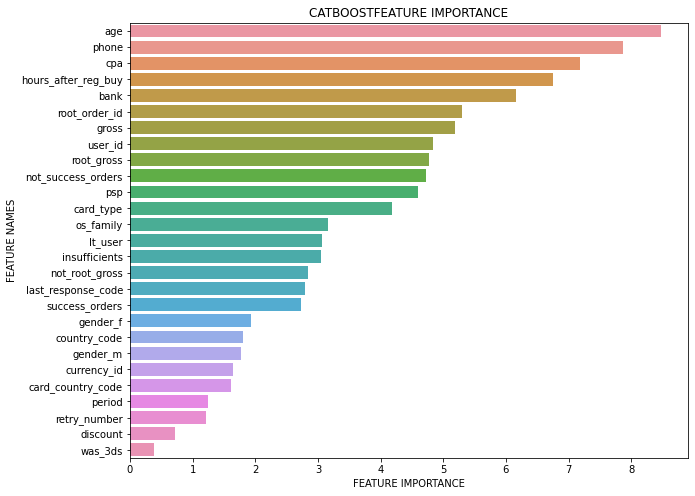

In [46]:
from catboost import Pool
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = X_train
target = y_train
pool = Pool(data, target)


def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    
#plot the catboost result
plot_feature_importance(model.get_feature_importance(pool),X_train.columns,'CATBOOST')

# Task 3

In [54]:
import pandas as pd

data = pd.read_csv('db/base.csv')
data = data.drop(['Unnamed: 0'],axis=1)
data

,current_dt,user_id,scheduled_dt,root_order_id,gender,age,os_family,lt_user,hours_after_reg_buy,country_code,...,was_3ds,card_type,card_country_code,success_orders,not_success_orders,insufficients,root_gross,not_root_gross,old_model_probability,is_success
0,2019-05-12 05:40:15.355095,13801584,2019-06-09 00:00:00.000000,96601292,f,43,11,2,0,154,...,0,2.0,154,2,0,0,29.17,6.81,0.512364,1
1,2019-06-07 08:10:15.982701,16144816,2019-06-09 00:00:00.000000,116843195,f,25,11,4,76,3,...,0,2.0,3,2,1,1,0.47,0.46,0.133615,1
2,2019-06-07 08:10:15.982701,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,1,0,1,...,0,2.0,1,2,1,0,0.48,6.67,0.481923,0
3,2019-06-08 03:10:13.314904,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,2,0,1,...,0,2.0,1,2,1,0,0.48,6.67,0.485032,0
4,2019-06-07 08:10:15.982701,16482460,2019-06-09 00:00:00.000000,116953235,m,45,11,1,0,1,...,0,2.0,1,1,1,1,0.48,0.00,0.114275,0
5,2019-06-08 03:10:13.314904,16482460,2019-06-09 00:00:00.000000,116953235,m,45,11,2,0,1,...,0,2.0,1,1,1,1,0.48,0.00,0.114605,0
6,2019-06-07 08:10:15.982701,16493856,2019-06-09 00:00:00.000000,117041055,m,41,11,1,0,1,...,0,2.0,1,1,0,0,0.48,0.00,0.304778,1
7,2019-06-08 03:10:13.314904,16493856,2019-06-09 00:00:00.000000,117041055,m,41,11,2,0,1,...,0,2.0,1,1,0,0,0.48,0.00,0.305821,1
8,2019-06-07 08:10:15.982701,16461292,2019-06-09 00:00:00.000000,117058275,m,34,11,1,8,1,...,0,2.0,1,2,0,0,0.48,6.67,0.429660,1


In [2]:
import sqlite3

sqliteConnection = sqlite3.connect('db/main.db')
cursor = sqliteConnection.cursor()

In [99]:
#cursor.execute("drop table User")

In [95]:
q = """
CREATE TABLE IF NOT EXISTS User(
    ID INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    current_dt timestamp, 
    user_id INTEGER NOT NULL,
    scheduled_dt timestamp,
    root_order_id INTEGER,
    gender char, 
    age INTEGER,
    os_family INTEGER, 
    lt_user INTEGER,
    hours_after_reg_buy INTEGER, 
    country_code INTEGER,
    phone nchar,
    cpa FLOAT,
    retry_number INTEGER,
    period INTEGER,
    gross FLOAT,
    currency_id INTEGER, 
    discount INTEGER,
    psp INTEGER,
    last_response_code INTEGER, 
    bank INTEGER,
    was_3ds BOOLEAN, 
    card_type INTEGER, 
    card_country_code INTEGER,
    success_orders INTEGER, 
    not_success_orders INTEGER,
    insufficients INTEGER, 
    root_gross FLOAT,
    not_root_gross FLOAT,
    model_probability FLOAT
);"""

cursor.execute(q)

In [96]:
def load_data_in_DB(data):
    
    for i in range(0,len(data)):
        mass = data.iloc[i].values.tolist()[:-2]
        q = "INSERT INTO User(current_dt , user_id , scheduled_dt , root_order_id , gender , age , os_family , lt_user , hours_after_reg_buy , country_code , phone , cpa , retry_number , period , gross , currency_id , discount , psp , last_response_code , bank , was_3ds , card_type , card_country_code , success_orders , not_success_orders , insufficients , root_gross , not_root_gross) VALUES " + str(tuple(mass)).replace("""'null'""",'null')
        cursor.execute(q)

In [97]:
def load_data_in_DB_with_prediction(data):
    
    X = data.drop(['current_dt','scheduled_dt'],axis=1)
    X = pd.get_dummies(X, prefix=['gender'], columns = ['gender'])
    X = X.drop(['old_model_probability','is_success'],axis=1)
    data['old_model_probability'] = catboostmodel.predict(X)
    data = data.drop(['is_success'],axis=1)

    for i in range(0,len(data)):
        mass = data.iloc[i].values.tolist()
        q = "INSERT INTO User(current_dt , user_id , scheduled_dt , root_order_id , gender , age , os_family , lt_user , hours_after_reg_buy , country_code , phone , cpa , retry_number , period , gross , currency_id , discount , psp , last_response_code , bank , was_3ds , card_type , card_country_code , success_orders , not_success_orders , insufficients , root_gross , not_root_gross, model_probability) VALUES " + str(tuple(mass)).replace("""'null'""",'null')
        cursor.execute(q)

In [98]:
load_data_in_DB(data)
load_data_in_DB_with_prediction(data)


result = cursor.execute("select * from User")

for row in result:
    print(row)

(1, '2019-05-12 05:40:15.355095', 13801584, '2019-06-09 00:00:00.000000', 96601292, 'f', 43, 11, 2, 0, 154, '2460.0', 1.51755555555556, 0, 30, 36.4655353027446, 23, 0, 9, 38, 329, 0, 2, 154, 2, 0, 0, 29.17, 6.81, None)
(2, '2019-06-07 08:10:15.982701', 16144816, '2019-06-09 00:00:00.000000', 116843195, 'f', 25, 11, 4, 76, 3, '5561.0', 0.587083333333333, 0, 30, 18.8988737589766, 19, 0, 10, 11, 1382, 0, 2, 3, 2, 1, 1, 0.47, 0.46, None)
(3, '2019-06-07 08:10:15.982701', 16467614, '2019-06-09 00:00:00.000000', 116847635, 'f', 45, 11, 1, 0, 1, '4370.0', 0.0, 0, 30, 20.1236251714959, 2, 0, 10, 33, 76, 0, 2, 1, 2, 1, 0, 0.48, 6.67, None)
(4, '2019-06-08 03:10:13.314904', 16467614, '2019-06-09 00:00:00.000000', 116847635, 'f', 45, 11, 2, 0, 1, '4370.0', 0.0, 0, 30, 20.2747998822558, 2, 0, 10, 33, 76, 0, 2, 1, 2, 1, 0, 0.48, 6.67, None)
(5, '2019-06-07 08:10:15.982701', 16482460, '2019-06-09 00:00:00.000000', 116953235, 'm', 45, 11, 1, 0, 1, '1296.0', 1.3, 0, 30, 20.1236251714959, 2, 0, 10, 11,